In [ ]:
# basic imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import json
import math
import seaborn as sns
import ast
from collections import Counter
import networkx as nx

# stats imports
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from scipy.stats import kstest
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

# regression imports
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# src imports
from src.utils import cleaning
#from src.utils import tokenization
from src.utils import filling
from src.utils import cluster_search
from src.data.continents_clusters import continents
from src.data.words_clusters import cluster_space
from src.data.words_clusters import cluster_communism

# Data loading

In [2]:
# data path
DATA = './data/'

# movie metadata loading
df_movies = pd.read_csv(DATA + 'movie.metadata.tsv', sep='\t', header=None)
df_movies.columns = ['wikipedia_id', 'freebase_id', 'title', 'release_date', 'revenue', 
                     'runtime', 'spoken_languages', 'countries', 'genres']

# charcaters metadata loading
df_characters = pd.read_csv(DATA + 'character.metadata.tsv', sep='\t', header=None)
df_characters.columns = ['wikipedia_id', 'freebase_id', 'release_date', 'character_name', 'actor_birth',
                     'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 
                     'age_at_release', 'freebase_map', 'freebase_character_id', 'freebase_actor_id']

# plot summaries loading
df_plots = pd.read_csv(DATA + 'plot_summaries.txt', sep='\t', header=None, names=['wikipedia_id', 'plot_summary'])

# TMDB dataset loading
df_tmdb = pd.read_csv(DATA + 'TMDB_movie_dataset_v11.csv')

# ratings datasets loading
df_ratings_link = pd.read_csv(DATA + 'ratings_links.csv', sep=',')
df_ratings_ratings = pd.read_csv(DATA + 'ratings_ratings.csv', sep=',')

For now, the plots dataset `df_plots` does not require any cleaning operation, as the dataset presents 0% missing values in its columns with no particular format to standardize. However, the movies and characters dataset do require significant cleaning, as is presented below.

# Movies dataset wrangling

Duplicate movies exist in the movies dataset and are first considered.

In [3]:
# df_movies has duplicates of the same movies which will be discarded based on keeping  
# the entry that has the least number of missing values among the other columns. Only 
# duplicate mmovies with equal countries are kept
df_movies = cleaning.drop_most_missing(df_movies, ['title', 'countries'])

In [4]:
# doing the same duplicates cleaning as before for df_tmdb, considering 
# 'production_countries' instead of 'countries'
df_tmdb = cleaning.drop_most_missing(df_tmdb, ['title', 'production_countries'])

With duplicate movies dropped, the TMDB dataset can be merged as to enrich the movie metadata.

In [5]:
# merging df_movies and df_tmdb
df_movies_tmdb = pd.merge(df_movies, df_tmdb, on='title')

# drop some duplicate columns and then rename
df_movies_tmdb = df_movies_tmdb.drop(['spoken_languages_y'], axis = 1).rename(columns={'spoken_languages_x': 'spoken_languages'}) 
df_movies_tmdb = df_movies_tmdb.drop(['genres_y'], axis = 1).rename(columns={'genres_x': 'genres'}) 

In [6]:
# cleaning 'spoken_languages', 'countries', 'genres' df_movies columns in df_movies_tmdb
df_movies_tmdb['spoken_languages'] = df_movies_tmdb['spoken_languages'].apply(cleaning.clean_idxs)
df_movies_tmdb['countries'] = df_movies_tmdb['countries'].apply(cleaning.clean_idxs)
df_movies_tmdb['genres'] = df_movies_tmdb['genres'].apply(cleaning.clean_idxs)

In [7]:
# use the release date of the TMDB dataset to fill the release date of a movie if not present in CMU dataset
df_movies_tmdb['release_date_x'] = df_movies_tmdb['release_date_x'].fillna(df_movies_tmdb['release_date_y'])

# drop missing release dates, remove duplicate column and rename release_date_x
df_movies_tmdb = df_movies_tmdb.dropna(subset=['release_date_x'])
df_movies_tmdb = df_movies_tmdb.drop(['release_date_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'release_date_x': "release_date"}) 

# clean dates to keep the release year only (first four digits of the attribute)
df_movies_tmdb['release_date'] = df_movies_tmdb['release_date'].apply(cleaning.clean_dates)

# filter dates to meaningful ones by keeping the release interval [1888, 2012], since 
# the very first movie was released in 1888 and meaningful data from df_movies is up to 2012
df_movies_tmdb = cleaning.filter_years(df_movies_tmdb, 'release_date')

In [8]:
# use the revenues of the TMDB dataset to fill the revenues of a movie if not present in CMU dataset
df_movies_tmdb['revenue_x'] = df_movies_tmdb['revenue_x'].fillna(df_movies_tmdb['revenue_y'])

# remove duplicate column and rename revenue_x
df_movies_tmdb = df_movies_tmdb.drop(['revenue_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'revenue_x': "revenue"}) 

In [9]:
# use the runtimes of the TMDB dataset to fill the runtimes of a movie if not present in CMU dataset
df_movies_tmdb['runtime_x'] = df_movies_tmdb['runtime_x'].fillna(df_movies_tmdb['runtime_y'])

# remove duplicate column and rename runtime_x
df_movies_tmdb = df_movies_tmdb.drop(['runtime_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'runtime_x': "runtime"}) 

In [10]:
# remove movies with no genre reported
df_movies_tmdb = df_movies_tmdb.dropna(subset=['genres'])

In [11]:
# dropping movies that have missing IMDB IDs
df_movies_tmdb = df_movies_tmdb.dropna(subset=["imdb_id"])
df_movies_tmdb = df_movies_tmdb.drop(df_movies_tmdb[df_movies_tmdb["imdb_id"] == 'nan'].index)

# IMDB references in df_movies_tmdb are formatted differently than in df_ratings_link
df_movies_tmdb['imdb_id'] = df_movies_tmdb['imdb_id'].apply(cleaning.clean_imdb)

With the enrich movie metadata wrangled, the mean ratings for movies are their final attribute to consider. These ratings are retrieved externally, as detailed in the readme.

In [12]:
# retrieving mean ratings
mean_ratings = df_ratings_ratings.groupby(df_ratings_ratings["movieId"]).mean()
mean_ratings = mean_ratings.drop('userId', axis=1)
mean_ratings = mean_ratings.rename({'rating': 'mean_rating', 'timestamp': 'mean_rating_timestamp'}, axis=1)

# merging the average ratings to their movies through df_ratings_link
df_ratings_linked = pd.merge(df_ratings_link, mean_ratings, left_on='movieId', right_on='movieId')

# merging the ratings to df_movies_tmdb
df_movies_tmdb_ratings = pd.merge(df_movies_tmdb, df_ratings_linked, left_on='imdb_id', right_on='imdbId')

unique_ratings = len(df_movies_tmdb_ratings["title"].unique())
print(f"There are {unique_ratings} unique movies in our movies dataset that have ratings given by the found dataset.")

There are 24140 unique movies in our movies dataset that have ratings given by the found dataset.


In [13]:
# binning ratings to match viewers regular rating style (.5 vote scale)
df_movies_tmdb_ratings['mean_rating_binned'] = df_movies_tmdb_ratings.mean_rating.mul(2).round().div(2)

In [14]:
# dropping many useless columns
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['id'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['status'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['vote_average'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['vote_count'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['backdrop_path'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['homepage'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['original_title'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['overview'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['popularity'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['poster_path'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['tagline'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['keywords'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['movieId'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['imdbId'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['tmdbId'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['adult'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['production_countries'], axis = 1)

In [15]:
# replacing the runtime outliers with mean of non-outliers, assuming normality, apply +/- t*IQR of quantiles method
df_movies_tmdb_ratings = filling.fill_iqr(df_movies_tmdb_ratings, 'runtime', 3.5)

By doing this, we are losing some outliers which might be interesting to study. For example, late 1800s movies have usually very short runtimes and this might be interesting to investigate.

Dealing with multiple genres movies is not trivial. Exploding multiple-genres movies might be a solution but one needs to be careful about the influence of this on the overall statistics of the dataframe. A quick analysis on the #genres distribution shows the latter to be left-skewed, this implies that generally a movie has a low number of genres when this is larger than 1. This could justisfy the choice of exploding multiple genres movies. For later on analysis, a possible solution would be to choose unique movies starting from the standard movies dataframe, selecting a multiple repeated times movie based on the most relevant genre among the ones that belong to it.

The movie metadata wrangling is considered finished, and baseline visualizations of attributes within help in visualizing their contained data.

The mean number of genres of a given movie is:  5


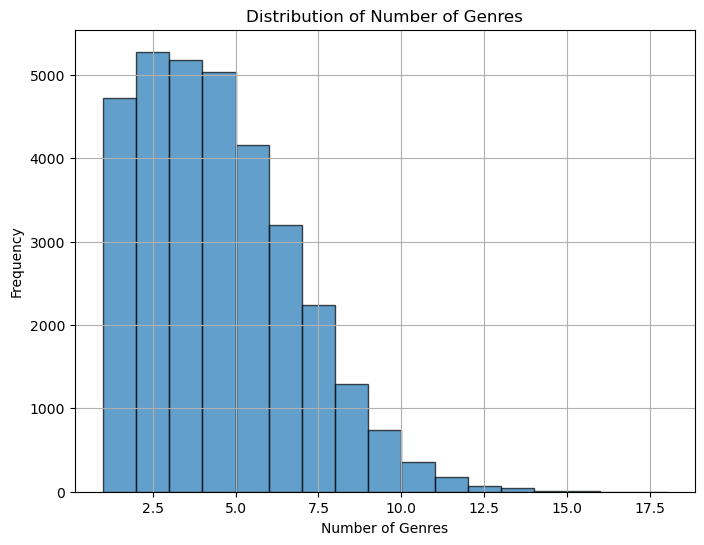

In [16]:
# getting the mean
print(f'The mean number of genres of a given movie is: ', math.ceil(df_movies_tmdb_ratings['genres'].apply(len).mean()))

# plotting the distribution
n_genres = df_movies_tmdb_ratings['genres'].apply(len)
plt.figure(figsize=(8, 6))
plt.hist(n_genres, bins=range(1, max(n_genres) + 2), edgecolor='black', alpha=0.7)
plt.title('Distribution of Number of Genres')
plt.xlabel('Number of Genres')
plt.ylabel('Frequency')
plt.grid(True)

In addition, when exploding only some relevant genre-wise movies copies will be kept. For example, if a movie has between genres 'Drama' and 'Acid western', with the first one being way more common than the second in the dataframe, only the movie copy with 'genre' == 'drama' is kept. This allows for a smaller influence of the explode operation on the overall statistics of the datframe, while maintaining a nice standard dataframe structure which is easy to handle genre-wise. 

In [17]:
# exploding df_movies_tmdb_ratings genres to retrieve most relevant ones
df_movies_tmdb_ratings_exploded = df_movies_tmdb_ratings.explode("genres")

# find and sort number of movies for each exploded genre
genres_counts = df_movies_tmdb_ratings_exploded.groupby("genres").size()
genres_counts = genres_counts.sort_values(axis=0, ascending=False)

# searching most relevant genres as the ones that correspond to 90% of the total data
genres_proportions = genres_counts.cumsum() / genres_counts.sum()
n = len(genres_proportions[genres_proportions < 0.9])
genres_relevant = genres_proportions.head(n).index.tolist()

In [18]:
# splitting single and multi-genres
df_movies_tmdb_ratings_multi = df_movies_tmdb_ratings[df_movies_tmdb_ratings['genres'].apply(len) > 1]
df_movies_tmdb_ratings = df_movies_tmdb_ratings[df_movies_tmdb_ratings['genres'].apply(len) == 1]

# selecting exploded movies whose genres are among the most relevant ones
df_movies_tmdb_ratings_multi = df_movies_tmdb_ratings_multi.explode('genres')
df_movies_tmdb_ratings_multi = df_movies_tmdb_ratings_multi[df_movies_tmdb_ratings_multi['genres'].isin(genres_relevant)]

# joining the dataframes
df_movies_tmdb_ratings = pd.concat([df_movies_tmdb_ratings, df_movies_tmdb_ratings_multi], ignore_index=True)

# converting 'genres' column type
df_movies_tmdb_ratings['genres'] = df_movies_tmdb_ratings['genres'].astype(str)

Now that the genres column has been cleaned, a similar analysis needs to be performed for the 'spoken_languages' one and for 'countries'. Regarding the first one, since the TMDB dataset 'original_language' column has no missing values and has a standard format of one language per movie (e.g. en), this can be used without losing too much information or adding another heavy cleaning code. Considering the 'countries' column, one can follow a similar reasoning as before:

The mean number of countries of a given movie is:  2


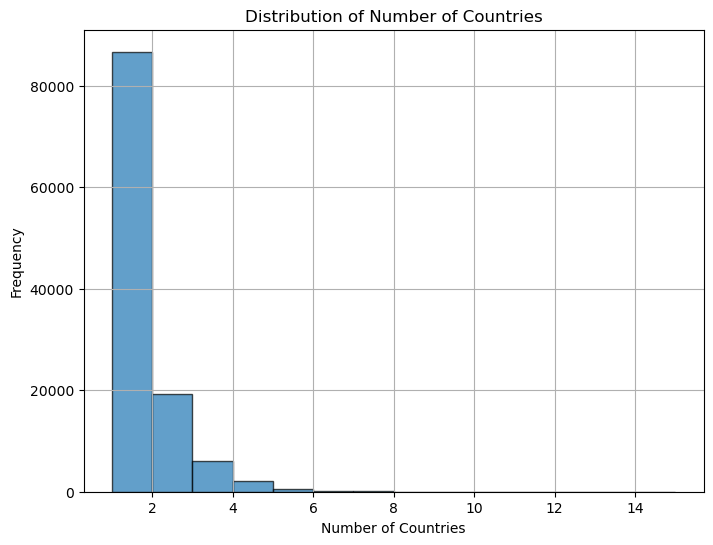

In [19]:
# dropping missing 'countries' entries
df_movies_tmdb_ratings.dropna(subset=['countries'], inplace=True)

# getting the mean
print(f'The mean number of countries of a given movie is: ', math.ceil(df_movies_tmdb_ratings['countries'].apply(len).mean()))

# plotting the distribution
n_countries = df_movies_tmdb_ratings['countries'].apply(len)
plt.figure(figsize=(8, 6))
plt.hist(n_countries, bins=range(1, max(n_countries) + 2), edgecolor='black', alpha=0.7)
plt.title('Distribution of Number of Countries')
plt.xlabel('Number of Countries')
plt.ylabel('Frequency')
plt.grid(True)

The distribution is heavily left-skewed. Therefore, exploding by countries will not alter the statistics of the dataframe in a too relevant way. Since the number of added entries through exploding is not too large and since one of the main interests of the team's datastory is the geographical analysis of movies, all countries will be kept (i.e. no relevant countries procedure will be applied, opposite to what has been done for genres). Note that, once again, depending on the interested analysis to be performed only one entry for a specific duplicated movie can be easily considered with the current dataframe structure.

In [20]:
# exploding countries
df_movies_tmdb_ratings = df_movies_tmdb_ratings.explode('countries')

In [21]:
# final ordering of the standard dataframe
df_movies_tmdb_ratings = df_movies_tmdb_ratings.sort_values(by='title')

# in the 'revenue' column, substitute 0.0 with nan for clarity
df_movies_tmdb_ratings['revenue'] = df_movies_tmdb_ratings['revenue'].replace(0.0, None)

# convert 'revenue' column to numeric values, raise error message in case of problems
df_movies_tmdb_ratings['revenue'] = pd.to_numeric(df_movies_tmdb_ratings['revenue'], errors='coerce')

In [22]:
# in the 'budget' column, substitute 0.0 with nan for clarity
df_movies_tmdb_ratings['budget'] = df_movies_tmdb_ratings['budget'].replace(0.0, None)

The final standard dataframe for movies data is `df_movies_tmdb_ratings`. The only columns which present some missing values are, in ascending order of missing data: `budget`, `'spoken_languages'` (recall that `'original_language'` with 0% missing data is available), `'production_companies'`, `'revenue'`.

In [23]:
unique_titles_now = len(df_movies_tmdb_ratings['title'].unique())
unique_titles_before = len(df_movies)
print(f"There are now {unique_titles_now} unique movies in the standard movies dataset.")
print(f"There were {unique_titles_before} unique movies in the initial movies dataset.")

There are now 23432 unique movies in the standard movies dataset.
There were 79347 unique movies in the initial movies dataset.


In [24]:
# deleting not used dataframes (but keeping the original ones)
del df_movies_tmdb
del df_movies_tmdb_ratings_exploded
del df_movies_tmdb_ratings_multi
del df_ratings_linked

### Adding `continent` Column to the Master Dataframe

Part of our analysis involves considering geographical groupings, which have been manually clustered by continent.

In [25]:
# dictionary to map each country to a continent
country_to_continent = {country: continent for continent, countries in continents.items() for country in countries}

# add the column 'continent'
df_movies_tmdb_ratings['continent'] = df_movies_tmdb_ratings['countries'].map(country_to_continent)

# since df_movies_tmdb_ratings[df_movies_tmdb_ratings['continent'].isna()] shows that 2 entries
# have not been assigned to a continent, a quick check allows to see that this is due to an error 
# in the country (the specific movie is 'The Flying Scotsman'). These entries are therefore dropped
df_movies_tmdb_ratings = df_movies_tmdb_ratings.dropna(subset=['continent'])

## Defining a master movies dataset
`df_movies_tmdb_ratings` is now one of the master dataframes. Since two columns have been exploded (`genres`, `revenues`) statistics might have been altered. Therefore, a smaller dataframe containing only unique titles must be defined to analyze features such as `revenue` or the ratings-related ones. Unique titles rows with the smallest amount of missing values among columns will be selected. This final master dataframe is `df_movies_tmdb_ratings_unique`.

In [26]:
df_movies_tmdb_ratings_unique = cleaning.drop_most_missing(df_movies_tmdb_ratings, ['title'])

# drop 'missing_values' column of df_movies_tmdb_ratings
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(columns=['missing_values'])

# dropping duplicates (just in case there are any duplicates after the selection process)
df_movies_tmdb_ratings_unique = df_movies_tmdb_ratings_unique.drop_duplicates(subset='title')

# Characters Dataset Cleaning

Analogous to the movie metadata, the characters dataset must be wrangled.

In [27]:
# clean characters 'release_date' and 'actor_birth' to keep the release year only
df_characters['release_date'] = df_characters['release_date'].apply(cleaning.clean_dates)
df_characters['actor_birth'] = df_characters['actor_birth'].apply(cleaning.clean_dates)

The datastory will most probably focus on actor ethnicity, therefore particular attention is payed to the related columns in `df_characters`.

In [28]:
# counting the number of unique values in 'actor_ethnicity', excluding NaN
print(f"Number of unique ethnicities in 'actor_ethnicity': {df_characters['actor_ethnicity'].nunique(dropna=True)} \n")

# counting the number of NaN values in 'actor_ethnicity'
print(f"Number of NaN values in 'actor_ethnicity': {df_characters['actor_ethnicity'].isna().sum()}")

# total number of entries in 'actor_ethnicity' column
print(f"Total entries in 'actor_ethnicity': {len(df_characters['actor_ethnicity'])}")

# NaN entries proportion
nan_proportion_ethnicity = df_characters['actor_ethnicity'].isna().sum() / len(df_characters['actor_ethnicity'])
print(f"Proportion of NaN values in 'actor_ethnicity': {nan_proportion_ethnicity:.2%}")

Number of unique ethnicities in 'actor_ethnicity': 479 

Number of NaN values in 'actor_ethnicity': 344611
Total entries in 'actor_ethnicity': 450669
Proportion of NaN values in 'actor_ethnicity': 76.47%


In [29]:
# counting the number of unique actors who have a non-NaN ethnicity
print(f"Unique actors who have an ethnicity: {df_characters.dropna(subset=['actor_ethnicity'])['actor_name'].nunique()}")

# counting the number of unique actors in total
print(f"Total number of unique actors: {df_characters['actor_name'].nunique()} \n")

# counting the number of unique movies (using either 'freebase_id' or 'wikipedia_id')
print(f"Total number of unique movies: {df_characters['freebase_id'].nunique()}")

# counting the number of unique movies with at least one actor who has a specified ethnicity
print(f"Unique movies with at least one actor with ethnicity: {df_characters.dropna(subset=['actor_ethnicity'])['freebase_id'].nunique() }")

Unique actors who have an ethnicity: 8148
Total number of unique actors: 134078 

Total number of unique movies: 64330
Unique movies with at least one actor with ethnicity: 37958


Actors' ethnicities are in the format of Freebase IDs. To translate them, these unique IDs have been saved in a `.txt` file, which has been translated using `query.wikidata.org` by executing the following SPARQL request:

```sparql
SELECT DISTINCT ?freebase_id ?wikidata_id ?label WHERE {
  VALUES ?freebase_id {
    "/m/05bzpzx" "/m/064rb5l" "/m/01km_m" "/m/059v8" "/m/03b_13l" "/m/09c8kp" "/m/05ztd1" 
    "/m/04c28" "/m/03sk2" "/m/04jtjvt" "/m/03hjx6f" "/m/027936c" "/m/03nvq" "/m/03nz70" 
    "/m/01g3rx" "/m/02wz7j" "/m/04kdwcx" "/m/04_8lfc" "/m/033qt1" "/m/08j1fb" "/m/07wsyr" 
    "/m/06vb7b" "/m/012fh" "/m/0dm3xpw" "/m/09r2kh" "/m/02ry8mk" "/m/029q52" "/m/026d074" 
    "/m/013y54"
    # Add more IDs as needed
  }
  ?wikidata_id wdt:P646 ?freebase_id.
  ?wikidata_id rdfs:label ?label.
  FILTER(LANG(?label) = "en")
}

The creation of the `.txt` file is achieved by `src/data/freebase_to_batches.py` and the result is `src/data/unique_actor_ethnicities_batexhes.txt`. The outputs from query.wikidata.org have been saved in a .csv file (`freebaseids_labels.csv`)

In [30]:
# defining src/data/ path
SRC_DATA = './src/data/'

# reading the .csv and saving it to a dataframe
df_labels = pd.read_csv(SRC_DATA + 'freebaseids_label.csv')
df_labels.columns = ['freebase_id', 'wikipedia_id', 'label']  

# mapping dictionary definition
freebase_to_label = dict(zip(df_labels['freebase_id'], df_labels['label']))

# creating 'ethnicity_label' column where to map the freebse ethnicity Ids to the 
# corresponding labels
df_characters['ethnicity_label'] = df_characters['actor_ethnicity'].map(freebase_to_label)

In [31]:
# calculating the proportion of nans in 'ethnicity_label'
nan_proportion_label = df_characters['ethnicity_label'].isna().sum() / len(df_characters['ethnicity_label'])

# checking if any information have been lost during the ids-label translation
print(f"Proportion of NaN values in 'actor_ethnicity': {nan_proportion_ethnicity:.2%}")
print(f"Proportion of NaN values in 'ethnicity_label': {nan_proportion_label:.2%}")

Proportion of NaN values in 'actor_ethnicity': 76.47%
Proportion of NaN values in 'ethnicity_label': 77.17%


Basically no information has been lost during the translation, which assures correct steps have been taken.

In [32]:
# printing some of the counts of unique values in 'ethnicity_label', excluding NaN
print("Unique values in 'ethnicity_label' and their counts:")
print(df_characters['ethnicity_label'].value_counts(dropna=True).head(10)) 

Unique values in 'ethnicity_label' and their counts:
ethnicity_label
Indians               16351
African Americans     10159
Jewish people         10121
English people         6165
Irish Americans        3857
Italian Americans      2956
White people           2307
White Americans        2250
Scottish Americans     2223
Irish people           1637
Name: count, dtype: int64


### Clustering Ethnicities
`/src/data/ethnicities_clusters.txt` contains divisions of ethnicities by main regions: Europeans (East-West Europe), Latin Americans, Africans (Subsaharians), MENA (Middle East and North Africa), North America, Carribean-Native Americans, Oceania, Asia and India. The file is made to be read as a dictionary.

In [33]:
# loading the .txt file as a dictionary
with open(SRC_DATA + "ethnicities_clusters.txt", "r") as file:
    ethnicities_clusters = ast.literal_eval(file.read())

In [34]:
# defining the ethnicity_to_clusters dictionary
ethnicity_to_clusters = {}
for cluster, labels in ethnicities_clusters.items():
    for label in labels:
        # checking if the label is already in the dictionary
        if label not in ethnicity_to_clusters:
            # init a new empty list
            ethnicity_to_clusters[label] = []
        ethnicity_to_clusters[label].append(cluster)

# mapping the clusters
df_characters['mapped_clusters'] = df_characters['ethnicity_label'].apply(
    lambda x: ethnicity_to_clusters[x] if x in ethnicity_to_clusters else None)

In [35]:
# searching unique ethnicity labels where 'mapped_clusters' is missing
unmatched_ethnicities = df_characters[df_characters['mapped_clusters'].isna()]['ethnicity_label'].unique()

Since the labels are still incomplete for a large part, information from wikidata is adopted to enrich the `df_characters` dataframe. For each actor (using his freebase_id), a query has been requested to retrieve ethnicity or nationality if available. Everything is saved in `wikidata_actor_info.csv`.

In [36]:
# reading the .csv as a dataframe
df_wikidata = pd.read_csv(SRC_DATA + 'wikidata_actor_info.csv', sep=',')

# left merging df_characters and df_wikidata
df_characters = pd.merge(df_characters, df_wikidata, left_on="freebase_actor_id", right_on="freebaseID", how="left")

In [37]:
# filling 'ethnicity_label', where necessary, with the new labels extracted from wikidata
# (either 'ethnicityLabel' or 'nationalityLabel' if the first is nan)
df_characters['ethnicity_label'] = df_characters.apply(
    lambda x: filling.fill_col1(x, 'ethnicity_label', 'ethnicityLabel','nationalityLabel', unmatched_ethnicities), axis=1)

# printing the final results
print(f"Before filling, the proportion of NaN values in 'ethnicity_label' was: {nan_proportion_label:.2%}")

# re-computing the proportion of nan in 'ethnicity_labels'
nan_proportion_label = df_characters['ethnicity_label'].isna().sum() / len(df_characters['ethnicity_label'])
print(f"After filling, the proportion of NaN values in 'ethnicity_label' is: {nan_proportion_label:.2%}")

Before filling, the proportion of NaN values in 'ethnicity_label' was: 77.17%
After filling, the proportion of NaN values in 'ethnicity_label' is: 36.54%


The proportion of missing values in `'ethnicity_label'` has been halved through filling it with wikidata information. This allows to save a big part of the original dataframe when dropping nan values in the `'ethnicity_label'` column. Now, new ethnicities can be mapped to the clusters in `ethnicities_clusters.txt` file, after updating the latter. Note that, for simplicity, only the last updated version of this file is stored in `/src/data/`, therefore also in the first clustering this version has been adopted. 

In [38]:
# defining the new_ethnicity_to_clusters dictionary
new_ethnicity_to_clusters = {}
for cluster, labels in ethnicities_clusters.items():
    for label in labels:
        # checking if the label is already in the dictionary
        if label not in new_ethnicity_to_clusters:
            # init a new empty list
            new_ethnicity_to_clusters[label] = []
        new_ethnicity_to_clusters[label].append(cluster)

# mapping the clusters by updating the corresponding column
df_characters['mapped_clusters'] = df_characters['ethnicity_label'].apply(
    lambda x: new_ethnicity_to_clusters[x] if x in new_ethnicity_to_clusters else None)

# converting every entry on 'mapped_cluster' to list, ecluding nan
df_characters['mapped_clusters'] = df_characters['mapped_clusters'].apply(
    lambda x: list(x) if not isinstance(x, list) and pd.notna(x) else x)

# since the 'mapped_clusters' column sometimes contains duplicates in the same list these are removed
df_characters['mapped_clusters'] = df_characters['mapped_clusters'].apply(
    lambda x: list(dict.fromkeys(x)) if isinstance(x, (list, np.ndarray)) else x)

In [39]:
# dropping useless columns
df_characters= df_characters.drop(['freebaseID'], axis = 1)
df_characters= df_characters.drop(['actorLabel'], axis = 1)
df_characters= df_characters.drop(['ethnicityLabel'], axis = 1)
df_characters= df_characters.drop(['nationalityLabel'], axis = 1)

`df_characters` is now cleaned for the first analysis to be conducted. Note that, as for now, missing entries have not yet been dropped.

## Movies Initial Basic Statistics

To begin analyzing the movie and characters datasets in their wrangled form, some general information about the movies dataframe are retrieved. First, the movies distribution by `release_date` is plotted.

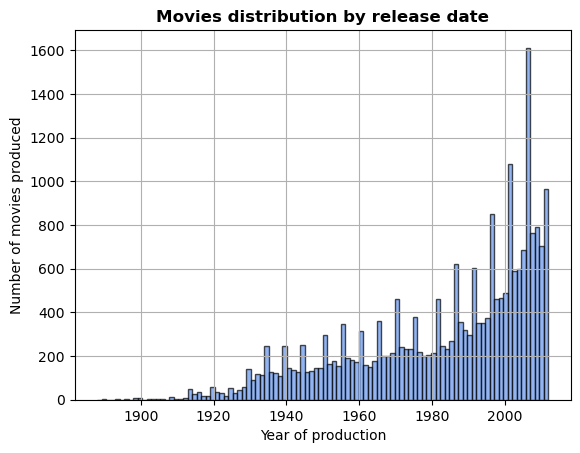

In [40]:
# Movies distribution by release date
plt.figure()
plt.title('Movies distribution by release date', weight='bold')
plt.hist(df_movies_tmdb_ratings_unique['release_date'], bins= 100, edgecolor='black', alpha=0.7, color='cornflowerblue')
plt.xlabel('Year of production')
plt.ylabel('Number of movies produced')
plt.grid(True)
plt.show()

From the above graph, it can be concluded that the number of movies producd each year steeply increases over time. However, the null hypothesis that the `release_date` distribution is exponential is rejected (p-value < 0.05).

In [41]:
print(diagnostic.kstest_normal(df_movies_tmdb_ratings_unique['release_date'], dist = 'exp'))

(0.6165337115771315, 0.0009999999999998899)


Other numerical parameters are then analysed. In the dataframe, `runtime` and `revenue` all present numerical values. The distributions of these features are plotted over time.

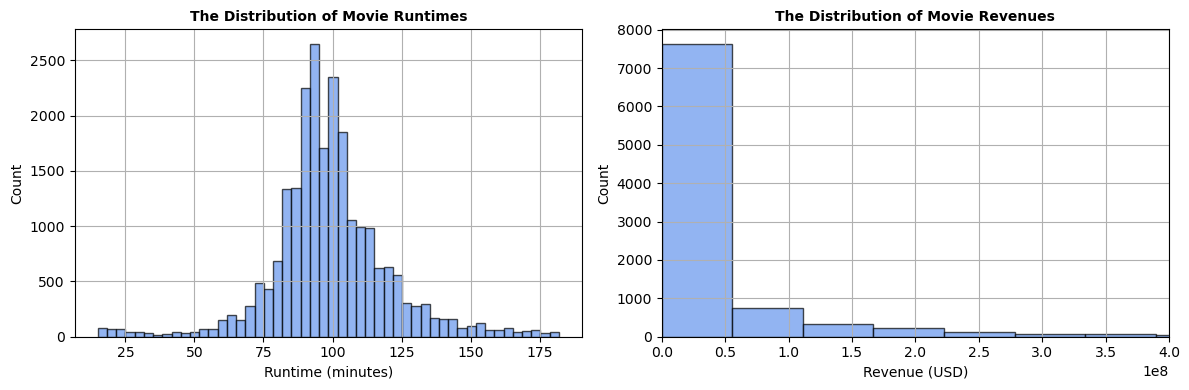

In [42]:
# standard font for plots
hfont = {'fontname':'sans-serif'}

# plotting the three distributions
fig, ax = plt.subplots(1, 2, figsize= (12, 4), sharey = False, sharex = False)

# labels
quantities = ['runtime', 'revenue']
quantities_x = ['Runtime (minutes)', 'Revenue (USD)']

# distribution of runtime
sbplt = ax[0]
sbplt.hist(df_movies_tmdb_ratings_unique[quantities[0]].values, edgecolor='black', alpha=0.7, bins = 50, color='cornflowerblue')
sbplt.set_title("The Distribution of Movie Runtimes", **hfont, weight='bold', fontsize=10)
sbplt.set_xlabel(quantities_x[0], fontsize=10)
sbplt.set_ylabel("Count", fontsize=10)
sbplt.grid(True)

# distribution of revenues
sbplt = ax[1]
sbplt.hist(df_movies_tmdb_ratings_unique[quantities[1]].values, edgecolor='black', alpha=0.7, bins = 50, color='cornflowerblue')
sbplt.set_title("The Distribution of Movie Revenues", weight='bold', fontsize=10)
sbplt.set_xlabel(quantities_x[1], fontsize=10)
sbplt.set_ylabel("Count", fontsize=10)
sbplt.set_xlim([0, 0.4e9])
sbplt.grid(True)

fig.tight_layout()

From the graphs above, we suspect the movie `runtime` to follow a normal distribution, while the movie `revenue` to follow an exponential distribution.

In [43]:
# testing if the runtime is normally distributed
print(diagnostic.kstest_normal(df_movies_tmdb_ratings_unique['runtime'], dist = 'norm'))

(0.09415224004382783, 0.0009999999999998899)


Although the `runtime` normality test returns a low p-value, leading us to reject the null hypothesis that the data is normally distributed, the histogram above shows a roughly bell-shaped plot for movie runtime. We know that Kolmogorov-Smirnov tests are sensitive to sample size, and our dataset contains >23K entries. Therefore, a Q-Q plot is employed to further assess normality.

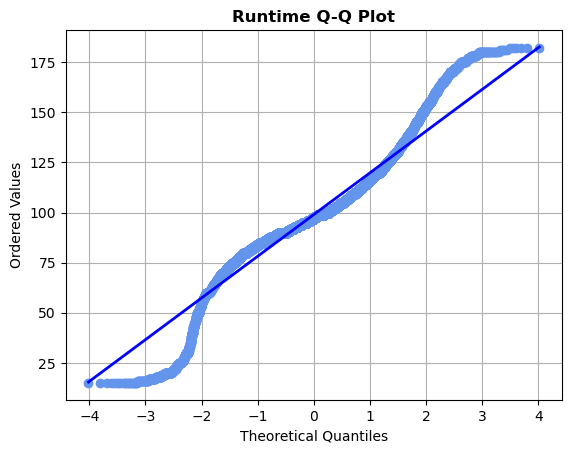

In [44]:
# setting up the figure
fig, ax = plt.subplots()

# Q-Q plot
res = stats.probplot(df_movies_tmdb_ratings_unique['runtime'], dist="norm", plot=ax)

# line settings
line = ax.get_lines()[0]
line_normal = ax.get_lines()[1]
line.set_color('cornflowerblue') 
line.set_linewidth(2)
line_normal.set_color('blue') 
line_normal.set_linewidth(2)

# plot settings 
plt.title("Runtime Q-Q Plot", weight='bold')
plt.xlabel("Theoretical Quantiles", fontsize=10)
plt.ylabel("Ordered Values", fontsize=10)
plt.grid(True)

The steep increases near the plot's edges indicate at `runtime` values at the extremes of our distribution that there are less values than expected if the plot were to follow a normal trend. The opposite is true for the flatter region of the plot near the center of the theoretical quantiles, indicating we have more runtimes close to the mean of the distribution than expected if the runtimes were normal. So, the `runtime` data is approximately normal but with a more datapoints more aggregated towards the distribution's mean.

Now, the `revenue` distribution is tested, to check if it is exponential.

In [45]:
diagnostic.kstest_normal(df_movies_tmdb_ratings_unique['revenue'].dropna(), dist = 'exp') 

(0.32293016704458477, 0.0009999999999998899)

Similarly to the runtime normality test, the `revenue` exponential test returns a low p-value, leading us to reject the null hypothesis that the data is exponentially distributed. However, the histogram above shows a roughly power-law plot for movie `revenue`. Again, we know that Kolmogorov-Smirnov tests are sensitive to sample size, and our dataset contains >23K entries. Therefore, a complementary cumulative density function of the `revenue` data is prepared.

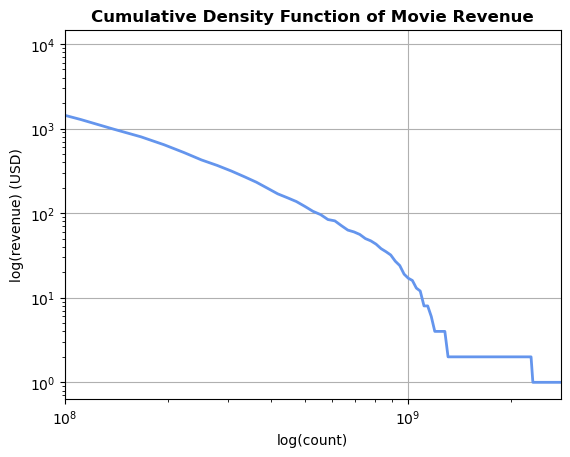

In [46]:
# setting up the figure
fig, ax = plt.subplots()

# cumulative density function plot
array_cumulative=plt.hist(df_movies_tmdb_ratings_unique['revenue'], bins=100, log=True, cumulative=-1, histtype='step', visible=False)
plt.loglog(array_cumulative[1][1:],array_cumulative[0])

# line settings
line = ax.get_lines()[0]
line.set_color('cornflowerblue') 
line.set_linewidth(2)

# plot settings 
plt.title('Cumulative Density Function of Movie Revenue', weight='bold')
plt.xlabel('log(count)')
plt.ylabel('log(revenue) (USD)')
ax.set_xlim(1e8, max(array_cumulative[1][1:]))
plt.grid(True)

The CCDF of `revenue` is approximately linearly decreasing, indicative the `revenue` data to be approximately power law distributed.

Now, possible correlations between these attributes are analysed. First, some plots are used to better visualize relationships.

c:\Users\bosca\anaconda3\envs\ada\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


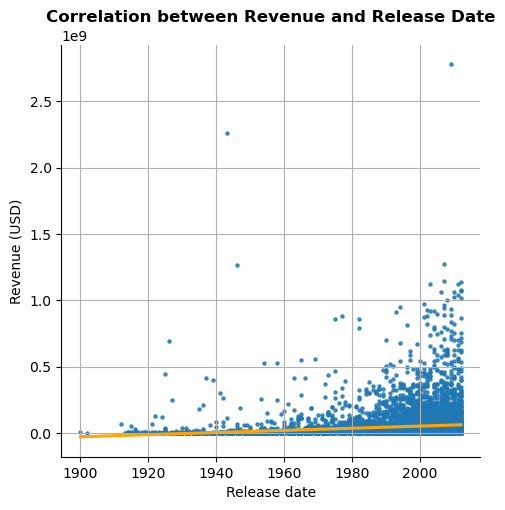

In [47]:
# scatter-plot to assess possible regressions between release date and revenue
sns.lmplot(x='release_date', y='revenue', data=df_movies_tmdb_ratings_unique, scatter_kws={'s': 5}, line_kws={'color': 'orange'})
plt.title('Correlation between Revenue and Release Date', weight='bold')
plt.xlabel("Release date")
plt.ylabel("Revenue (USD)")
plt.grid(True)

# TODO

Say something about the graph above, once it is run with the corrected dataframe. Specify that, since it is hardly linearly fittable, the linear regression analysis is not taken into consideration. Talk about outliers.

The same scatter plot is used to assess a possible correlation between `runtime` and `revenue`.

c:\Users\bosca\anaconda3\envs\ada\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


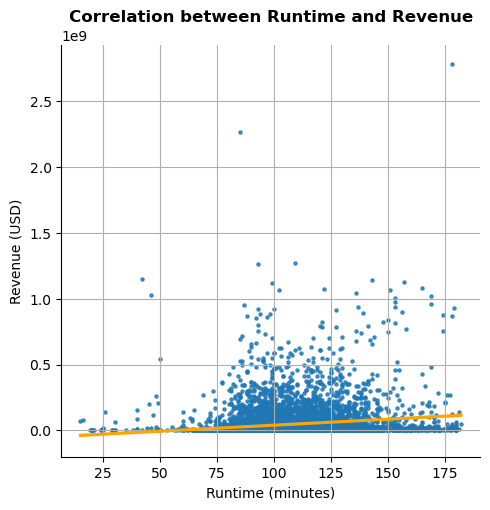

In [48]:
# scatter-plot to assess possible regressions between runtime and revenue
sns.lmplot(x='runtime',y='revenue', data=df_movies_tmdb_ratings_unique, scatter_kws={'s': 5}, line_kws={'color': 'orange'})
plt.title('Correlation between Runtime and Revenue', weight='bold')
plt.xlabel("Runtime (minutes)")
plt.ylabel("Revenue (USD)")
plt.grid(True)

# TODO

Say something about the graph above, once it is run with the corrected dataframe. Specify that, since it is hardly linearly fittable, the linear regression analysis is not taken into consideration.

The last combination is analysed: `runtime` and `release_date`.

c:\Users\bosca\anaconda3\envs\ada\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


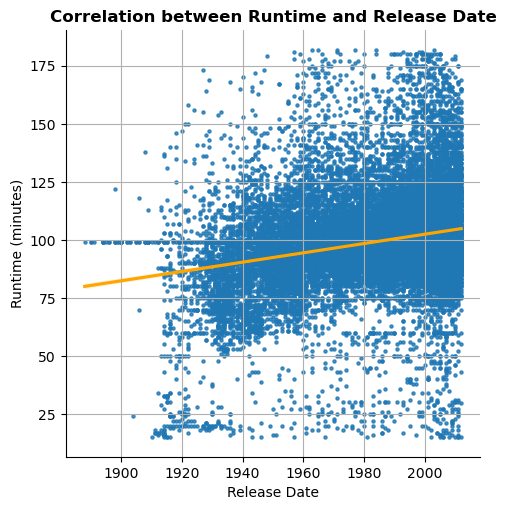

In [49]:
# Scatter-plot to assess possible regressions between runtime and release date
sns.lmplot(x='release_date',y='runtime', data=df_movies_tmdb_ratings_unique, scatter_kws={'s': 5}, line_kws={'color': 'orange'})
plt.title('Correlation between Runtime and Release Date', weight='bold')
plt.xlabel("Release Date")
plt.ylabel("Runtime (minutes)")
plt.grid(True)
plt.show()

# TODO

Add pearson coeff to see positive slope. Say something about the graph above, once it is run with the corrected dataframe. Specify that, since it is hardly linearly fittable, the linear regression analysis is not taken into consideration.

## Movies Genres Analysis

First, the number of unique genres has to be displayed.

In [50]:
# printing the number of unique genres
print("The number of different genres is:")
print(len(df_movies_tmdb_ratings['genres'].unique()))

The number of different genres is:
156


The number of different genres is more than 100. For the sake and clarity of the analysis, it is ideal to study a limited number of genres. Therefore, the code below estimates the percentage of the movies that would be considered, if the analysis only included n genres.

In [51]:
# choosing the number of relevant genres
n = 20

# selecting the n most relevant genres
genres_counts = df_movies_tmdb_ratings.groupby("genres").size()
genres_counts = genres_counts.sort_values(ascending=False)
genres_top = genres_counts.head(n)

top_genres_count = genres_top.sum()
all_genres_count = genres_counts.sum()

print(f"The top 20 basic genres in the movies dataset account for {round(top_genres_count/all_genres_count * 100)}% of all movie genres.")

# creating a new dataset, containing only movies from the relevant genres
top_genres = genres_top.index.tolist()
df_movies_tmdb_ratings_genres_filtered = df_movies_tmdb_ratings[df_movies_tmdb_ratings["genres"].isin(top_genres)].copy()

# printing the number of movies per genre
print('\n Number of movies per genre:')
print(df_movies_tmdb_ratings_genres_filtered['genres'].value_counts())

The top 20 basic genres in the movies dataset account for 68% of all movie genres.

 Number of movies per genre:
genres
Drama               20529
Comedy               9663
Thriller             8221
Romance Film         7436
World cinema         7140
Action               5803
Crime Fiction        5413
Indie                4792
Action/Adventure     4545
Horror               3974
Adventure            3801
Black-and-white      3529
Romantic drama       3328
Mystery              2876
Fantasy              2639
Period piece         2582
Family Film          2527
Science Fiction      2502
Crime Thriller       2469
Film adaptation      2276
Name: count, dtype: int64


Almost 70% of the total number of movies is described, if the analysis focuses more on 20 "relevant", or most common, genres. Regarding the number of movies per genre, every genre has more than 2'000 movies. Drama, the most present genre, has more than 20'000 movies. From the loading and cleaning section, it is clear that many movies have more than 1 genre. Having multiple genres can be defined as 'genres complexity' and this feature is studied over time, in order to see the genres complexity distribution based on the release date of the movie.

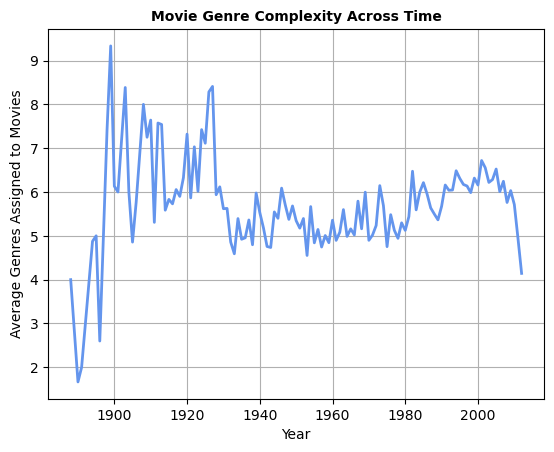

In [52]:
# counting the number of genres for each film
unique_genres_count = df_movies_tmdb_ratings.groupby('title')['genres'].nunique()
unique_genres_count = unique_genres_count.to_frame()
unique_genres_count = unique_genres_count.reset_index()

unique_genres_count = unique_genres_count.rename(columns={"genres": "genres_count"}) 
df_movies_tmdb_ratings = pd.merge(df_movies_tmdb_ratings, unique_genres_count, left_on='title', right_on='title')

mean_genres_per_year = df_movies_tmdb_ratings.groupby('release_date')["genres_count"].mean()

# visualizing if more than one genre being given to a film has increased over years
fig, ax = plt.subplots()

mean_genres_per_year.plot(kind='line')  

line = ax.get_lines()[0]
line.set_color('cornflowerblue') 
line.set_linewidth(2)

plt.title("Movie Genre Complexity Across Time", **hfont, weight='bold', fontsize=10)
plt.xlabel("Year", fontsize=10)
plt.ylabel("Average Genres Assigned to Movies", fontsize=10)
plt.grid(True)

It is evident that there are some fluctuations, but the genres complexity does not drastically increase over time. Instead, the first movies, from 1900 to 1930, generally present much higher genres complexity. This figure produced per country and then across time period worldwide would be interesting.

The plot below focus on the distribution of movies in time, divided per genre. Only the most relevant genres are displayed. The objective is to find particular or evident trends to study. Note that, to better visualize the graphs, the y-axis range changes between graphs.

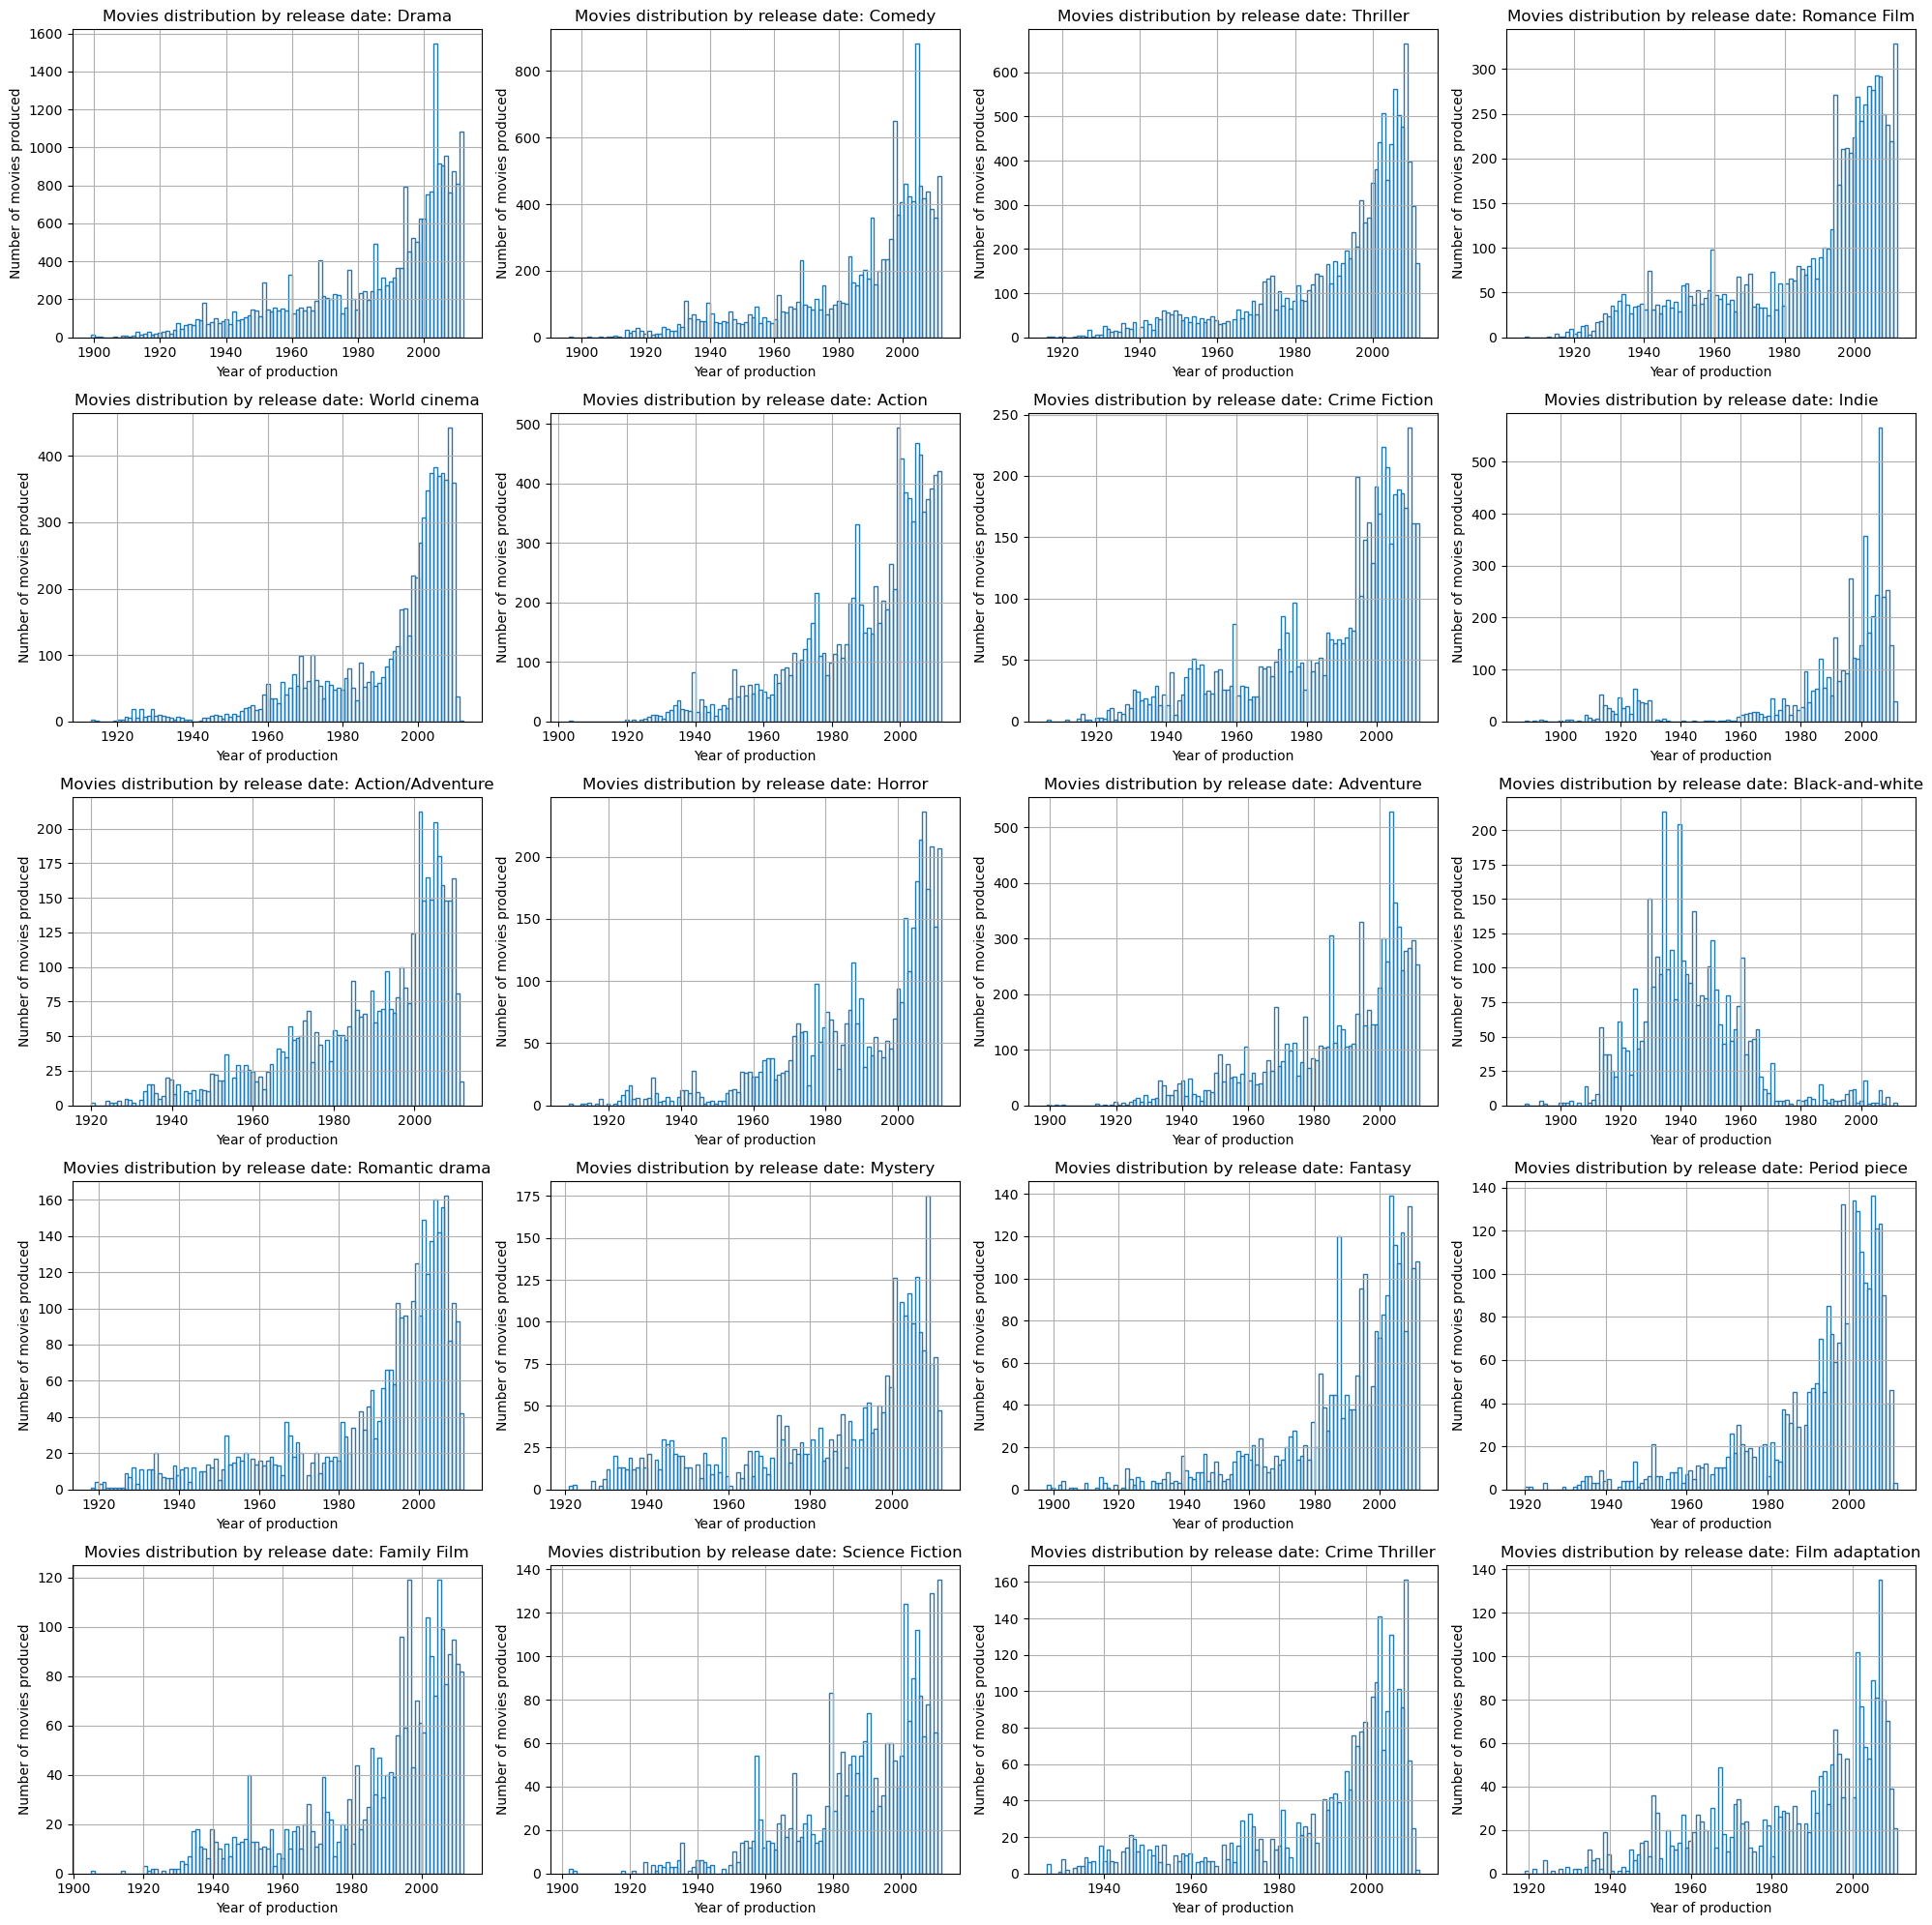

In [53]:
# number of rows and columns for subplots
n_rows = 5
n_cols = 4

# creating a grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

# looping over the top 20 genres
for i, genre in enumerate(top_genres[:20]):
    ax = axes[i]
    ax.set_title(f'Movies distribution by release date: {genre}')

    # genre filtering
    genre_movies = df_movies_tmdb_ratings[df_movies_tmdb_ratings['genres'].apply(lambda x: x is not None and genre in x)]
    style = {'facecolor': 'none', 'edgecolor': 'C0', 'linewidth': 1}

    # plotting the histogram for the current genre
    ax.hist(genre_movies['release_date'], bins=100, **style)

    # labels and limits
    ax.set_xlabel('Year of production')
    ax.set_ylabel('Number of movies produced')
    ax.grid(True)

plt.tight_layout()

Apart from the general increasing trend, probably also caused by the general increase in movies production over the last decades, some particular trends can be highlighted. For example, the indie genre seems to disappear between the 1940 and 1960. Adventure movies and drama movies present many peaks, that seem evenly paced at first glance. These observations can lead to further analysis.

Many meaningful themes for the analysis, for example the "Space exploration" theme, are not classified as genres. Thus, the plots are used to identify common words and create new genres that indicate the subject matter and theme of movies.

In [54]:
# counting space clusters entries occurances in 'plot_summary'
df_plots['space'] = df_plots['plot_summary'].apply(lambda x: cluster_search.col_search(x, cluster_space))

# setting a threshold
n_space = 3
df_plots_space = df_plots[df_plots['space'] > n_space]
df_plots = df_plots.drop(columns=['space'])

print('Number of movies that present the "Space exploration" theme: ', len(df_plots_space))

Number of movies that present the "Space exploration" theme:  198


The same reasoning can be applied to the "Communism" theme, meaningful for more historical related analysis. The cluster search tool will probably be used for other theme clusters which can be useful to deepen the overall analysis.

In [55]:
# counting communism clusters entries occurances in 'plot_summary'
df_plots['communism'] = df_plots['plot_summary'].apply(lambda x: cluster_search.col_search(x, cluster_communism))

# setting a threshold
n_communism = 2
df_plots_communism = df_plots[df_plots['communism'] > n_communism]
df_plots = df_plots.drop(columns=['communism'])

print('Number of movies that present the "Communism" theme: ', len(df_plots_communism))

Number of movies that present the "Communism" theme:  95


## Regional (Countries and Continents) Analysis

First, some basic analysis must be conducted. For example, knowing how many different countries are there in the dataframe column `countries` and which are the most common ones.

In [56]:
# printing the number of different countries
print('The number of different countries present in the dataframe is: ', len(df_movies_tmdb_ratings['countries'].unique()))

# printing the number of movies per genre
print('\n Number of movies per country:')
print(df_movies_tmdb_ratings_genres_filtered['countries'].value_counts())

# printing the 20 most popular countries
print('\n Number of movies per popular country:')
print(df_movies_tmdb_ratings_genres_filtered['countries'].value_counts().head(20))

The number of different countries present in the dataframe is:  132

 Number of movies per country:
countries
United States of America            48653
United Kingdom                      11595
France                               6658
Germany                              4558
Italy                                3452
                                    ...  
Bangladesh                              2
Jordan                                  2
Montenegro                              2
Qatar                                   1
Democratic Republic of the Congo        1
Name: count, Length: 132, dtype: int64

 Number of movies per popular country:
countries
United States of America    48653
United Kingdom              11595
France                       6658
Germany                      4558
Italy                        3452
Canada                       3429
Japan                        2941
India                        2421
Australia                    2042
Hong Kong                    1835

To keep the analysis clear and readable, only a subset of countries must be considered. The code below checks if a subset of the 20 most common countries is representative of the totality of the movies produced.

In [57]:
# choosing the number of common countries
n = 20

# selecting the n most common countries
countries_counts = df_movies_tmdb_ratings.groupby("countries").size()
countries_counts = countries_counts.sort_values(ascending=False)
countries_top = countries_counts.head(n)

top_countries_count = countries_top.sum()
all_countries_count = countries_counts.sum()

print(f"The 20 most common countries in the movies dataset account for {round(top_countries_count/all_countries_count * 100)}% of all movies produced.")

The 20 most common countries in the movies dataset account for 91% of all movies produced.


It can be concluded that the 20 most common countries account for the majority of the movies produced worldwide. Therefore, it may also suggest that some countries are culturally more prone to invest in the movies industry then other. Like it has been done for the genres, the distribution of movies produced in the 20 most common countries is plotted. 

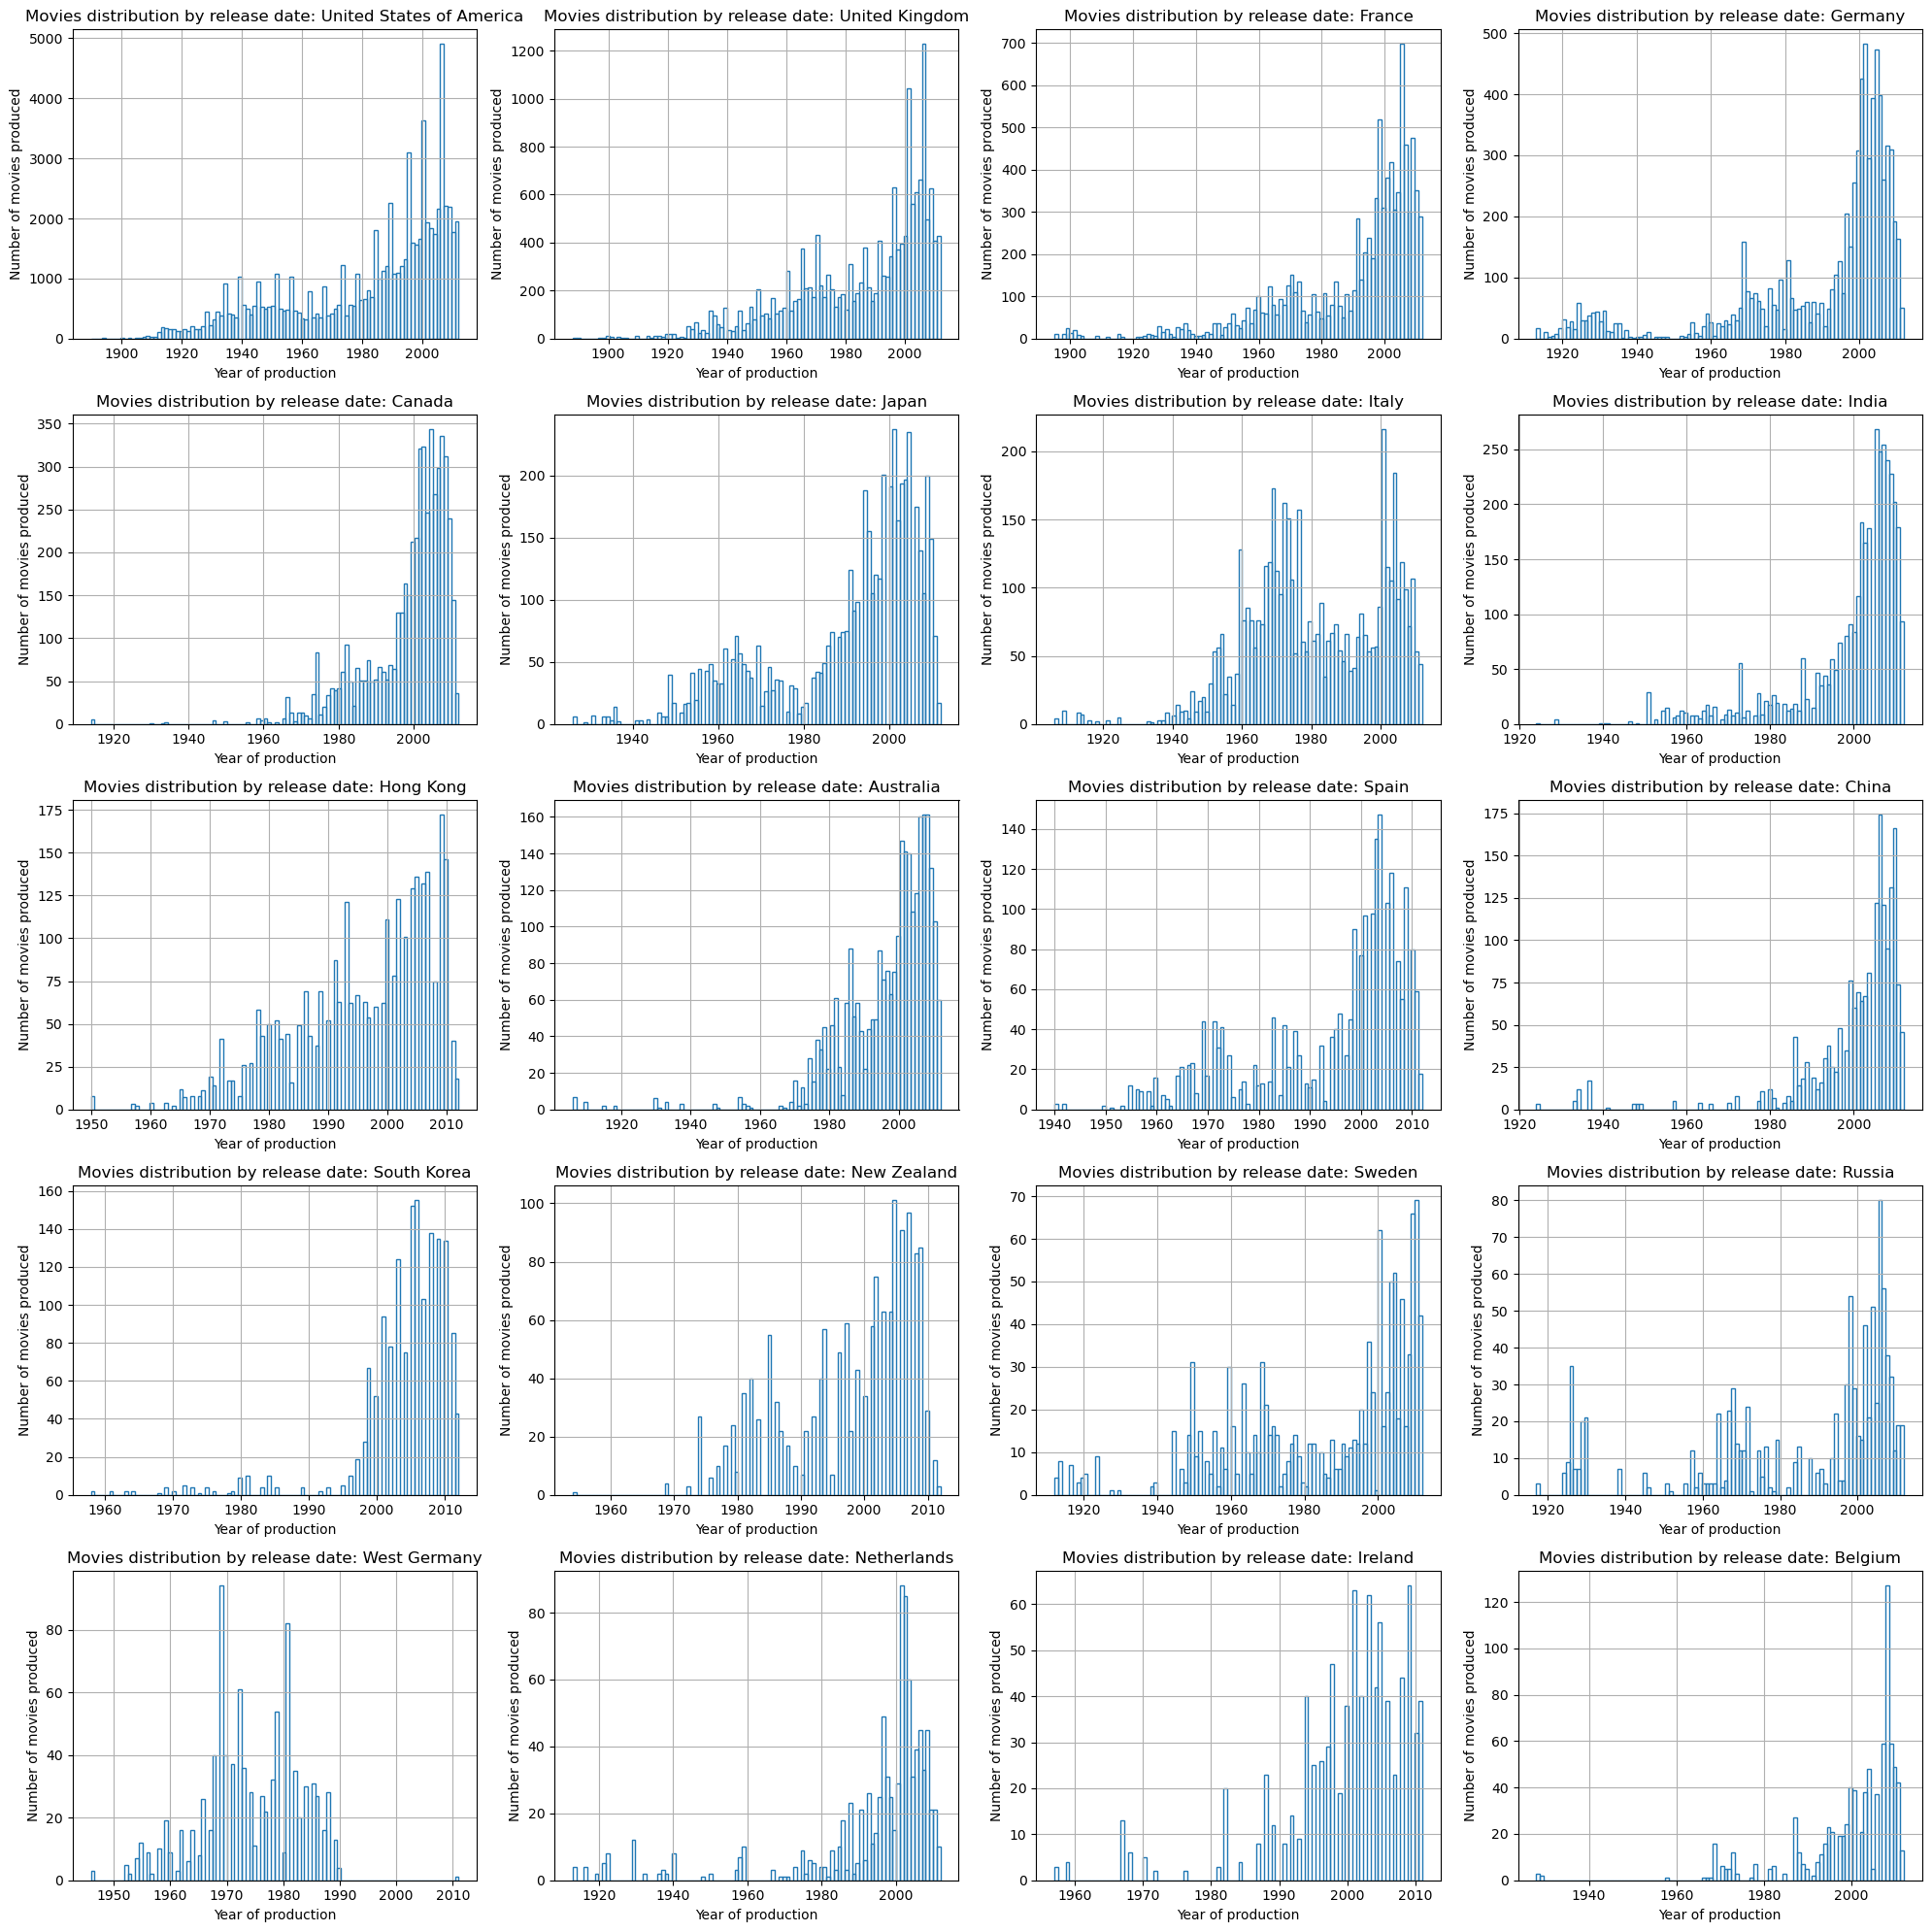

In [58]:
# number of rows and columns for subplots
n_rows = 5
n_cols = 4

top_countries = countries_top.index.tolist()

# Create a grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

# Loop over the top 20 genres
for i, country in enumerate(top_countries):
    ax = axes[i]
    ax.set_title(f'Movies distribution by release date: {country}')

    # Genre filtering
    country_movies = df_movies_tmdb_ratings[df_movies_tmdb_ratings['countries'].apply(lambda x: x is not None and country in x)]
    style = {'facecolor': 'none', 'edgecolor': 'C0', 'linewidth': 1}

    # Plot the histogram for the current country
    ax.hist(country_movies['release_date'], bins=100, **style)

    # Labels and limits
    ax.set_xlabel('Year of production')
    ax.set_ylabel('Number of movies produced')
    
    ax.grid(True)

plt.tight_layout()

From the above graphs, many conclusion can be drawn. The countries here considered are mostly European, even though the United States clearly dominate over the others. Almost the totality of countries see an increase, in time, in the number of movies produced. An exception is West Germany, since the division of Germany into an Eastern and Western part ended in 1989. On the other heand, many countries, like the Netherlands, Belgium or South Korea, developed their movie industry only in the last decades, from 1980.

## Continents Division

To compact the analysis, regional groupings are needed. Before choosing randomic groups of countries, the focus shifts to continents, to analyse movies distribution between different areas of the globe.

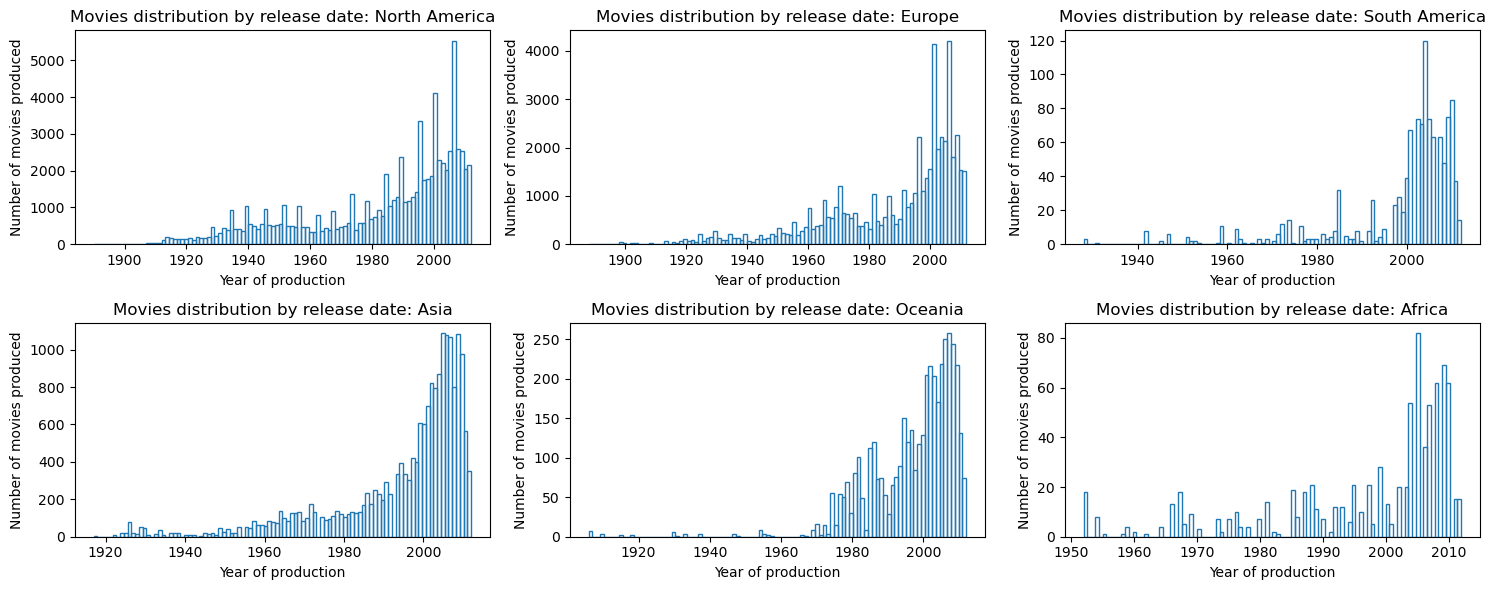

In [59]:
# number of rows and columns for subplots
n_cols = 3
n_rows = 2

top_countries = countries_top.index.tolist()

# creating a grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,6))
axes = axes.flatten()
for i, continent in enumerate(['North America', 'Europe', 'South America', 'Asia', 'Oceania', 'Africa']):
    ax = axes[i] 
    ax.set_title(f'Movies distribution by release date: {continent}')
    
    # continent filtering
    continent_movies = df_movies_tmdb_ratings[df_movies_tmdb_ratings['continent'].apply(lambda x: isinstance(x, str) and x == continent)]
    style = {'facecolor': 'none', 'edgecolor': 'C0', 'linewidth': 1}

    ax.hist(continent_movies['release_date'], bins = 100, **style)
    
    ax.set_xlabel('Year of production')
    ax.set_ylabel('Number of movies produced')

plt.tight_layout() 

From the plots above, some feature must be highlighted. For example, in North America movies production there are many peaks that look evenly paced, while Africa and South America present a net growth from the year 2000. To plot the evolution of the number of movies produced in each continent, the below graph is reported.

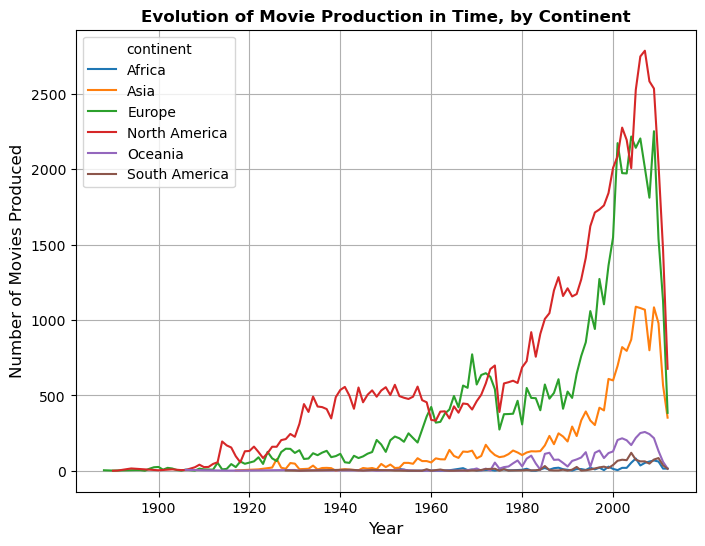

In [60]:
plt.figure(figsize=(8, 6))

# group by continent and year to count the number of movies produced
sns.lineplot(x="release_date", y="movie_count", hue="continent", data=df_movies_tmdb_ratings.groupby(['continent', 'release_date']).size().reset_index(name='movie_count'))
plt.title("Evolution of Movie Production in Time, by Continent", weight = 'bold')
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Movies Produced", fontsize=12)
plt.grid(True)

But what is the composition inside each continent? To answer this questions, some pie graphs are plotted, to undersand the weight of a specific country on the total number of movies produced in a continent. 

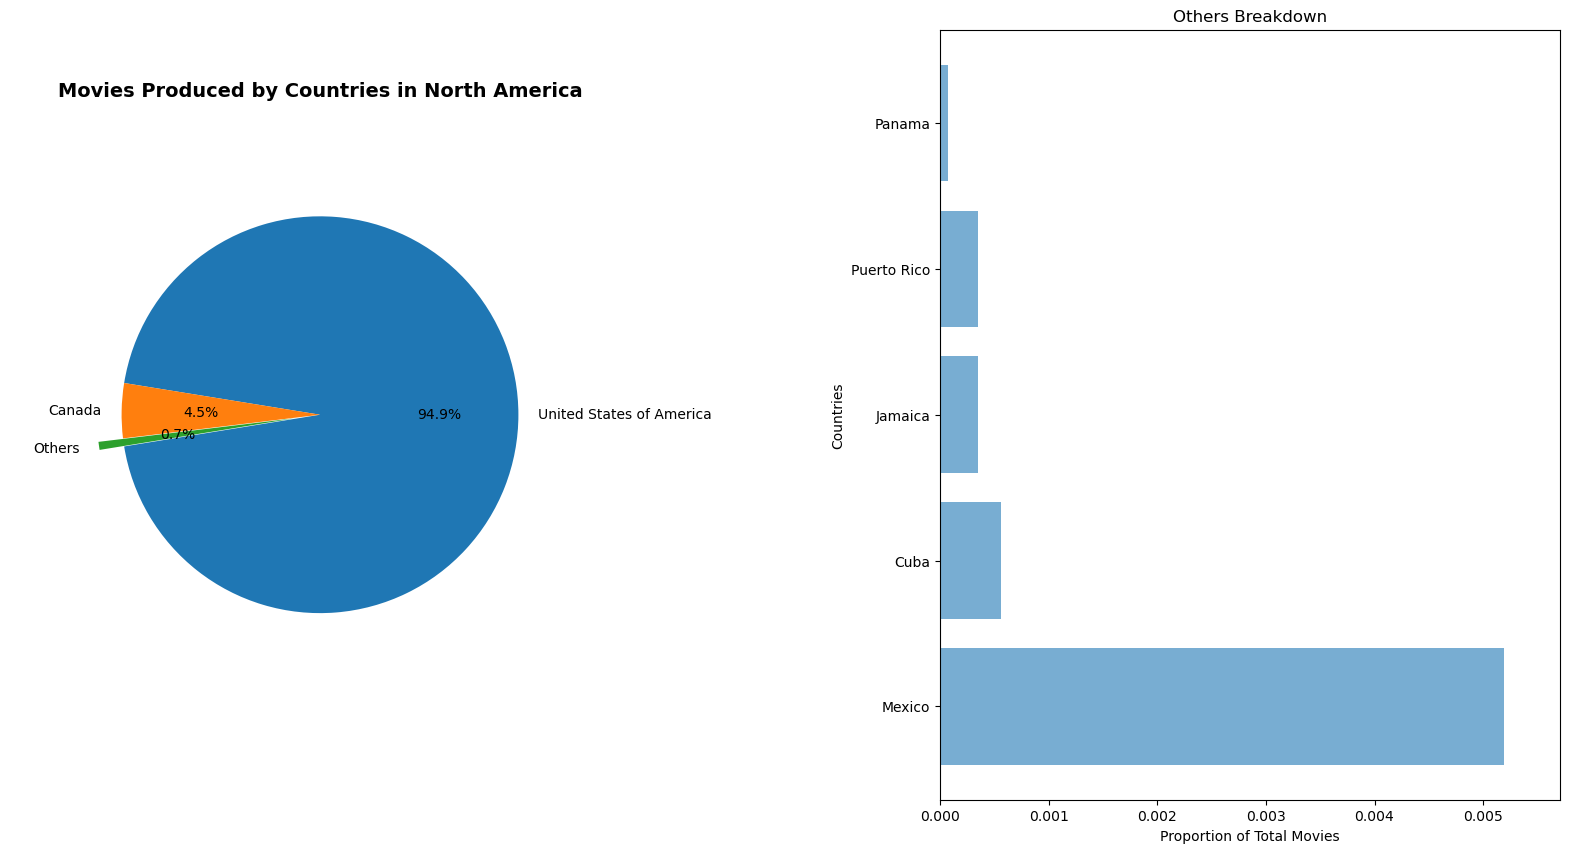

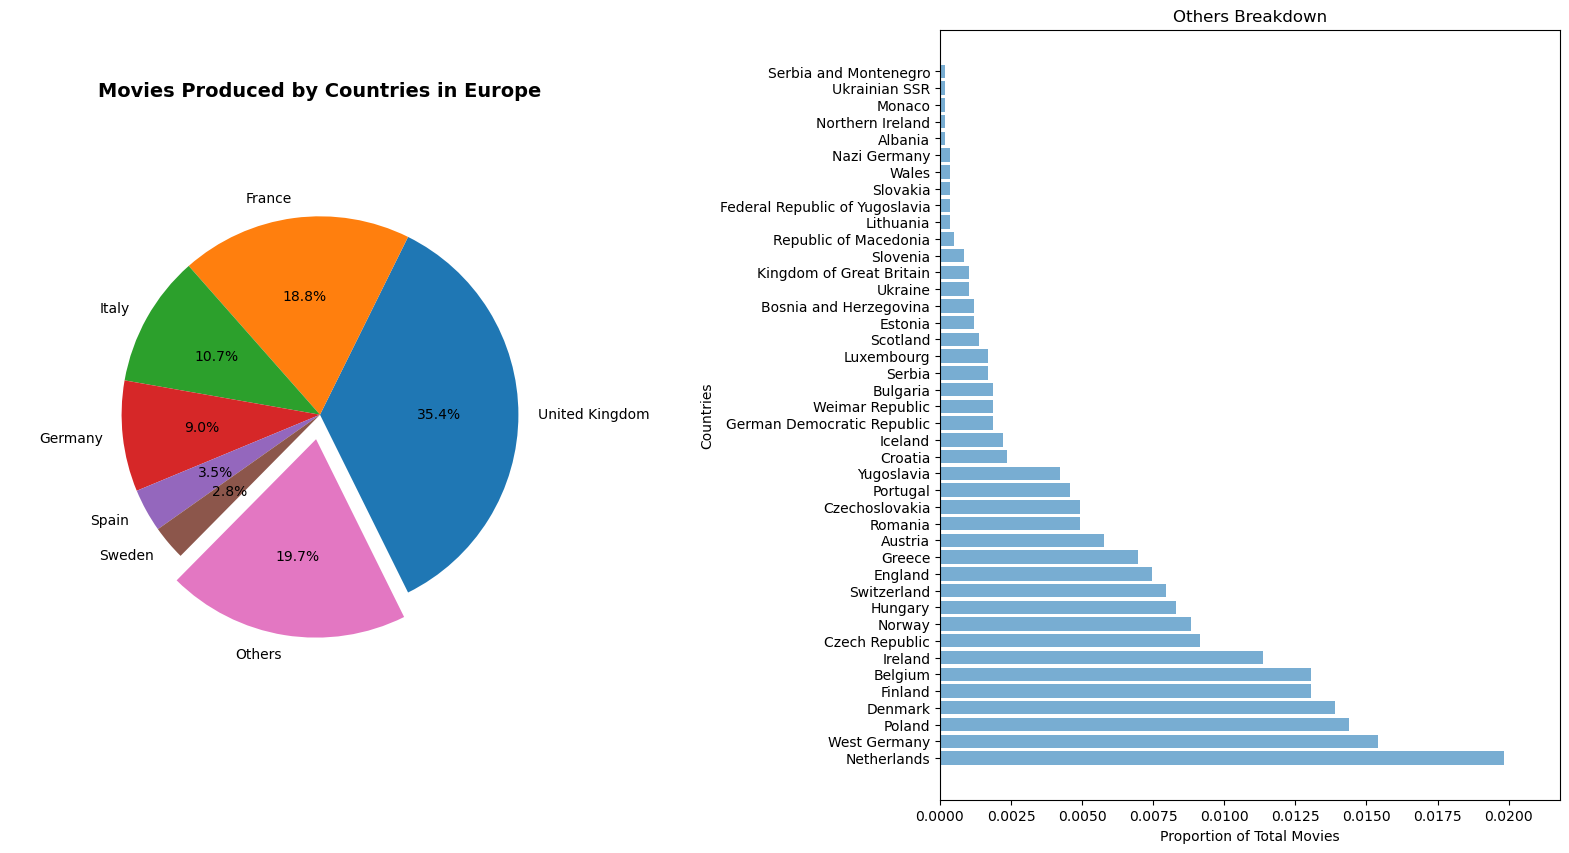

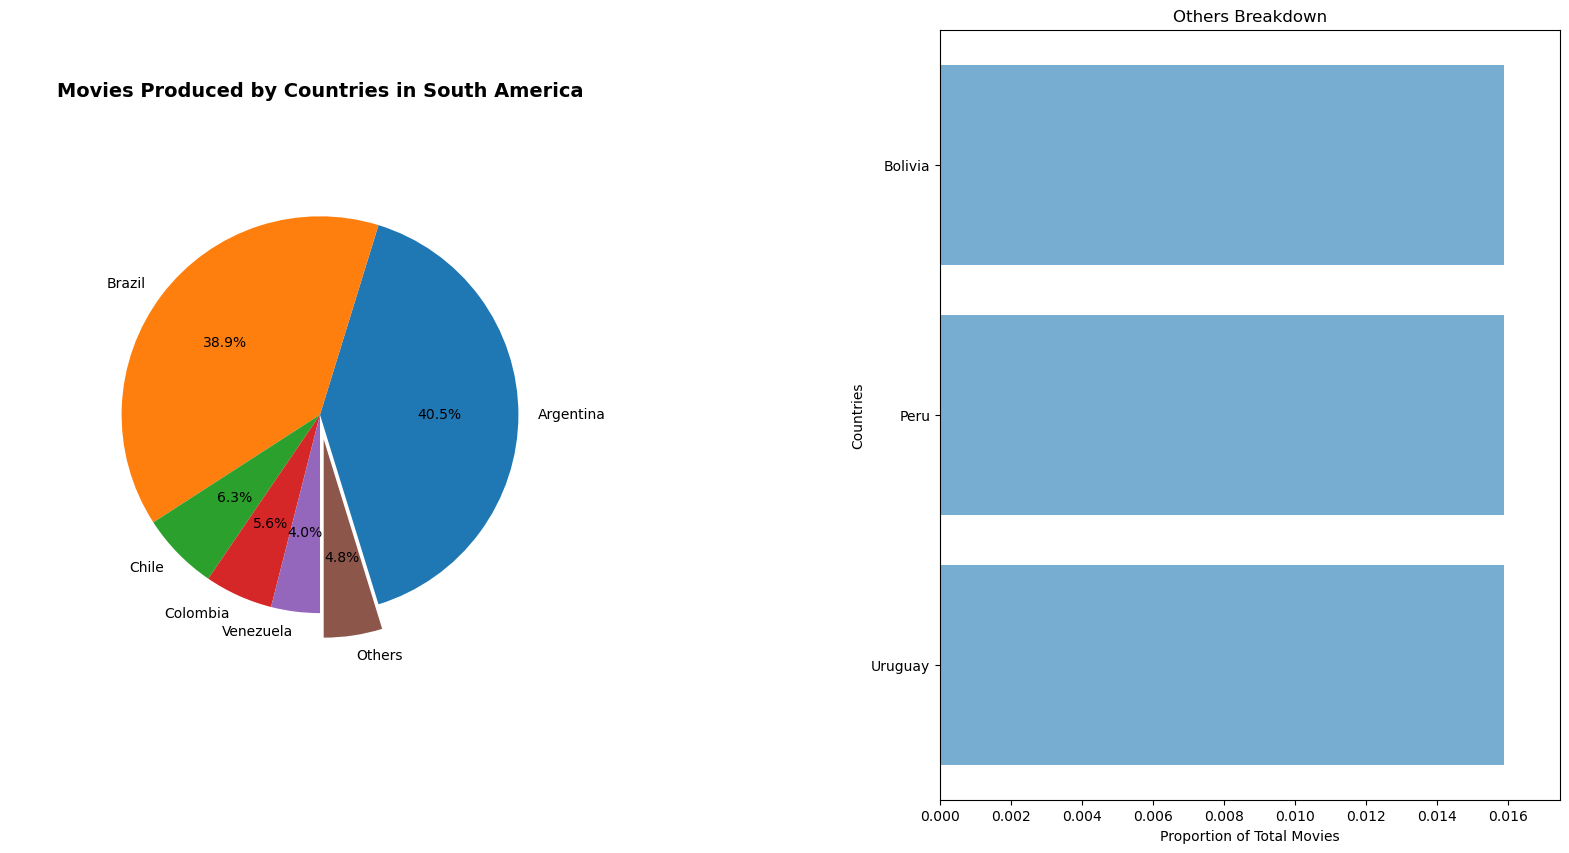

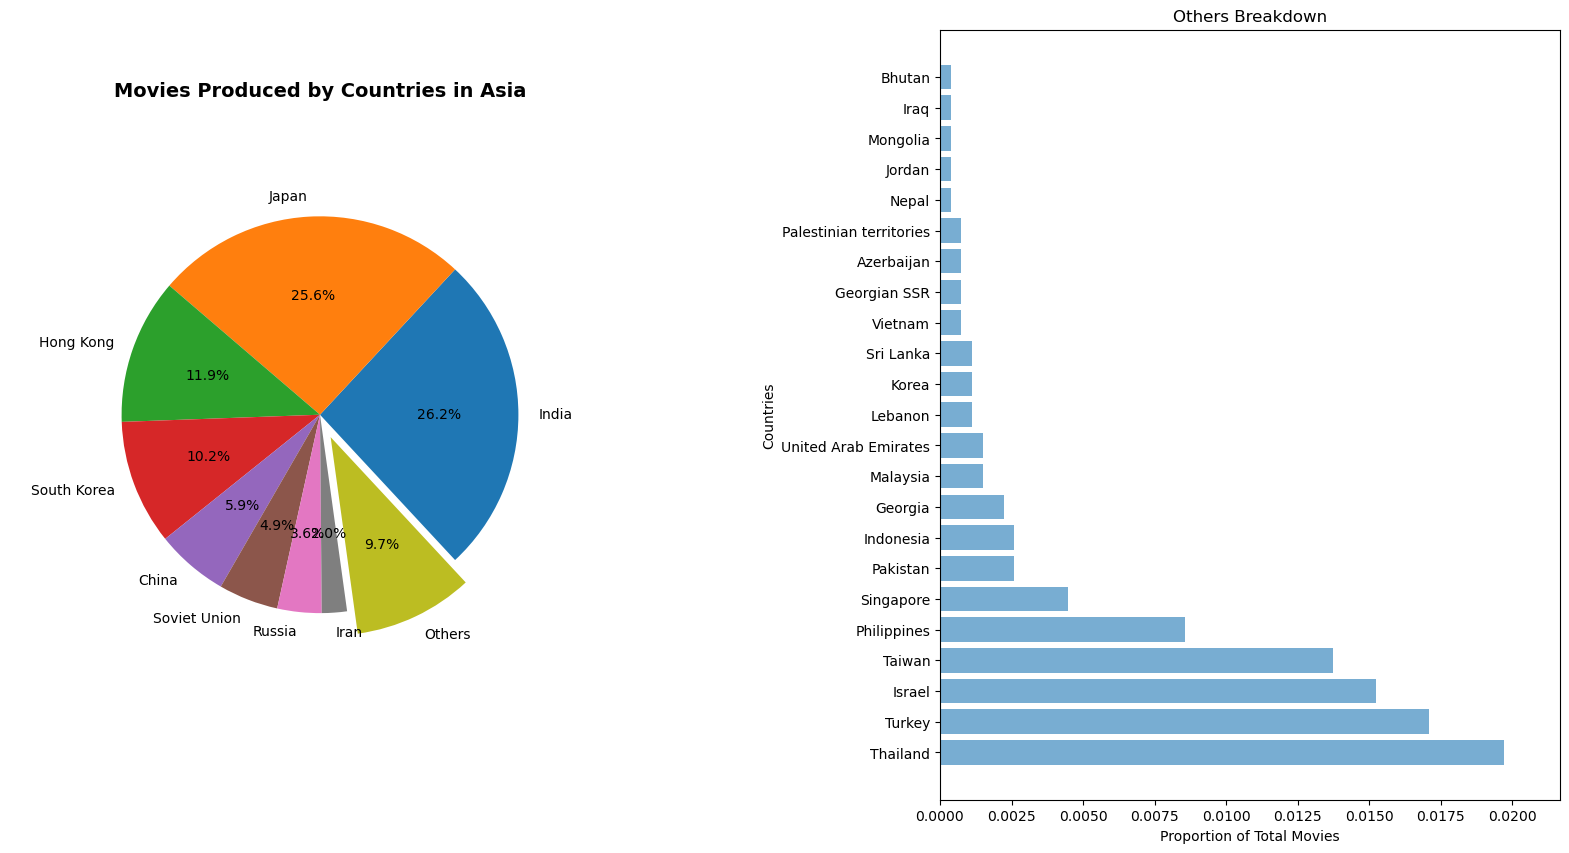

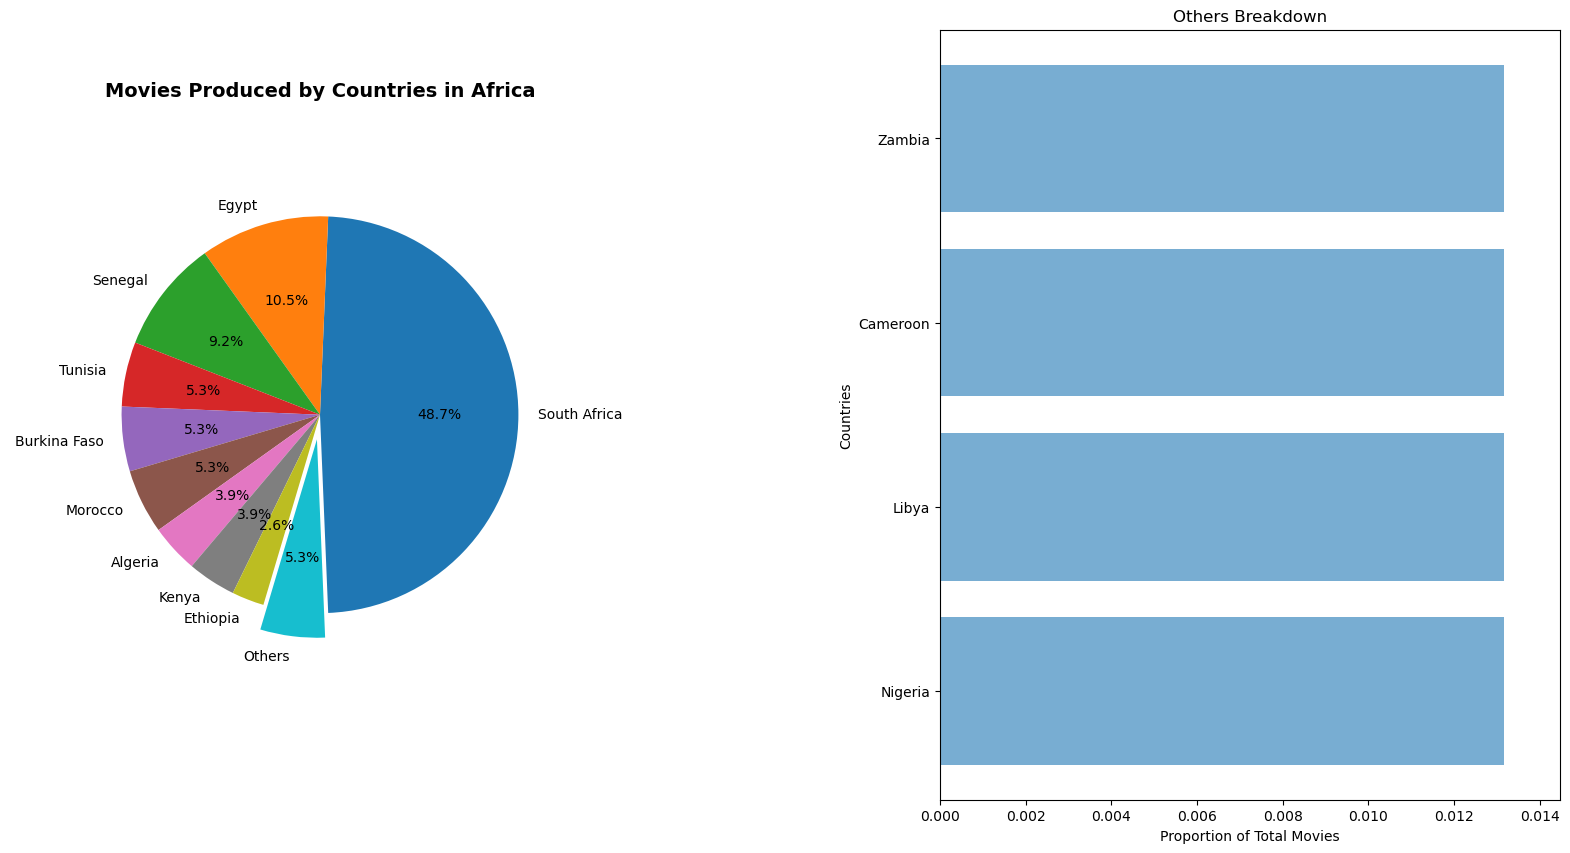

In [61]:
# since Oceania only contains New Zeland and Australia (no 'Others' slice)
# this continent is here not considered
continents = ['North America', 'Europe', 'South America', 'Asia', 'Africa']
threshold = 2

for continent in continents:
    # filtering and counting
    continent_movies = df_movies_tmdb_ratings_unique[df_movies_tmdb_ratings_unique['continent'] == continent]
    movie_counts = continent_movies['countries'].value_counts()
    total_movies = movie_counts.sum()

    # dividing into small and large slices
    small_slices = movie_counts[(movie_counts / total_movies) * 100 < threshold]
    large_slices = movie_counts[(movie_counts / total_movies) * 100 >= threshold]

    # creating the 'Others' category
    others_count = small_slices.sum()
    movie_counts_combined = pd.concat([large_slices, pd.Series(others_count, index=["Others"])])

    # calculating overall ratios
    overall_ratios = movie_counts_combined / total_movies
    labels = movie_counts_combined.index  
    explode = [0.1 if label == "Others" else 0 for label in labels]  # Esplodere la slice "Others"

    # 'Others' breakdown 
    others_breakdown = small_slices / total_movies 

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    fig.subplots_adjust(wspace=0.5)

    # pie chart
    angle = -180 * overall_ratios.iloc[0] if len(overall_ratios) > 0 else 0
    wedges, texts, autotexts = ax1.pie(overall_ratios, autopct='%1.1f%%', startangle=angle,
                                    labels=labels, explode=explode, radius=0.8)
    ax1.set_title(f'Movies Produced by Countries in {continent}', weight = 'bold', fontsize = 14)

    # bar chart to explain the 'Other' section
    ax2.barh(others_breakdown.index, others_breakdown, color='C0', alpha=0.6)
    ax2.set_title('Others Breakdown')
    ax2.set_xlim(0, max(others_breakdown) * 1.1 if len(others_breakdown) > 0 else 1)
    ax2.set_ylabel('Countries')
    ax2.set_xlabel('Proportion of Total Movies')

The pie graphs all present important differences. For example, the number of countries varies considerably in Europe and there are more balanced charts than unbalanced ones (North America). After this first analysis on continents, regions of interest can be identified to better model the data story. In any case, the continent analysis has been essential to understand hotspots in the worldwide movies distribution.

## Initial Genres/Continent Combined Analysis 

In the following code and graphs, a brief initial example of analysis combining genres and the regional aspect is presented. The genre 'War film' can be easily identified and it is probably related to world historical events. First, plot the distribution over release date.

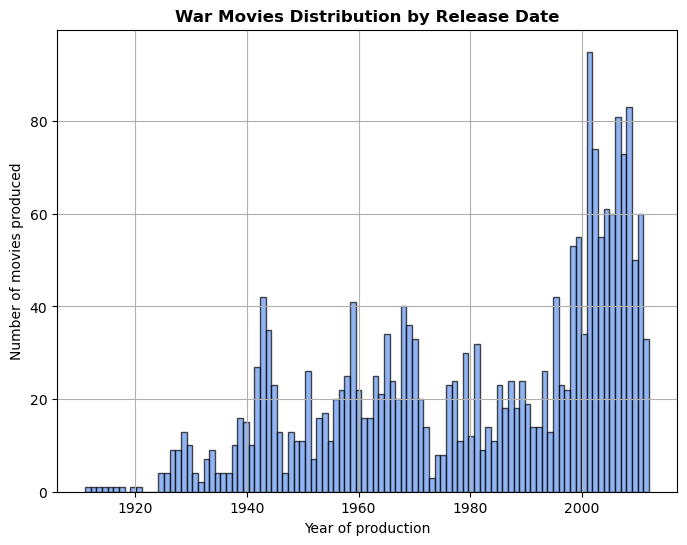

In [62]:
plt.figure(figsize=(8,6))
plt.title('War Movies Distribution by Release Date', weight = 'bold')

# extracting war movies
war_movies = df_movies_tmdb_ratings[df_movies_tmdb_ratings['genres'] == 'War film']
plt.hist(war_movies['release_date'], bins= 100, edgecolor='black', alpha=0.7, color='cornflowerblue')

plt.xlabel('Year of production')
plt.ylabel('Number of movies produced')
plt.grid(True)

The usual increase of movies after year 2000 appears. A particular feature of this graph is that, during WWII, the number of war films is larger than the number of war films produced immediately after that period. Another anomaly is present during the 70s, when almost no war films were produced worldwide (maybe reflecting the '68 effects). Now, it is interesting to plot which continents contributed more to the production of such genres.

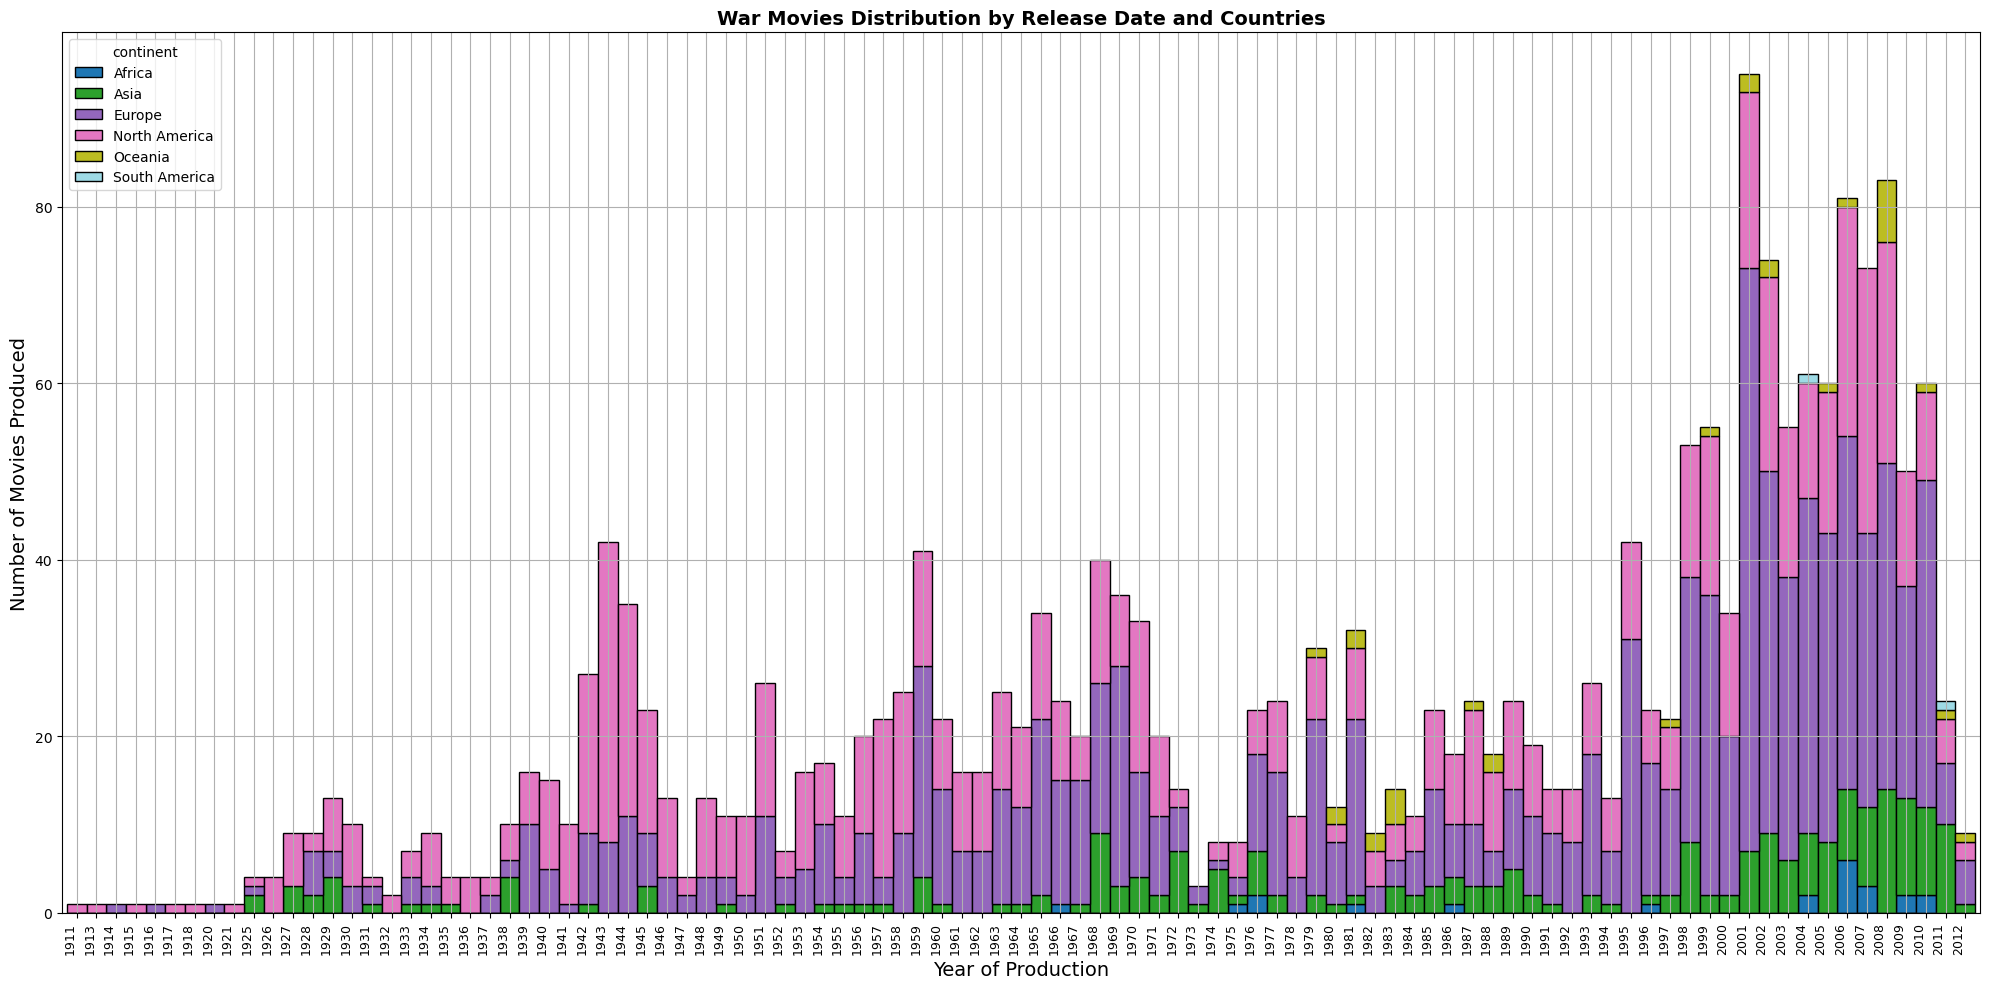

In [63]:
# grouping by continent
grouped_war_movies = war_movies.groupby(['release_date', 'continent']).size().unstack(fill_value=0)

# plotting stacked bar chart for grouped war movies
ax = grouped_war_movies.plot(kind='bar', stacked=True, figsize = (20, 10), colormap='tab20', width=1, edgecolor='black')
plt.title('War Movies Distribution by Release Date and Countries', weight = 'bold', fontsize = 14)

# ddjusting the x-ticks and labels
plt.xlabel('Year of Production', fontsize = 14)
plt.ylabel('Number of Movies Produced', fontsize = 14)
plt.xticks(rotation=90, ha="right", fontsize=9)

plt.tight_layout()
plt.grid(True)

As expected, the majority of these movies are produced in Europe or North America, which are the major movies producers worldwide. Even though Asia is also a big contributor, the war film genre does not seem the focus of its production. Analyzing the genre, it is known that the 'War film' genre can be combined with other multiple genres: this can highlight something more about the considered movie theme.

                   Genre  Frequency
3                  Drama       1972
10                Action        640
2           World cinema        567
29          Romance Film        488
14      Action/Adventure        460
..                   ...        ...
89  ['Historical drama']          1
90           ['History']          1
78      ['Romance Film']          1
93   ['Japanese Movies']          1
94            ['Comedy']          1

[95 rows x 2 columns]


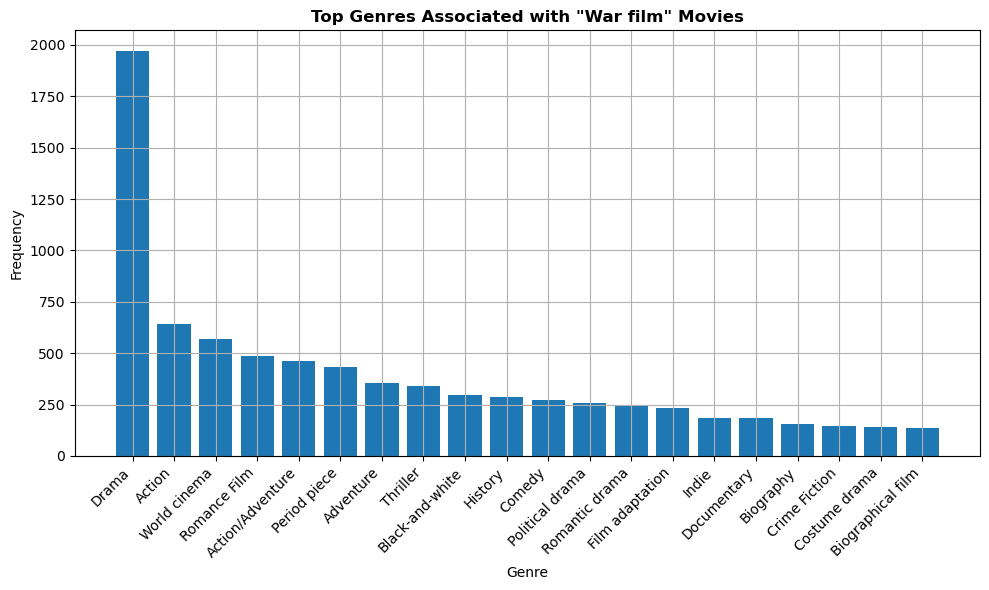

In [64]:
# since the dataframe contains one genres per row, titles are used to pair the War film movie to its other genres
# extracting titles
war_titles = war_movies['title'].unique()

# filter again, excluding the genre 'War film'
war_combined_genres = df_movies_tmdb_ratings[(df_movies_tmdb_ratings['title'].isin(war_titles)) & (df_movies_tmdb_ratings['genres'] != 'War film')]

# using the counter to count the frequency of other genres
war_combined_genres_counts = Counter(war_combined_genres['genres'])
df_war_combined_genres = pd.DataFrame(war_combined_genres_counts.items(), columns=['Genre', 'Frequency'])

# ordering by frequency
df_war_combined_genres = df_war_combined_genres.sort_values(by='Frequency', ascending=False)
print(df_war_combined_genres)

# showing the most common 20 genres
plt.figure(figsize=(10, 6))
plt.bar(df_war_combined_genres['Genre'][:20], df_war_combined_genres['Frequency'][:20])
plt.xticks(rotation=45, ha='right')
plt.title('Top Genres Associated with "War film" Movies', weight = 'bold')
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.tight_layout()
plt.grid(True)

It would be interesting to combine this analysis with ratings, to understand where this genre is most appreciated and if the general sentiment toward such a violent theme changes over time.

## Ratings Analysis

The analysis is heavily based on the `mean_rating` feature. To better understand its statistics, its description is displayed.

In [65]:
df_movies_tmdb_ratings_unique["mean_rating"].describe()

count    23432.000000
mean         3.086813
std          0.631714
min          0.500000
25%          2.750000
50%          3.164483
75%          3.500000
max          5.000000
Name: mean_rating, dtype: float64

The movie ratings found for part of the CMU dataset have a mean -- which it is reported owing to the above conclusion of the mean ratings being approximately normal -- of 3.15. The standard deviation is 0.6 and no ratings under 0.5 are observed, whereas perfect ratings are observed.

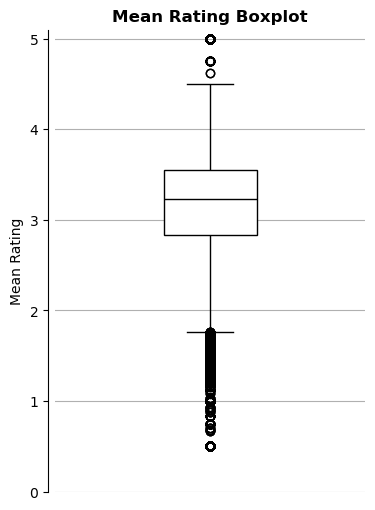

In [66]:
plt.figure(figsize=(4, 6))
ax = sns.boxplot(data=df_movies_tmdb_ratings['mean_rating'], color='white', linecolor='black', width=0.3)

# box-plotting the 'mean_rating' column
sns.despine(offset=5, trim=False, bottom=True)
plt.title('Mean Rating Boxplot', weight='bold')
plt.xticks([])
plt.ylim([0,5.1])
plt.ylabel("Mean Rating", fontsize=10)
plt.grid(True)

fig.tight_layout()

As expected, the movie ratings are approximately normally distributed with equivalent whisker sizes in the above boxplot and a median centered about at the centre of the IQR. Many outliers are observed, however we will not consider these as outliers given the data exists over a five point scale and no extreme values greatly drive skew in the movies ratings. The plot below provides further information on the mean movie ratings distribution. Ratings are again given in a range from 0 to 5.

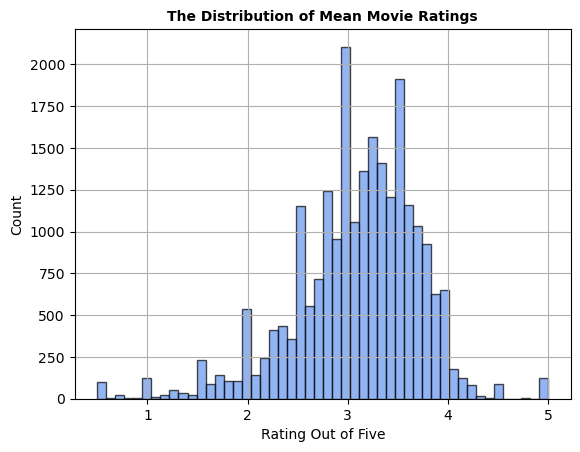

In [67]:
plt.hist(df_movies_tmdb_ratings_unique['mean_rating'].values, edgecolor='black', alpha=0.7, bins = 50, color='cornflowerblue')
plt.title("The Distribution of Mean Movie Ratings", weight='bold', fontsize=10)
plt.xlabel('Rating Out of Five', fontsize=10)
plt.ylabel("Count", fontsize=10)
plt.grid(True)

Since even through this visualization the distribution resembles a normal one, some test to verify this hypothesis are run below.

In [68]:
diagnostic.kstest_normal(df_movies_tmdb_ratings_unique['mean_rating'].values, dist = 'norm') 

(0.08968010179520697, 0.0009999999999998899)

Although the mean rating normality test returns a low p-value, visual inspections of the ratings distribution lead to a different conclusion. Therefore, a Q-Q plot is again employed to further assess normality.

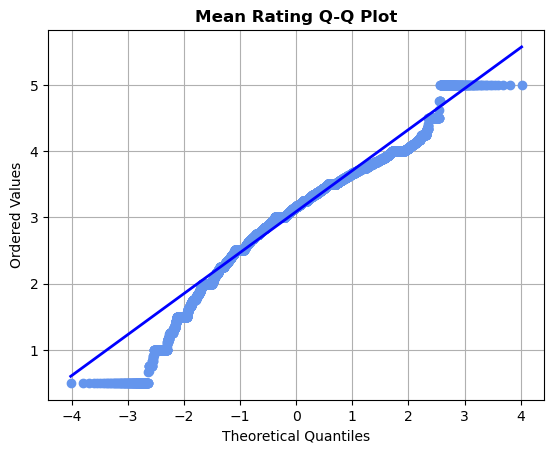

In [69]:
# ploting Q-Q test
fig, ax = plt.subplots()
res = stats.probplot(df_movies_tmdb_ratings_unique['mean_rating'].values, dist="norm", plot=ax)

# line settings
line = ax.get_lines()[0]
line_normal = ax.get_lines()[1]
line.set_color('cornflowerblue') 
line.set_linewidth(2)
line_normal.set_color('blue') 
line_normal.set_linewidth(2)

plt.title("Mean Rating Q-Q Plot", weight='bold')
plt.xlabel("Theoretical Quantiles", fontsize=10)
plt.ylabel("Ordered Values", fontsize=10)
plt.grid(True)

Given the central portion of the Q-Q plot is flatter and the edges steeper, we again conclude that mean ratings is approximately normally distributed but there are more datapoints aggregated about the mean than there would be in the case of a normal distribution.

Now, a closer look to genres preferences is presented. The objective is to visualize if the mean movie rating changes, based on the movie genre.

Text(50.72222222222221, 0.5, 'Genres')

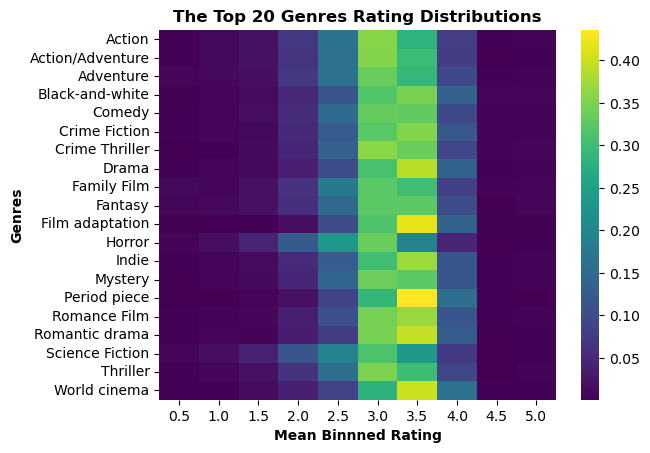

In [70]:
df_genres_meanratings = pd.crosstab(df_movies_tmdb_ratings_genres_filtered['genres'],df_movies_tmdb_ratings_genres_filtered['mean_rating_binned'], normalize='index')

# creating an heatmap among the top 20 genres
ax = plt.axes()
sns.heatmap(df_genres_meanratings, annot=False, cmap='viridis', ax = ax)

ax.set_title('The Top 20 Genres Rating Distributions', weight='bold')
ax.set_xlabel('Mean Binnned Rating', weight='bold')
ax.set_ylabel('Genres', weight='bold')

The top 20 genres reported in the CMU dataset all have approximately normal distributions with peaks (means) between the 3.0 and 3.5 rating bins, as expected given the population's mean rating of 3.15. Noticeably, horror and science fiction movies have comparatively stronger left-skews than the other main genres for ratings.

Since no evident movie genre preference has been found, other parameters are compared to the mean rating, to find correlations. For example, runtime and release date.

c:\Users\bosca\anaconda3\envs\ada\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


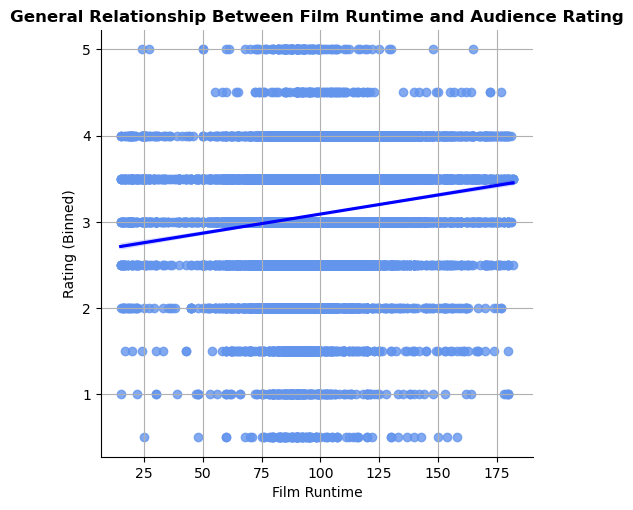

In [71]:
# starting by plotting the relationship between runtime and mean rating
runtime_binned_ratings = df_movies_tmdb_ratings_unique[['runtime','mean_rating_binned']]
sns.lmplot(x='runtime',y='mean_rating_binned', data=runtime_binned_ratings, scatter_kws={'color': 'cornflowerblue'}, line_kws={'color': 'blue'})
plt.xlabel("Film Runtime")
plt.ylabel("Rating (Binned)")
plt.title("General Relationship Between Film Runtime and Audience Rating", weight='bold')
plt.grid(True)
plt.show()

From the above graph, it can be concluded that there may be a relationship between runtime of a movie and the audience rating. Indeed, the linear regression segment has a positive coefficient. The above analysis performed over all regions and then across time worldwide and per region would give meaningful insights to understand regional movies preferences

The same plot has been computed to compare the rating and the release date.

c:\Users\bosca\anaconda3\envs\ada\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


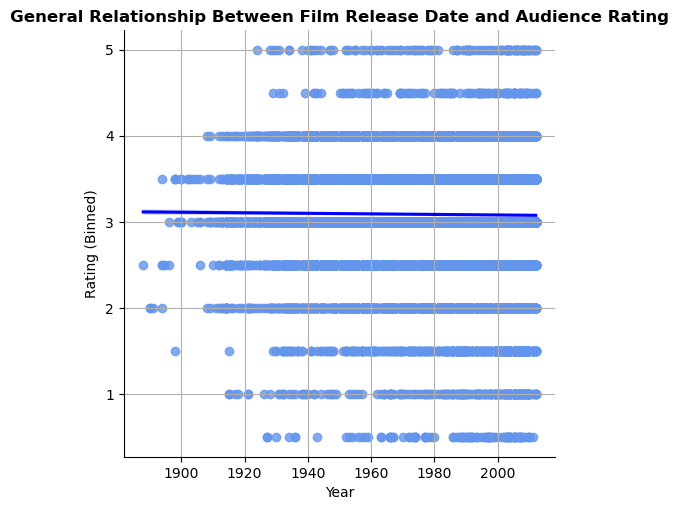

In [72]:
# plot the relationship between release date and mean rating
runtime_binned_ratings = df_movies_tmdb_ratings_unique[['release_date','mean_rating_binned']]
sns.lmplot(x='release_date',y='mean_rating_binned', data=runtime_binned_ratings, scatter_kws={'color': 'cornflowerblue'}, line_kws={'color': 'blue'})
plt.xlabel("Year")
plt.ylabel("Rating (Binned)")
plt.title("General Relationship Between Film Release Date and Audience Rating", weight='bold')
plt.grid(True)
plt.show()

The above plot leads us to suspect that regional trends of time's influence on movies ratings are required, given across all movies and all countries, a meaningless relation between the two features is observed. Additionally, time-based analysis will be required with more statistically-based methods, as demonstrated further below.

# Matching for causality

A meaningful possible analysis is comparing a given genre rating across two regions for causality analysis of country on rating. This analysis would need to be repeated per region pairing of interest, per genre of interest, across unique time subsets of the dataset based on decades/events of interest. In the example below, the focus is on thriller movies in the US vs in the UK.

First, the nature randomization matching method is used to study causality.

In [73]:
# identifying movies that have several entries but that differ in ratings
df_movies_ratings_unique = df_movies_tmdb_ratings.drop_duplicates(subset=["title", "mean_rating"]).copy()

# keeping only movies that have several ratings, replicating random experiment
recurrent_title = df_movies_ratings_unique["title"].value_counts() > 1
df_movies_ratings_unique = df_movies_ratings_unique[df_movies_ratings_unique["title"].isin(recurrent_title[recurrent_title].index)]

In [74]:
# thriller, US versus UK, all time
thriller_us = df_movies_ratings_unique[(df_movies_ratings_unique["genres"] == "Thriller") & (df_movies_ratings_unique["countries"] == "United States of America")]
thriller_uk = df_movies_ratings_unique[(df_movies_ratings_unique["genres"] == "Thriller") & (df_movies_ratings_unique["countries"] == "United Kingdom")]

print('The total number of thriller movies produced in the US is: ', len(thriller_us))
print('The total number of thriller movies produced in the UK is: ', len(thriller_uk))

The total number of thriller movies produced in the US is:  183
The total number of thriller movies produced in the UK is:  40


There are very few movies that are thrillers that were produced in the US and in the UK, all else being the same. Relying on nature randomization is not going to work for matching. Therefore, another method is used: propensity scoring. It consists in generating propensity scores based on release date and runtime, the only two real features of interest with genre held constant.

In [75]:
# comparing the ratings of thriller films in the US versus the UK
thriller_us_uk = pd.concat([thriller_us, thriller_uk])

# make the USA as a thrillers production country as the treatment
thriller_us_uk["countries"] = thriller_us_uk["countries"].apply(lambda x: x.replace("United Kingdom", "0"))
thriller_us_uk["countries"] = thriller_us_uk["countries"].apply(lambda x: x.replace("United States of America", "1"))
thriller_us_uk = thriller_us_uk.astype({'countries':'int'})

In [76]:
# generating propensity scores based on release date and runtime, the only two real features of interest with genre held constant
thriller_us_uk['release_date'] = (thriller_us_uk['release_date'] - thriller_us_uk['release_date'].mean())/thriller_us_uk['release_date'].std()

#thriller_us_uk['revenue'] = (thriller_us_uk['revenue'] - thriller_us_uk['revenue'].mean())/thriller_us_uk['revenue'].std()
thriller_us_uk['runtime'] = (thriller_us_uk['runtime'] - thriller_us_uk['runtime'].mean())/thriller_us_uk['runtime'].std()

mod = smf.logit(formula='countries ~  release_date + runtime' , data=thriller_us_uk)
res = mod.fit()
print(res.summary())

thriller_us_uk["Propensity_score"] = res.predict()

Optimization terminated successfully.
         Current function value: 0.454550
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              countries   No. Observations:                  223
Model:                          Logit   Df Residuals:                      220
Method:                           MLE   Df Model:                            2
Date:                Fri, 15 Nov 2024   Pseudo R-squ.:                 0.03378
Time:                        19:02:30   Log-Likelihood:                -101.36
converged:                       True   LL-Null:                       -104.91
Covariance Type:            nonrobust   LLR p-value:                   0.02891
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.5831      0.183      8.631      0.000       1.224       1.943
release_date     0.2751

Even though the R^2 value is low, some conclusions can be derived. An increase in release date by one standard deviation leads to a 0.13 log odds increase in a thriller being released in the US. An increase of one standard deviation in the runtime of a movie leads to a 0.11 log odds reduction in a movie being released in the US.

In [77]:
# matching US and UK thrillers based on propensity scores
def get_similarity(propensity_score1, propensity_score2):
    return 1-np.abs(propensity_score1-propensity_score2)

not_treated = thriller_us_uk[thriller_us_uk['countries'] == 0]
treated = thriller_us_uk[thriller_us_uk['countries'] == 1]

G = nx.Graph()

for control_id, control_row in not_treated.iterrows():
    for treatment_id, treatment_row in treated.iterrows():

        similarity = get_similarity(control_row['Propensity_score'],
                                    treatment_row['Propensity_score'])

        G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

matching = nx.max_weight_matching(G)

matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]

balanced_thriller_us_uk = thriller_us_uk.loc[matched]

With the two boxplots below runtime and release date are compared.

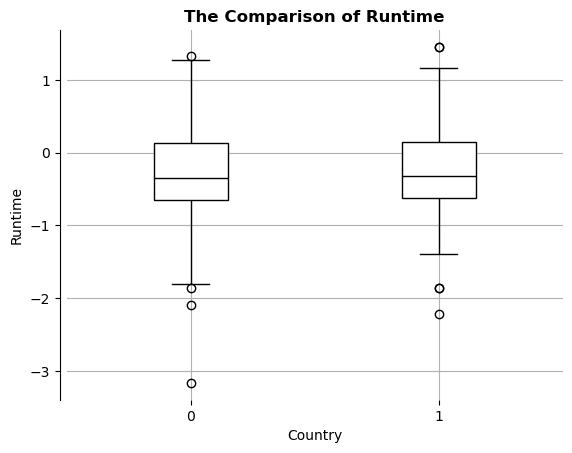

In [78]:
# assessing runtime balance in matched dataset
ax = sns.boxplot(x="countries", y="runtime", data=balanced_thriller_us_uk, color='white', linecolor='black', width=0.3)
sns.despine(offset=5, trim=False, bottom=True)

plt.xlabel("Country")
plt.ylabel("Runtime")
plt.title("The Comparison of Runtime", weight='bold')
plt.grid(True)

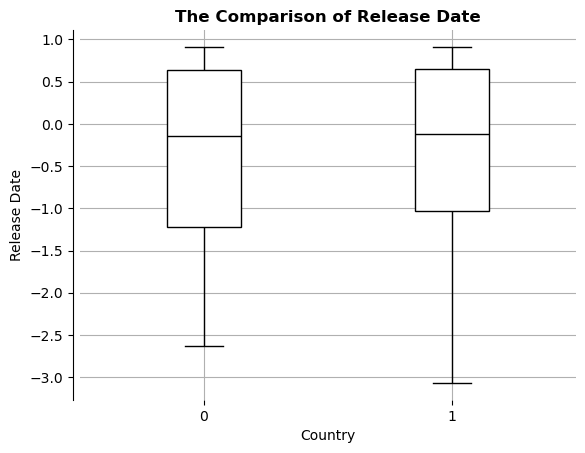

In [79]:
# assessing release date balance in matched dataset
ax = sns.boxplot(x="countries", y="release_date", data=balanced_thriller_us_uk, color='white', linecolor='black', width=0.3)
sns.despine(offset=5, trim=False, bottom=True)

plt.xlabel("Country")
plt.ylabel("Release Date")
plt.title("The Comparison of Release Date", weight='bold')
plt.grid(True)
plt.show()

count    40.000000
mean      2.932415
std       0.637632
min       1.000000
25%       2.571581
50%       3.000000
75%       3.500000
max       4.000000
Name: mean_rating, dtype: float64
count    40.000000
mean      3.069544
std       0.444495
min       2.166667
25%       2.750000
50%       3.040649
75%       3.442466
max       3.941967
Name: mean_rating, dtype: float64


Text(0.5, 1.0, 'The Comparison of Thriller Ratings Irrespective of Generation USA-UK')

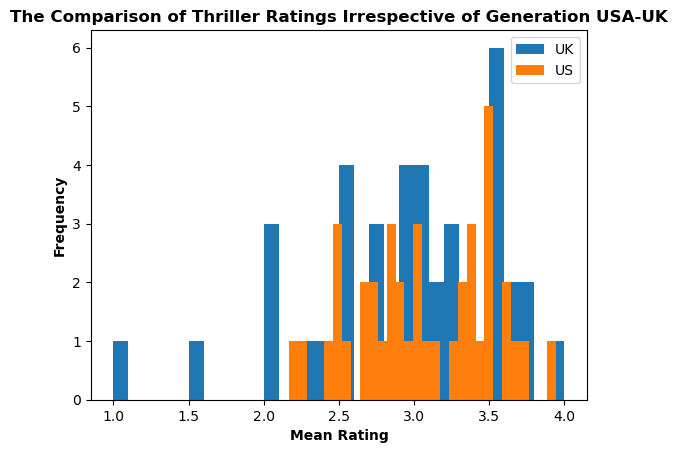

In [80]:
# comparing the mean rating of equivalent thrillers in the UK and US with all observed covariates removed from confounding country allocation
UK = balanced_thriller_us_uk[balanced_thriller_us_uk["countries"] == 0]
UK = UK["mean_rating"]

US = balanced_thriller_us_uk[balanced_thriller_us_uk["countries"] == 1]
US = US["mean_rating"]

print(UK.describe())
print(US.describe())

plt.hist(UK, bins=30, label = "UK")
plt.hist(US, bins=30, label = "US") 

plt.xlabel("Mean Rating", weight='bold')
plt.ylabel("Frequency", weight='bold')
plt.legend() 
plt.title("The Comparison of Thriller Ratings Irrespective of Generation USA-UK", weight='bold')

An over 0.1 rating difference is observed in the mean ratings between thriller films of similar observed covariates between such movies released in the US versus the UK. This presents an indication that country-level differences in genre ratings may not be indicative of regional causality on mean ratings, however, expanding such causality analysis across genres between countries will cover a greater scope of regional differences in ratings for a given genre.

## Continental differences in ratings

Now, ratings distribution in different countries are displayed and analysed.

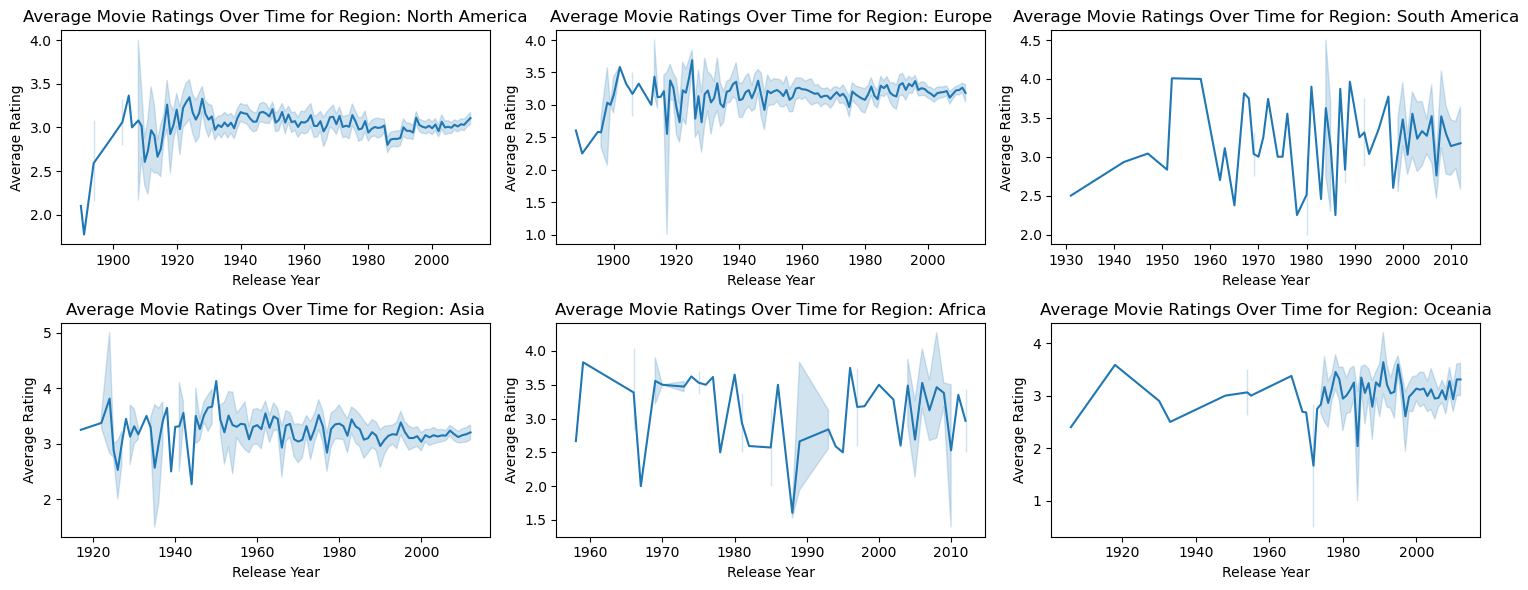

In [81]:
continents = ['North America', 'Europe', 'South America', 'Asia', 'Africa', 'Oceania']

# number of rows and columns for subplots
n_cols = 3
n_rows = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,6))
axes = axes.flatten()

for i, continent in enumerate(continents):
    ax = axes[i] 
    ax.set_title(f"Average Movie Ratings Over Time for Region: {continent}")
    
    # continent filtering
    continent_movies = df_movies_tmdb_ratings_unique[df_movies_tmdb_ratings_unique['continent'] == continent]

    sns.lineplot(data=continent_movies, x='release_date', y='mean_rating', ax=ax,  estimator='mean', color='C0')
    
    ax.set_xlabel('Release Year')
    ax.set_ylabel('Average Rating')

plt.tight_layout() 

From the above graphs, some irregularities can be seen, the plots are not smooth and the mean value is difficult to identify. Let's investigate the movie rating distribution within each continent.

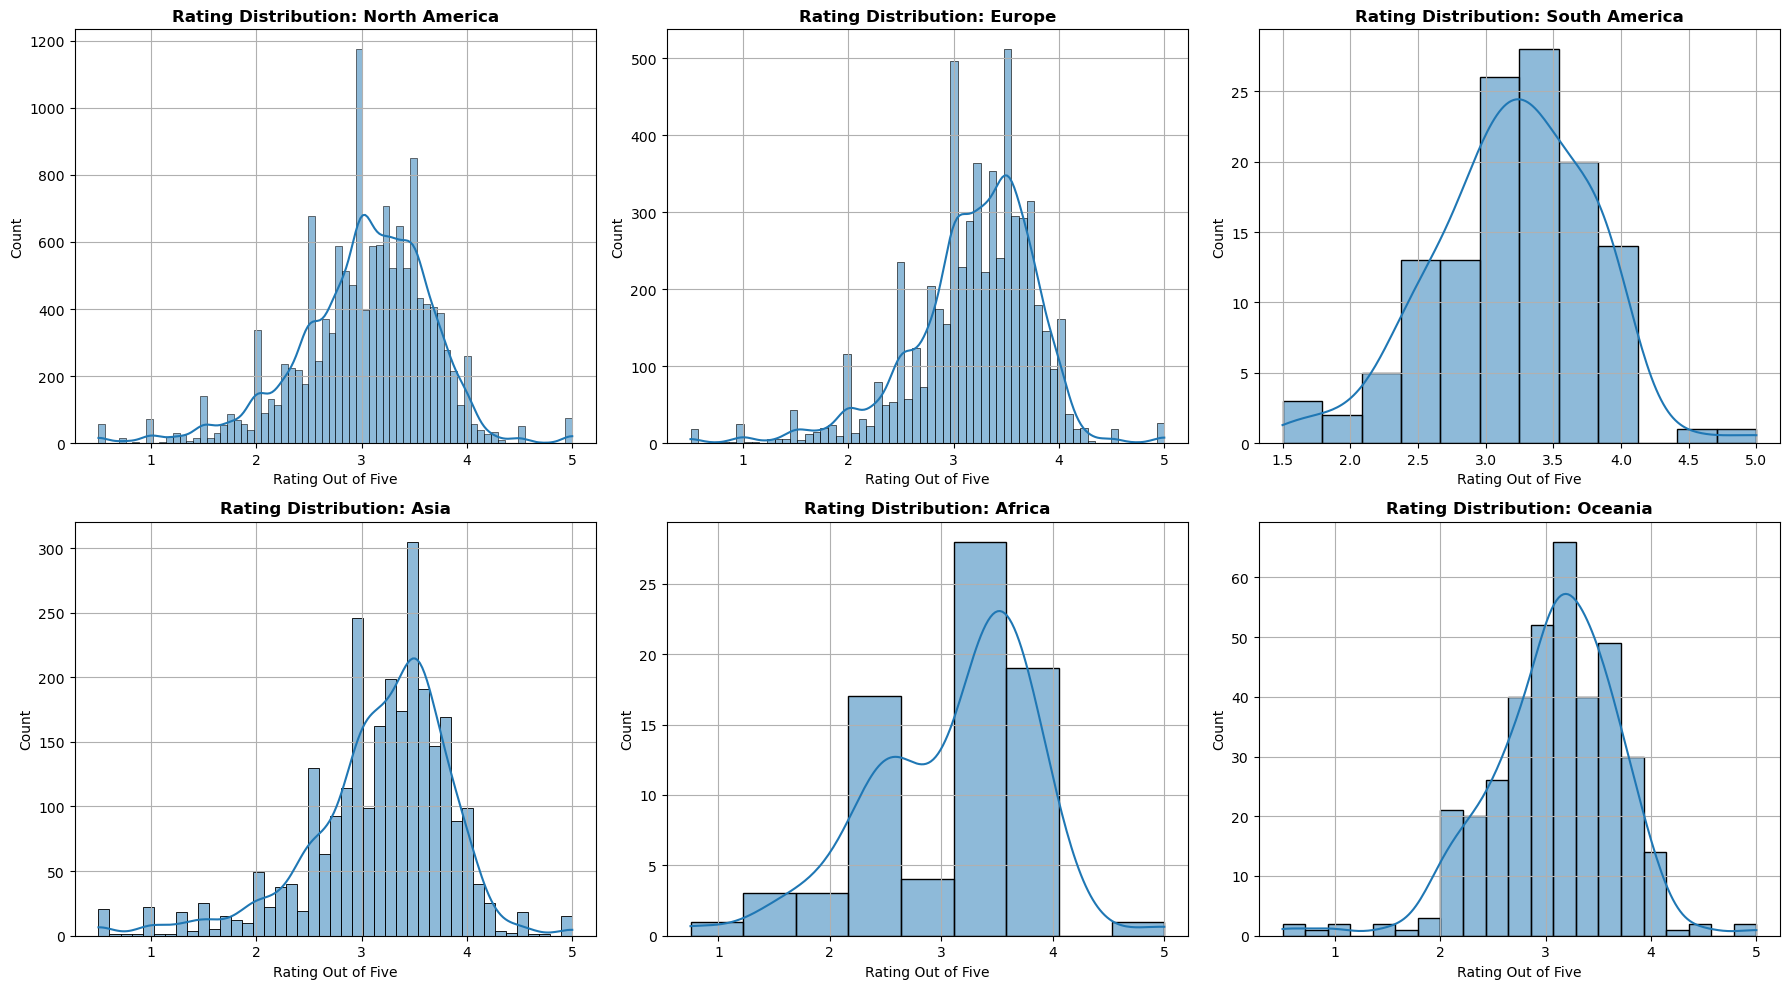

In [82]:
n_rows = 2
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 10))
axes = axes.flatten()

# for cycle to select continents
for i, continent in enumerate(continents):
    ax = axes[i]
    ax.set_title(f"Rating Distribution: {continent}", fontsize=12, weight='bold')
    
    # filtering by continent
    continent_movies = df_movies_tmdb_ratings_unique[df_movies_tmdb_ratings_unique['continent'] == continent]
    
    # plotting histograms
    sns.histplot(continent_movies['mean_rating'], kde=True, ax=ax)
    
    # setting the axes
    ax.set_xlabel('Rating Out of Five', fontsize=10)
    ax.set_ylabel('Count', fontsize=10)
    ax.grid(True)

plt.tight_layout()
plt.show()

From the above graphs, a normal distribution can be a realistic hypothesis for the distributions, and movies with Africa listed as their country of production nearly resemble a bimodal distribution for their ratings. Therefore, further tests on continent ratings are conducted.

In [83]:
# check for normality of ratings by region
for continent in continents:
    region_ratings = df_movies_tmdb_ratings_unique[df_movies_tmdb_ratings_unique['continent'] == continent]['mean_rating']
    p_value = stats.kstest(region_ratings, 'norm')[1]
    print(f"Normality test for {continent} ratings p-value: {p_value}")

Normality test for North America ratings p-value: 0.0
Normality test for Europe ratings p-value: 0.0
Normality test for South America ratings p-value: 2.9529760160040427e-168
Normality test for Asia ratings p-value: 0.0
Normality test for Africa ratings p-value: 2.442177184149584e-84
Normality test for Oceania ratings p-value: 0.0


The p-values for normality tests across all regions suggest a significant deviation from normality in the ratings data. Given the large sample size, even minor deviations from normality will yield significant results, which is why the p-values are extremely low.
Despite these deviations, QQ plots might reveal more detailed insights into specific distribution features such as skewness or heavy tails.

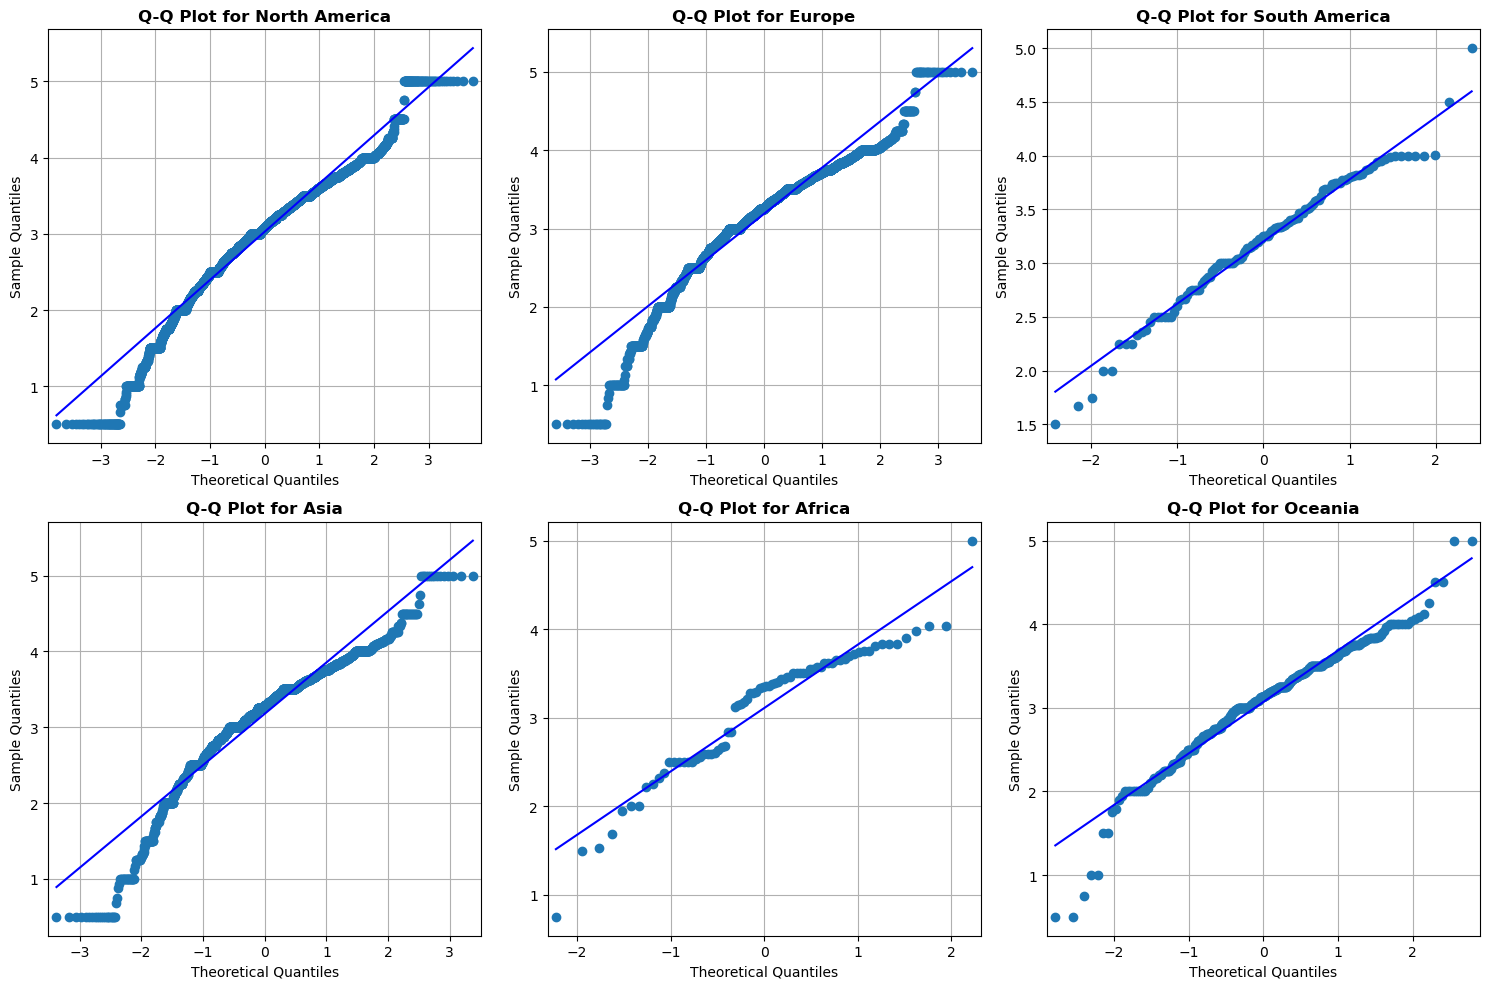

In [84]:
# setting up the layout for multiple Q-Q plots
plt.figure(figsize=(15, 10))
rows = (len(continents) + 2) // 3  

for i, continent in enumerate(continents, 1):
    plt.subplot(rows, 3, i)
    region_data = df_movies_tmdb_ratings_unique[df_movies_tmdb_ratings_unique['continent'] == continent]['mean_rating']
    
    # creating Q-Q plot
    sm.qqplot(region_data, line='s', ax=plt.gca())

    # change line color
    for line in plt.gca().lines:
        line.set_color('blue')

    plt.title(f'Q-Q Plot for {continent}', weight = 'bold')
    plt.grid(True)
    
plt.tight_layout()

We observe left skewness and spikes of identical values. To deepen the analysis, the means are compared, using the t-test to compare ratings between North America and Europe.

In [85]:
# comparing ratings between North America and Europe
na_ratings = df_movies_tmdb_ratings_unique[df_movies_tmdb_ratings_unique['continent'] == 'North America']['mean_rating']
eu_ratings = df_movies_tmdb_ratings_unique[df_movies_tmdb_ratings_unique['continent'] == 'Europe']['mean_rating']

# t-test
t_stat, p_value = stats.ttest_ind(na_ratings, eu_ratings)
print(f"T-test between North America and Europe ratings: t-stat = {t_stat}, p-value = {p_value}")

T-test between North America and Europe ratings: t-stat = -16.913064394393803, p-value = 9.917661469478254e-64


Results indicate a statistically significant difference in mean ratings between North America and Europe. To further investigate the difference in means, linear regression can be used, where the baseline will be `North America`.

In [86]:
# encoding region as a categorical variable
df_movies_tmdb_ratings['continent'] = pd.Categorical(df_movies_tmdb_ratings['continent'], categories=['North America'] 
                                                     + [cat for cat in df_movies_tmdb_ratings['continent'].unique() if cat != 'North America'])

# fitting the linear regression model
model = smf.ols('mean_rating ~ C(continent)', data=df_movies_tmdb_ratings)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:            mean_rating   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     522.2
Date:                Fri, 15 Nov 2024   Prob (F-statistic):               0.00
Time:                        19:02:41   Log-Likelihood:            -1.4123e+05
No. Observations:              156844   AIC:                         2.825e+05
Df Residuals:                  156838   BIC:                         2.825e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

The OLS regression model, using North America as the baseline region (so the intercept represents the average rating for North America), yields an R2 of **0.016**. This means that only **1.6%** of the variance in ratings is explained by region alone, indicating that region contributes minimally to rating differences. South America and Europe show the largest positive deviations from the North American baseline, with coefficients around **0.15-0.16**. This indicates that, on average, movies are rated approximately **0.15-0.16** points higher in these regions compared to North America. However, despite the low explained variance, the regional coefficients provide insights into small but statistically significant (p < 0.05) differences. To support these findings, the ANOVA test is adopted.

In [87]:
# ANOVA to compare mean ratings across multiple regions
rating_groups = [df_movies_tmdb_ratings_unique[df_movies_tmdb_ratings_unique['continent'] == continent]['mean_rating'] for continent in continents]

f_stat, p_value = stats.f_oneway(*rating_groups)
print(f"ANOVA across regions: F-stat = {f_stat}, p-value = {p_value}")


ANOVA across regions: F-stat = 69.7267256625982, p-value = 1.2176557628959613e-72


The ANOVA test results confirm that there are significant differences in mean ratings across different regions, supporting the findings from the t-test and regression.

## Prediction of mean ratings

With the code presented below, this analysis tries to find a meaningful way to predict the mean ratings, depending on other numerical attributes such as runtime, release date and revenue.

In [88]:
# calculate Pearson's correlation between mean_rating and runtime
corr_runtime, p_value_runtime = stats.pearsonr(df_movies_tmdb_ratings_unique['mean_rating'], df_movies_tmdb_ratings_unique['runtime'])
print(f"Pearson correlation between Ratings and Runtime: corr = {corr_runtime}, p-value = {p_value_runtime}")

# calculate Pearson's correlation between mean_rating and revenue
df_runtime_pearson = df_movies_tmdb_ratings_unique.dropna(subset=['revenue'])
corr_revenue, p_value_revenue = stats.pearsonr(df_runtime_pearson['mean_rating'], df_runtime_pearson['revenue'])
print(f"Pearson correlation between Ratings and Revenue: corr = {corr_revenue}, p-value = {p_value_revenue}")

# calculate Pearson's correlation between mean_rating and year
corr_revenue, p_value_release_date = stats.pearsonr(df_movies_tmdb_ratings_unique['mean_rating'], df_movies_tmdb_ratings_unique['release_date'])
print(f"Pearson correlation between Ratings and Release_date: corr = {corr_revenue}, p-value = {p_value_release_date}")

Pearson correlation between Ratings and Runtime: corr = 0.1537667813444049, p-value = 6.142134601766748e-124
Pearson correlation between Ratings and Revenue: corr = 0.08397163933973152, p-value = 3.9415547365143593e-16
Pearson correlation between Ratings and Release_date: corr = -0.009134501502670592, p-value = 0.16204709810278023


Pearson correlations reveal:
`Runtime` has a weak positive correlation with ratings (**r = 0.15**), indicating that longer movies tend to have slightly higher ratings. To calculate Pearsons coefficient, all missing values in the revenue column had to be dropped. Therefore, the result depends only on the movies that had an entry for revenue (40% of the movies).
`Revenue` shows an even weaker positive correlation with ratings (**r = 0.08**), suggesting higher-rated movies are associated with slight revenue increases. 
`Release Date` has a near-zero negative correlation with ratings (**r = -0.009**), implying no meaningful relationship.
These results confirm what was observed in previous regressions.

In [89]:
# linear Regression to predict ratings based on movie attributes
mod = smf.ols(formula='mean_rating ~ release_date + runtime + revenue', data=df_movies_ratings_unique)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            mean_rating   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     10.55
Date:                Fri, 15 Nov 2024   Prob (F-statistic):           6.98e-07
Time:                        19:02:41   Log-Likelihood:                -1756.2
No. Observations:                1951   AIC:                             3520.
Df Residuals:                    1947   BIC:                             3543.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        4.1893      1.261      3.322   

The model yields an R-squared of **0.016**, indicating that approximately **1.6%** of the variance in the average movie rating (mean_rating) is explained by the predictors—`release date`, `runtime`, and `revenue`. The low R-squared suggests that while these predictors have statistically significant effects, they do not account for much of the variance in ratings. These effects are the same that we found with Pearson correlation.

The predictors must be centered, by subtracting the mean.

In [90]:
# Center the predictors by subtracting the mean
df_movies_ratings_unique['release_date_centered'] = df_movies_ratings_unique['release_date'] - df_movies_ratings_unique['release_date'].mean()
df_movies_ratings_unique['runtime_centered'] = df_movies_ratings_unique['runtime'] - df_movies_ratings_unique['runtime'].mean()
df_movies_ratings_unique['revenue_centered'] = df_movies_ratings_unique['revenue'] - df_movies_ratings_unique['revenue'].mean()

# Now fit the model using the centered predictors
mod_centered = smf.ols(formula='mean_rating ~ release_date_centered + runtime_centered + revenue_centered', data=df_movies_ratings_unique)
res_centered = mod_centered.fit()

print(res_centered.summary())

                            OLS Regression Results                            
Dep. Variable:            mean_rating   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     10.55
Date:                Fri, 15 Nov 2024   Prob (F-statistic):           6.98e-07
Time:                        19:02:41   Log-Likelihood:                -1756.2
No. Observations:                1951   AIC:                             3520.
Df Residuals:                    1947   BIC:                             3543.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 3.14

By centering, the `intercept` in this model is **3.142**. By centering the predictors, this intercept now represents the expected mean rating when all predictor variables are at their respective means. This baseline is more interpretable in a real-world context compared to the uncentered model, as it reflects an average rating of **3.14** for movies with average release dates, runtimes, and revenues. Again, this result supports what has been observed before.

## Non-parametrical alternatives

To be sure of the obtained results, non-parametrical alternatives to the above tests can be used.

In [91]:
# non-parametric test: Mann-Whitney U test (alternative to T-test)
na_ratings = df_movies_ratings_unique[df_movies_ratings_unique['continent'] == 'North America']['mean_rating']
eu_ratings = df_movies_ratings_unique[df_movies_ratings_unique['continent'] == 'Europe']['mean_rating']

# Mann-Whitney U test
u_stat, p_value = stats.mannwhitneyu(na_ratings, eu_ratings)
print(f"Mann-Whitney U test between North America and Europe ratings: U-stat = {u_stat}, p-value = {p_value}")

# non-parametric test: Kruskal-Wallis H test (alternative to ANOVA)
regions = df_movies_ratings_unique['continent'].unique()
rating_groups = [df_movies_ratings_unique[df_movies_ratings_unique['continent'] == continent]['mean_rating'] for continent in continents]

# Kruskal-Wallis H test
h_stat, p_value = stats.kruskal(*rating_groups)
print(f"Kruskal-Wallis test across regions: H-stat = {h_stat}, p-value = {p_value}")

# Non-parametric test: Spearman's rank correlation (alternative to Pearson's correlation)

# calculating Spearman's rank correlation between mean_rating and runtime
corr_runtime, p_value_runtime = stats.spearmanr(df_movies_ratings_unique['mean_rating'], df_movies_ratings_unique['runtime'])
print(f"Spearman correlation between Ratings and Runtime: corr = {corr_runtime}, p-value = {p_value_runtime}")

# calculating Spearman's rank correlation between mean_rating and revenue
corr_revenue, p_value_revenue = stats.spearmanr(df_runtime_pearson['mean_rating'], df_runtime_pearson['revenue'])
print(f"Spearman correlation between Ratings and Revenue: corr = {corr_revenue}, p-value = {p_value_revenue}")

# calculating Spearman's rank correlation between mean_rating and release_date
corr_release_date, p_value_release_date = stats.spearmanr(df_movies_ratings_unique['mean_rating'], df_movies_ratings_unique['release_date'])
print(f"Spearman correlation between Ratings and Release_date: corr = {corr_release_date}, p-value = {p_value_release_date}")

Mann-Whitney U test between North America and Europe ratings: U-stat = 1529728.5, p-value = 0.0005164738889532848
Kruskal-Wallis test across regions: H-stat = 25.18957580050209, p-value = 0.00012806681108746147
Spearman correlation between Ratings and Runtime: corr = 0.11152685985695512, p-value = 1.0330942982067265e-13
Spearman correlation between Ratings and Revenue: corr = 0.034643388330050054, p-value = 0.0007980816784344814
Spearman correlation between Ratings and Release_date: corr = -0.01583353110015304, p-value = 0.2925476191367653


From these non-parametric tests the same conclusions can be drawn. By performing different statistical tests, all conclusions that have been derived are now confirmed.

## Box-Cox Transformation

The Box-Cox transformation was applied to stabilize variance and make the distribution closer to normal. This is adopted to see if the obtained results are similar or different from the already analysed ones.

Normality test for Box-Cox transformed ratings p-value: 7.092644860978096e-24


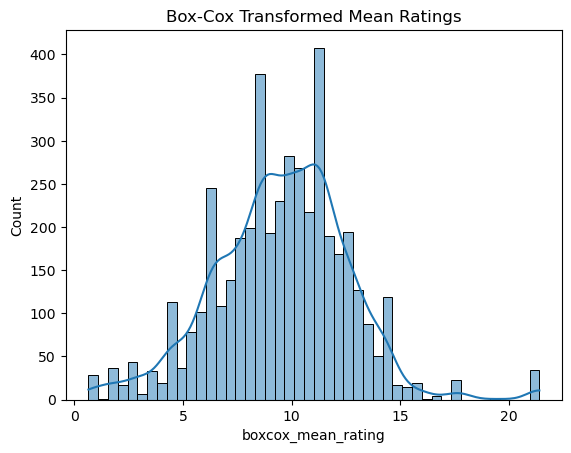

In [92]:
# box-Cox requires positive data, so ensure there are no zero or negative ratings
df_movies_ratings_unique['boxcox_mean_rating'], lambda_ = boxcox(df_movies_ratings_unique['mean_rating'] + 1)

# checking the distribution after Box-Cox transformation
sns.histplot(df_movies_ratings_unique['boxcox_mean_rating'], kde=True)
plt.title('Box-Cox Transformed Mean Ratings')

# performing a normality test on the transformed data
stat, p_value = stats.shapiro(df_movies_ratings_unique['boxcox_mean_rating'])
print(f"Normality test for Box-Cox transformed ratings p-value: {p_value}")

The Box-Cox Transformation distribution of ratings across continents is also considered, to observe the effect of the transformation on unique geographical regions' mean rating distributions.

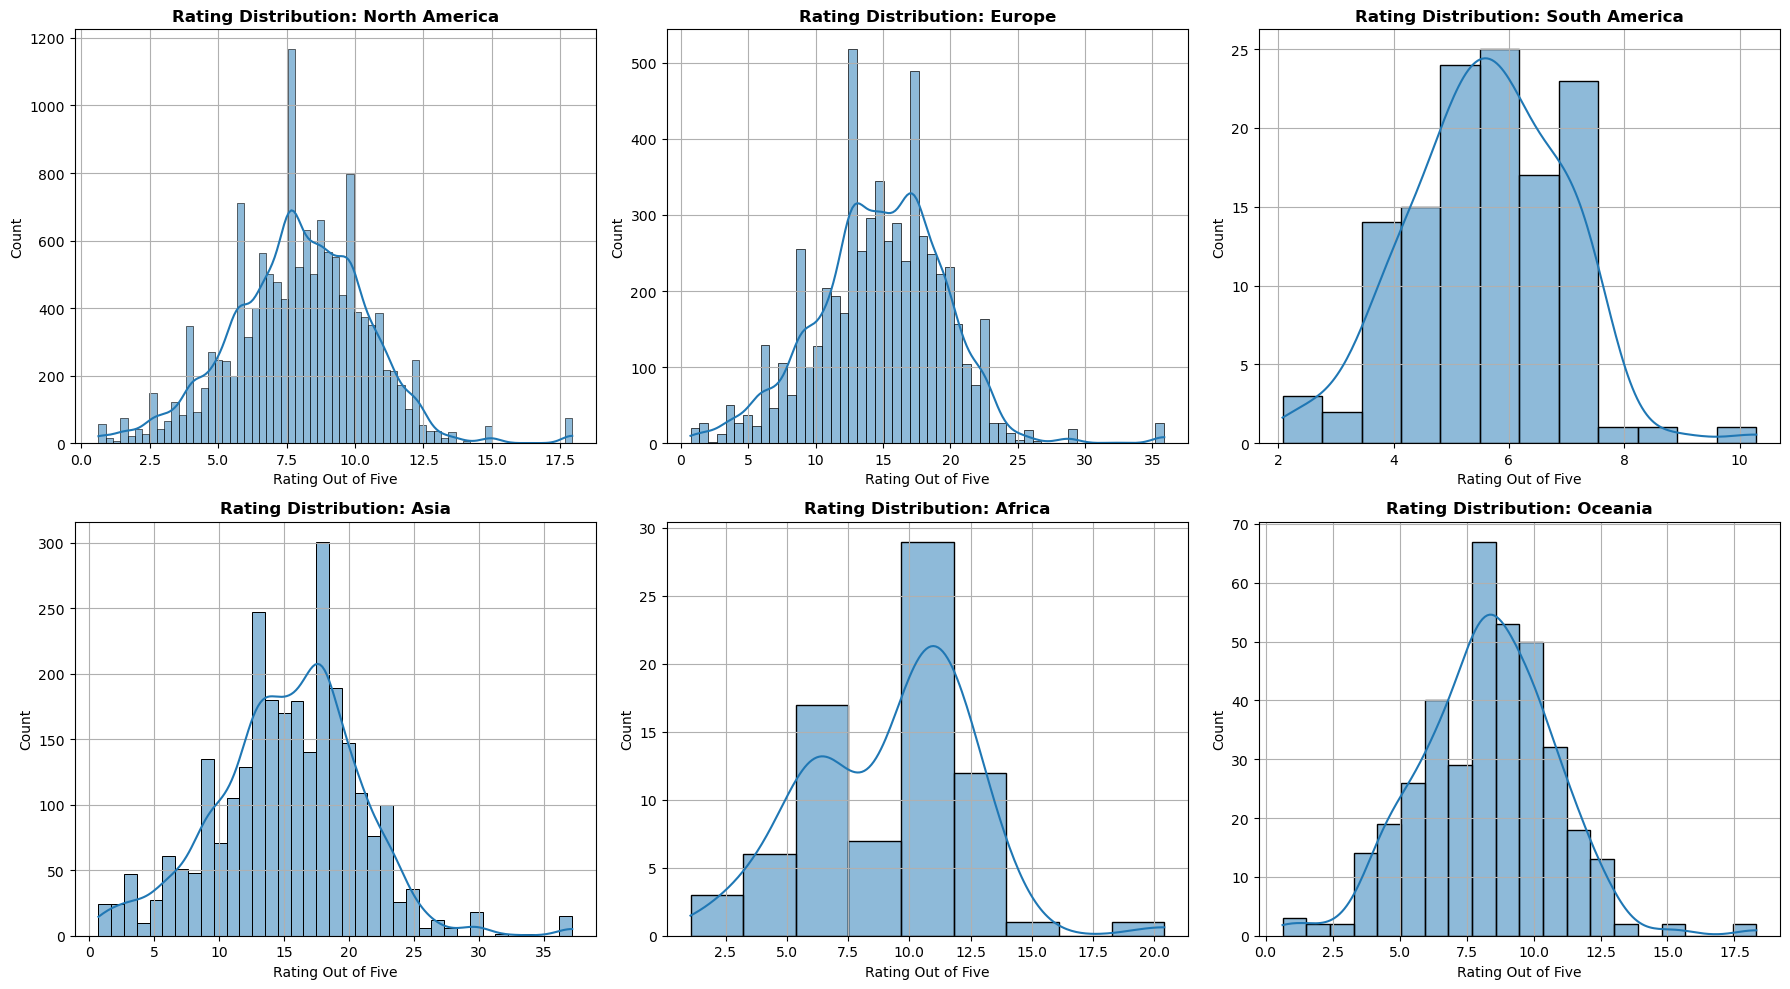

In [93]:
n_rows = 2
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 10))
axes = axes.flatten()

# main for cycle on continents
for i, continent in enumerate(continents):
    ax = axes[i]
    ax.set_title(f"Rating Distribution: {continent}", fontsize=12, weight='bold')
    
    # filtering by continent
    continent_movies = df_movies_tmdb_ratings_unique[df_movies_tmdb_ratings_unique['continent'] == continent].copy()

    # applying the box-cox transformation
    continent_movies['boxcox_mean_rating'], lambda_ = boxcox(continent_movies['mean_rating'] + 1)
    
    # plotting histograms
    sns.histplot(continent_movies['boxcox_mean_rating'], kde=True, ax=ax)
    
    # eetting the axes
    ax.set_xlabel('Rating Out of Five', fontsize=10)
    ax.set_ylabel('Count', fontsize=10)
    ax.grid(True)

plt.tight_layout()

Despite this transformation, normality tests still yield very low p-values across all regions, indicating statistical non-normality persists even after the transformation. South America seems to be the only promising resulting transformation.

In [94]:
# filtering data for Latin America region
la_data = df_runtime_pearson[df_runtime_pearson['continent'] == 'South America'].copy()

# ensuring there are no zero or negative values
la_data['mean_rating'] = la_data['mean_rating'] + 1

# applying box-cox transformation to the mean_rating column
la_data['boxcox_mean_rating'], lambda_ = boxcox(la_data['mean_rating'])

# defining independent and dependent variables
X = la_data[['revenue', 'release_date', 'runtime']] 
y = la_data['boxcox_mean_rating']  

# adding a constant to the model
X = sm.add_constant(X)

model = sm.OLS(y, X) 
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:     boxcox_mean_rating   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.040
Date:                Fri, 15 Nov 2024   Prob (F-statistic):              0.389
Time:                        19:02:43   Log-Likelihood:                -167.22
No. Observations:                  34   AIC:                             342.4
Df Residuals:                      30   BIC:                             348.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          366.7079    745.108      0.492   

In this Box-Cox-transformed model, `runtime` appears as a significant positive predictor of movie ratings in South America, while `revenue` and `release date` show weaker or non-significant associations. The model explains a modest amount of variance (see R2), and further investigation may be needed to explore other variables that could better explain variations in movie ratings for this region.

# Time series analysis

This section aims at exploring the possibility of time related trends in ratings over time.

In [95]:
region_time_series = df_movies_ratings_unique.groupby(['release_date', 'continent'])['mean_rating'].mean().reset_index()
region_time_series = region_time_series.dropna(subset=['mean_rating'])

# checking the difference between consecutive release dates for each region
for continent in continents:
    region_data = region_time_series[region_time_series['continent'] == continent].sort_values(by='release_date')
    date_diff = region_data['release_date'].diff().dropna()
    print(f"Gaps for {continent}:")
    print(date_diff.describe())  


Gaps for North America:
count    103.000000
mean       1.009709
std        0.098533
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: release_date, dtype: float64
Gaps for Europe:
count    97.000000
mean      1.175258
std       0.692374
min       1.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       7.000000
Name: release_date, dtype: float64
Gaps for South America:
count    15.00000
mean      2.60000
std       2.22967
min       1.00000
25%       1.00000
50%       1.00000
75%       4.00000
max       7.00000
Name: release_date, dtype: float64
Gaps for Asia:
count    63.000000
mean      1.365079
std       1.261100
min       1.000000
25%       1.000000
50%       1.000000
75%       1.000000
max      10.000000
Name: release_date, dtype: float64
Gaps for Africa:
count    13.000000
mean      3.538462
std       3.306947
min       1.000000
25%       1.000000
50%       2.000000
75%       4.000000
max      12.000000
Nam

The gaps are minimal for `North America`, this is why we will preferably do the analysis on this continent.

In [96]:
# conducting ADF test for each region, ordered by release_date
regions = region_time_series['continent'].unique()
adf_results = {}

for continent in continents:
    # filtering and sort by release_date to maintain time order
    region_data = region_time_series[region_time_series['continent'] == continent].sort_values(by='release_date')['mean_rating']
    adf_result = adfuller(region_data)
    p_value = adf_result[1]
    adf_results[continent] = p_value
    print(f"ADF Test for {continent} - p-value: {p_value}")


ADF Test for North America - p-value: 0.021727239483654803
ADF Test for Europe - p-value: 7.664017444011976e-15
ADF Test for South America - p-value: 0.3385030486514418
ADF Test for Asia - p-value: 6.747781502000962e-16
ADF Test for Africa - p-value: 0.0
ADF Test for Oceania - p-value: 2.0179706760954513e-08


Augmented Dickey-Fuller tests show low p-values for all regions, suggesting that the ratings are stationary, which means they do not follow a trend over time and are suitable for time series modeling without differencing.

In [97]:
# filtering data for the 'North America' region, sort by 'release_date', and set 'release_date' as the index
na_region_time_series = region_time_series[region_time_series['continent'] == 'North America'].sort_values(by='release_date')
na_region_time_series.set_index('release_date', inplace=True)

ACF tells us how much the current observation is linearly related to past observations at different lags. PACF does the same thing but removes the effect of the cofounders which are the observations that are in between the two considered data points. We are searching for cutting off and tailing off effect in the ACF and the PACF to determine the coefficients p and q. Indeed, for an AR(p) model, the PACF plot will show a sharp cutoff after lag p and for an MA(q) model, the ACF plot will show a sharp cutoff after lag q. We see cutoffs at lag 1, so we can assume p=q=1 for now and d=0 because we assumed stationarity.

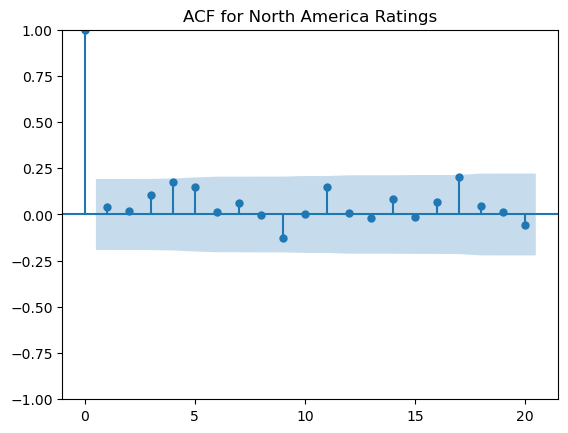

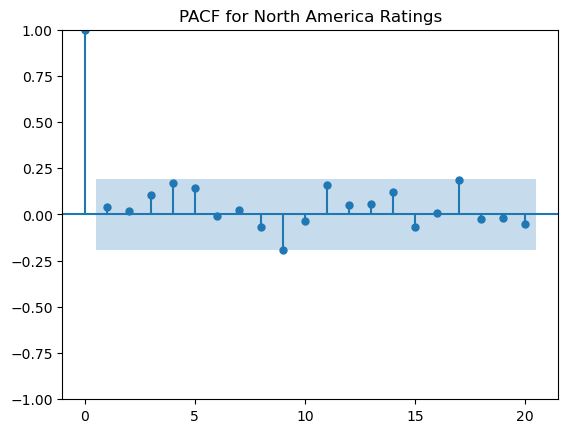

In [98]:
na_ratings = na_region_time_series['mean_rating']

# plotting ACF for North America
plot_acf(na_ratings, lags=20, alpha=0.05)
plt.title("ACF for North America Ratings")
plt.show()

# plotting PACF for North America
plot_pacf(na_ratings, lags=20, alpha=0.05)
plt.title("PACF for North America Ratings")
plt.show()

ARIMA model (AutoRegressive Integrated Moving Average) is a popular statistical method used primarily in time series forecasting. It has 3 components, the Auto Regressive (AR) part which uses the relationship between an observation and a specified number of previous values in the time series, the Integrated (I) part which  involves differencing the data to make it stationary and the Moving Average (MA) part which uses a specified number of previous error terms. It is often represented as ARIMA(p,d,q) where p is the number of previous values we use for an observation, d is the degree of differencing and q is the number of previous error terms we use for an observation.

c:\Users\bosca\anaconda3\envs\ada\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\bosca\anaconda3\envs\ada\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\bosca\anaconda3\envs\ada\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            mean_rating   No. Observations:                  104
Model:                 ARIMA(1, 0, 1)   Log Likelihood                  10.765
Date:                Fri, 15 Nov 2024   AIC                            -13.531
Time:                        19:02:43   BIC                             -2.953
Sample:                             0   HQIC                            -9.245
                                - 104                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1052      0.042     74.050      0.000       3.023       3.187
ar.L1          0.9282      0.164      5.661      0.000       0.607       1.250
ma.L1         -0.8673      0.198     -4.381      0.0

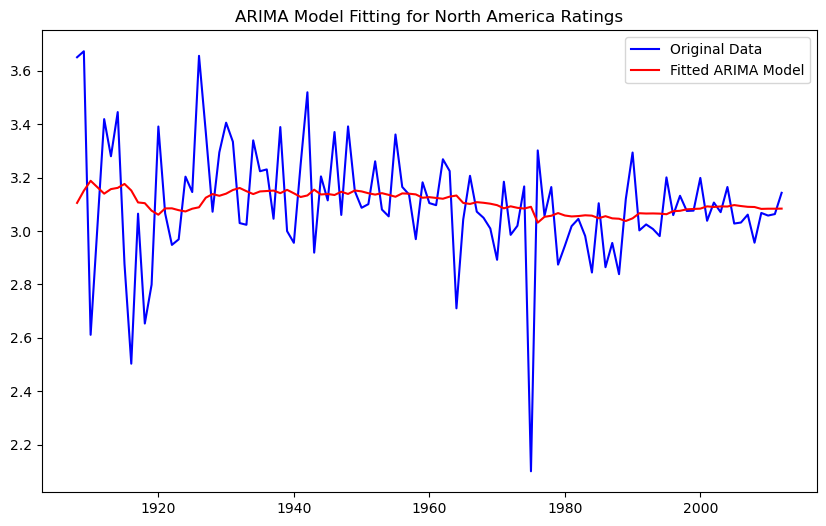

In [99]:
p = 1
q = 1

# fitting the ARMA model
arma_model = ARIMA(na_ratings, order=(p, 0, q)) 
fitted_model = arma_model.fit()

print(fitted_model.summary())

# plotting the fitted values and original data
plt.figure(figsize=(10, 6))
plt.plot(na_ratings, label="Original Data", color='blue')
plt.plot(fitted_model.fittedvalues, label="Fitted ARIMA Model", color='red')
plt.title("ARIMA Model Fitting for North America Ratings")
plt.legend()
plt.show()

However, as the fitting is not great, a stepwise method is adopted (instead of forward or backward method) validating on the AIC to find better coefficients for the modelling. 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=50.396, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=21.872, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=48.423, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9.283, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-1.100, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-5.548, Time=0.08 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-4.105, Time=0.10 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-4.437, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-5.924, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-8.258, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-5.984, Time=0.21 sec
 ARIMA(2,1

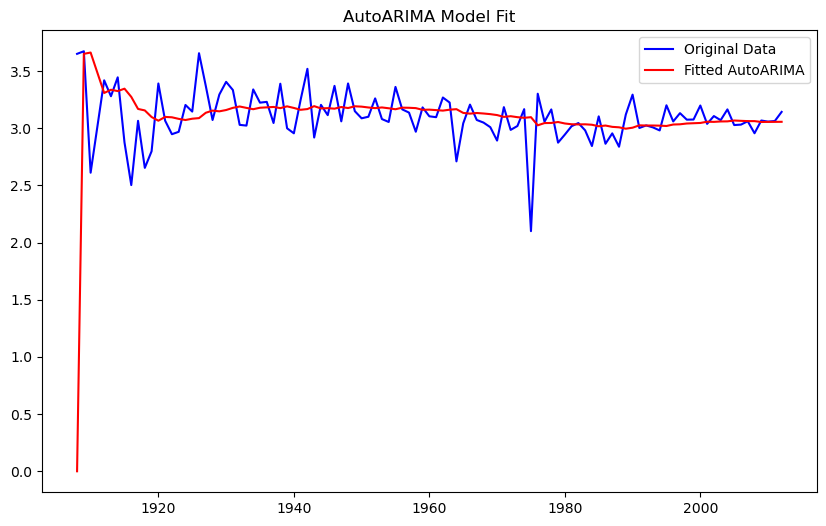

In [100]:
# fitting the AutoARIMA model to the data
auto_model = pm.auto_arima(na_ratings, seasonal=False, stepwise=True, trace=True)

# getting the best p, d, q values and the corresponding AIC
print(f"Best Model: {auto_model.summary()}")

# plotting the original and fitted values
plt.figure(figsize=(10, 6))
plt.plot(na_ratings, label="Original Data", color='blue')
plt.plot(auto_model.fittedvalues(), label="Fitted AutoARIMA", color='red')
plt.title("AutoARIMA Model Fit")
plt.legend()
plt.show()

c:\Users\bosca\anaconda3\envs\ada\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\bosca\anaconda3\envs\ada\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\bosca\anaconda3\envs\ada\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\bosca\anaconda3\envs\ada\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\bosca\anaconda3\envs\ada\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No sup

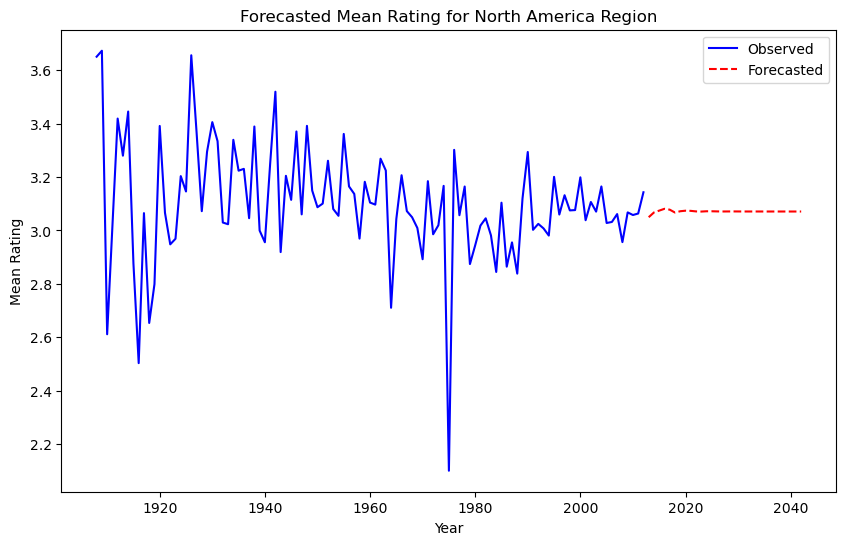

In [101]:
# forecast the next 'forecast_steps' time steps (in this case 30)
forecast_steps = 30
arma_model = ARIMA(na_ratings, order=(5, 1, 1)) 
fitted_model = arma_model.fit()
forecast = fitted_model.forecast(steps=forecast_steps)

plt.figure(figsize=(10, 6))
plt.plot(na_region_time_series.index, na_region_time_series['mean_rating'], label='Observed', color='blue')

# creating the forecasted range based on the last observed year
last_year = na_region_time_series.index[-1] 
forecast_dates = pd.date_range(start=str(last_year + 1), periods=forecast_steps, freq='YE-DEC').year

plt.plot(forecast_dates, forecast, label='Forecasted', color='red', linestyle='--')

plt.title('Forecasted Mean Rating for North America Region')
plt.xlabel('Year')
plt.ylabel('Mean Rating')
plt.legend()

# Characters Analysis, focused on ethnicities

The master dataframe needs to be merged with the characters dataframe.

In [102]:
# merging based on wikipedia ID
df_g_characters = pd.merge(df_characters[['wikipedia_id', 'character_name', 'actor_ethnicity', 'ethnicity_label','mapped_clusters',  'freebase_character_id', 'actor_name']],
                             df_movies_tmdb_ratings[['wikipedia_id','countries', 'title', 'release_date','genres', 'continent']], 
                             on='wikipedia_id', how='inner')

The analysis focuses on inclusivity and representation. Thus, the first plot presented below regards the ethnicity representation across production countries.

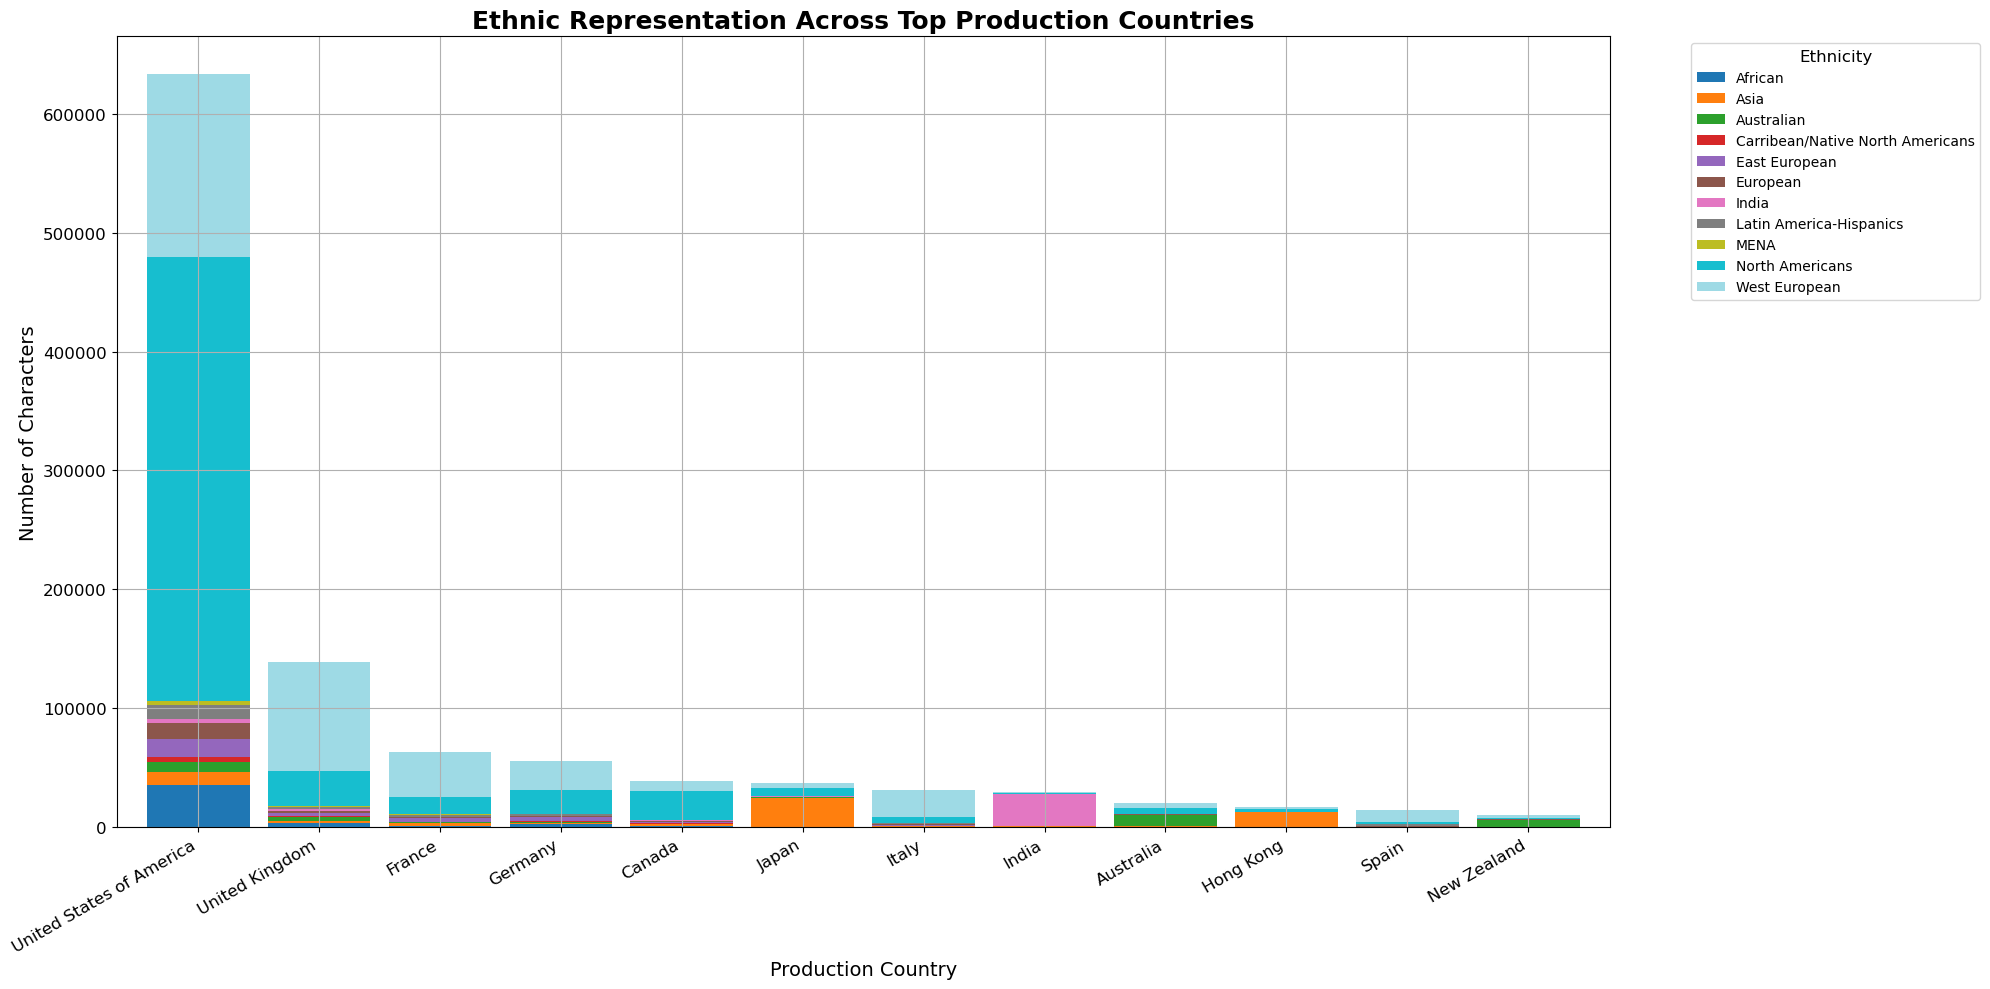

In [103]:
# filtering rows where countries and mapped_clusters are not nan
df_country_ethnicity = df_g_characters.dropna(subset=['countries', 'mapped_clusters'])
df_country_ethnicity_exploded = df_country_ethnicity.explode('countries').explode('mapped_clusters')

# ethnicity representation by production country
country_ethnicity_trends = df_country_ethnicity_exploded.groupby(['countries', 'mapped_clusters']).size().unstack(fill_value=0)

# selecting the top 20 countries by total representation
top_countries = country_ethnicity_trends.sum(axis=1).nlargest(12).index
country_ethnicity_top = country_ethnicity_trends.loc[top_countries]

plt.figure(figsize=(20, 10))  

# plotting the stacked bar chart
country_ethnicity_top.plot(kind='bar', stacked=True, colormap='tab20', width=0.85, ax=plt.gca())

plt.xlabel("Production Country", fontsize=14)
plt.ylabel("Number of Characters", fontsize=14)
plt.title("Ethnic Representation Across Top Production Countries", fontsize=18, fontweight='bold')

# some plot settings
plt.xticks(rotation=30, ha="right", fontsize=12) 
plt.yticks(fontsize=12)
plt.legend(title="Ethnicity", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

To better visualize the distribution, knowing that the US have a huge number of movies, a percentage visualization is used.

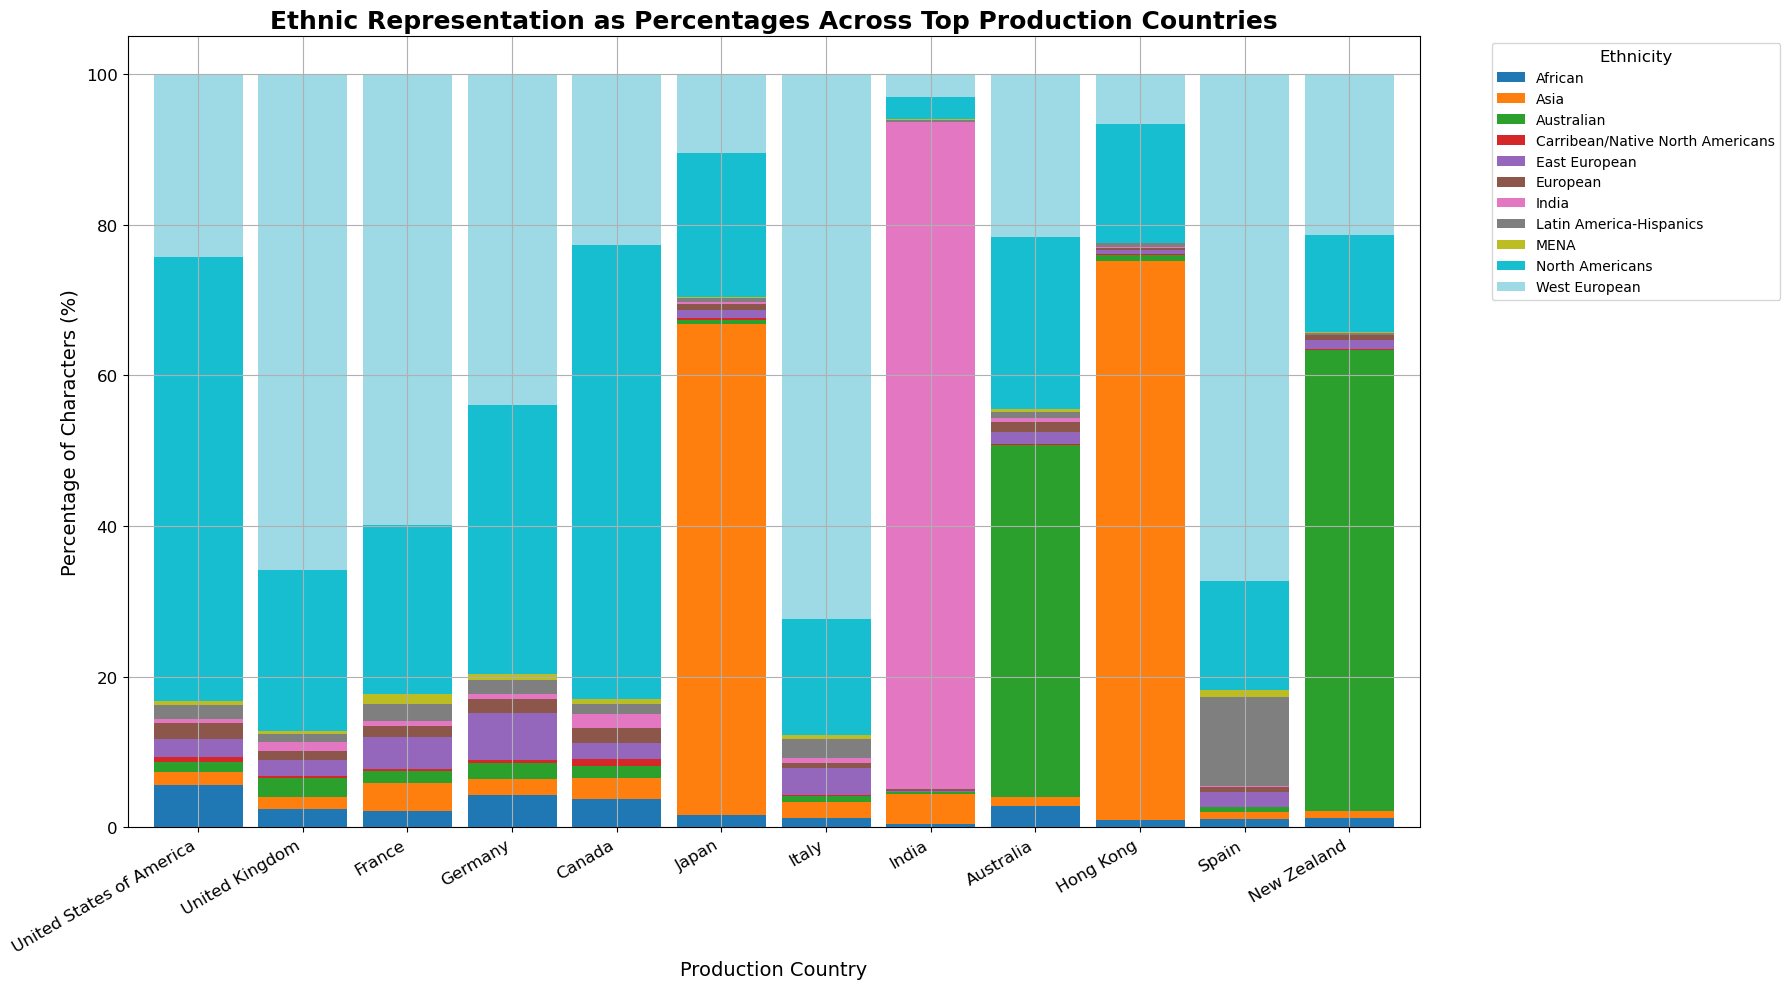

In [104]:
country_ethnicity_top_percent = country_ethnicity_top.div(country_ethnicity_top.sum(axis=1), axis=0) * 100

plt.figure(figsize=(18, 10))

# plotting the stacked bar chart with percentage values
country_ethnicity_top_percent.plot(kind='bar', stacked=True, colormap='tab20', width=0.85, ax=plt.gca())

plt.xlabel("Production Country", fontsize=14)
plt.ylabel("Percentage of Characters (%)", fontsize=14)
plt.title("Ethnic Representation as Percentages Across Top Production Countries", fontsize=18, fontweight='bold')

# some plot settings
plt.xticks(rotation=30, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Ethnicity", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

From the above graph, some interesting statements can be derived. For example, indian actors are always a small percentage of the total ethnicities in movies, but not in India, where they are almost the only ethnicity represented. Even if Japan is an Asiatic country, its actors are rarely asian. From this graph, it is evident how the North American and the West European are the major ethnicities present in movies.

Since our first regional division consists in a continental division, the same barchart is plotted, per continent. The objective is to understand representation in movies, considering the whole history of cinema. It would be interesting to pursue the same analysis, focusing on changes of representation over time.

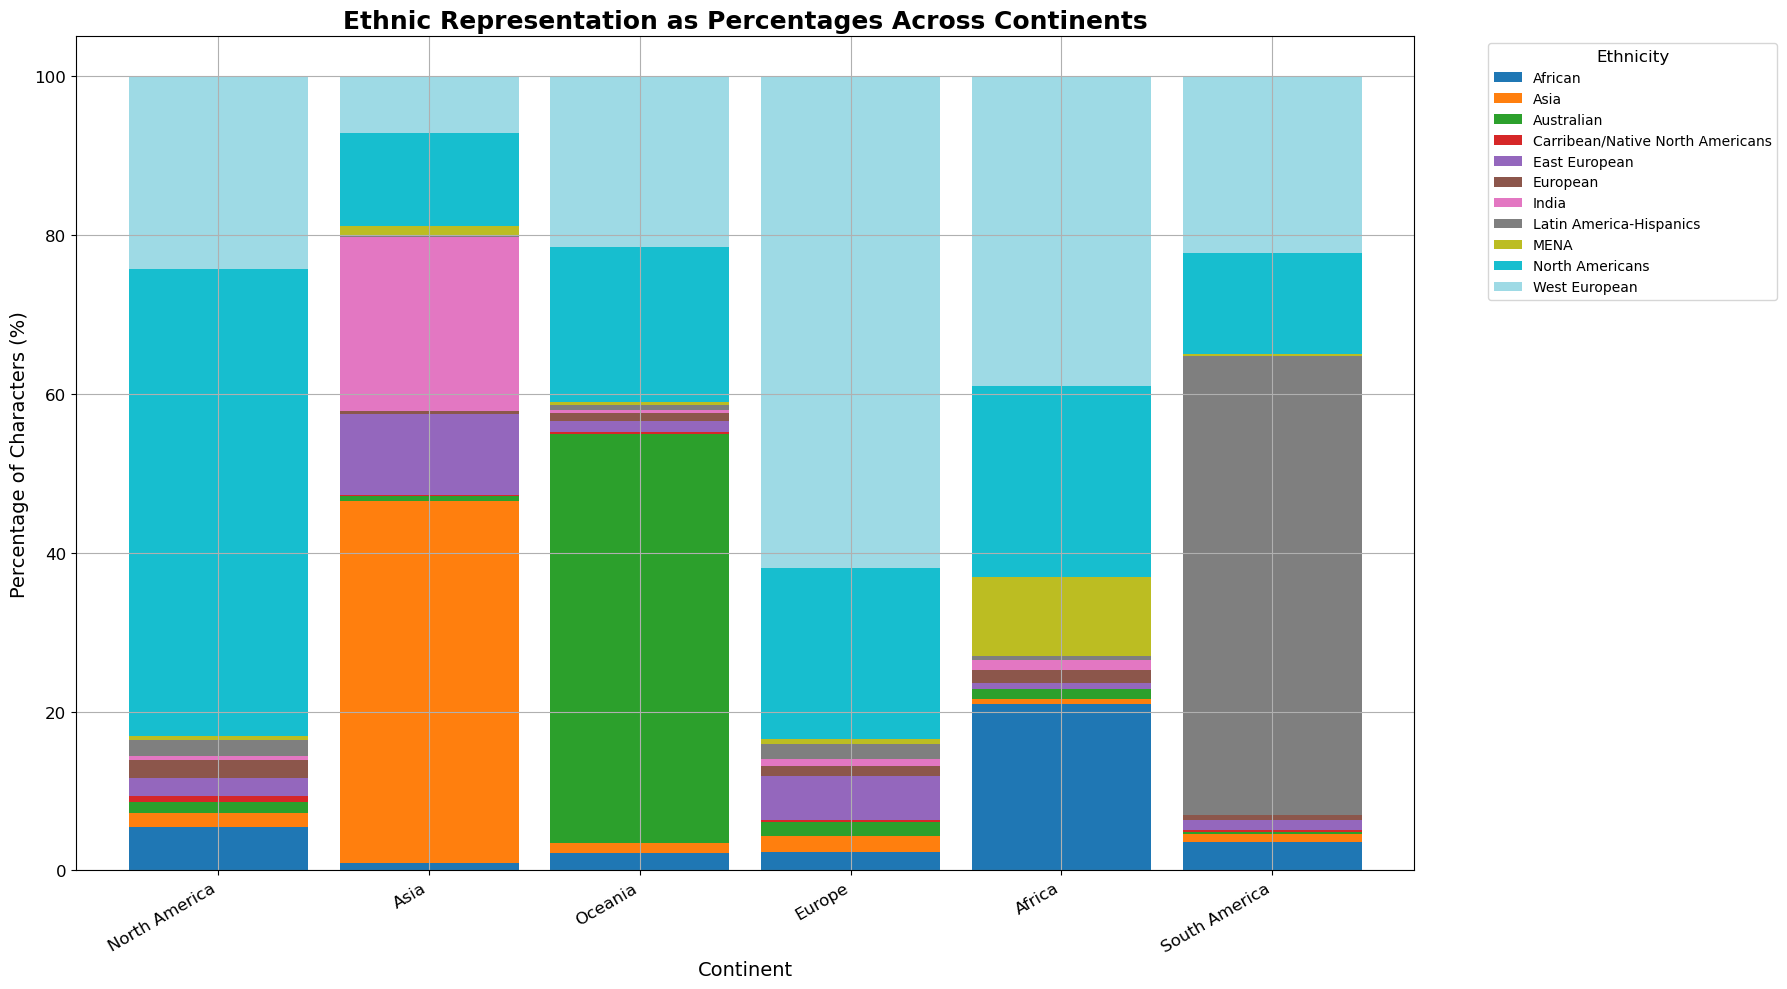

In [105]:
continent_ethnicity_trends = df_g_characters.explode('mapped_clusters').groupby(['continent', 'mapped_clusters'], observed=True).size().unstack(fill_value=0).copy()
continent_ethnicity_percent = continent_ethnicity_trends.div(continent_ethnicity_trends.sum(axis=1), axis=0) * 100

plt.figure(figsize=(18, 10)) 
continent_ethnicity_percent.plot(kind='bar', stacked=True, colormap='tab20', width=0.85, ax=plt.gca())

plt.xlabel("Continent", fontsize=14)
plt.ylabel("Percentage of Characters (%)", fontsize=14)
plt.title("Ethnic Representation as Percentages Across Continents", fontsize=18, fontweight='bold')
plt.xticks(rotation=30, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Ethnicity", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12)


plt.grid(True)
plt.tight_layout()
plt.show()

Some trends are evident from the graph above. For example, if the movies are produced in Oceania or South America, the percentage of actors with respectively Australian and South American ethnicity increases. To better understand if the continent is well-represented, ethnicities must be associated to continents.

In [106]:
continents = {
    'North America': ['United States of America', 'Canada', 'Mexico', 'Cuba', 'Puerto Rico',
                'Panama', 'Jamaica', 'Costa Rica', 'Bahamas', 'Haiti'],
    'Europe': ['United Kingdom', 'France', 'Italy', 'Germany','Spain', 'Netherland', 'Sweden', 
          'West Germany', 'Denmark', 'Czechoslovakia', 'Poland', 'Belgium', 'Norway', 'Hungary',
          'German Democratic Republic', 'Yugoslavia', 'Ireland', 'Switzerland', 'Asutria',
          'Czech Republic', 'Finland', 'England', 'Greece', 'Portugal', 'Croatia', 'Romania',
          'Bulgaria', 'Iceland', 'Luxembourg', 'Weimar Republic', 'Serbia', 'Scotland', 'Estonia',
          'Bosnia and Herzegovina', 'Slovakia', 'Slovenia', 'Albania', 'Ukraine', 'Nazi Germany',
          'Republic of Macedonia', 'Lithuania', 'Serbia and Montenegro','Socialist Federal Republic of Yugoslavia',
          'Kingdom of Great Britain', 'Federal Republic of Yugoslavia', 'Slovak Republic', 'Wales',
          'Monaco', 'Cyprus', 'Malta', 'Northern Ireland', 'Montenegro', 'Ukrainian SSR', 'Isle of Man',
          'Kingdom of Italy', 'Crime', 'German Language', 'Ukranian SSR'],
    'South America': ['Argentina', 'Brazil', 'Chile', 'Colombia', 'Venezuela', 'Peru', 'Uruguay',
                 'Bolivia', 'Guinea', 'Aruba'],
    'Asia': ['India', 'Japan', 'Hong Kong', 'South Korea', 'China', 'Soviet Union', 'Philippines',
        'Russia', 'Israel', 'Turkey', 'Thailand', 'Taiwan', 'Iran', 'Pakistan', 'Indonesia',
        'Malaysia', 'Sri Lanka', 'Singapore', 'Bangladesh', 'Lebanon', 'Nepal', 'Vietnam',
        'Korea', 'Azerbaijan', 'Georgia', 'Iraq', 'United Arab Emirates', 'Afghanistan', 'Armenia',
        'Palestinian territories', 'Georgian SSR', 'Mandatory Palestine', 'Uzbek SSR', 'Uzbekistan',
        'Mongolia', 'Kuwait', 'Bahrain', 'Bhutan', 'Qatar', 'Soviet occupation zone', 'Malayalam Language',
        'Jordan', 'Iraqi Kurdistan', 'Republic of China', 'Macau', 'Palestinian Territories'],
    'Australia': ['Australia', 'New Zealand'],
    'Africa': ['South Africa', 'Egypt', 'Cambodia', 'Morocco', 'Senegal', 'Burkina Faso', 'Algeria', 
          'Tunisia', 'Burma', 'Nigeria', 'Republic Democratic of the Congo', 'Mali', 'Kenia',
          'Cameroon', 'Ethiopia', 'Zimbabwe', 'Congo', 'Libya', 'Zambia', 'Guinea-Bissau']
}

# dictionary to map each country to a continent
country_to_continent = {country: continent for continent, countries in continents.items() for country in countries}

# dropping rows with no country information
df_completeCountry = df_g_characters.dropna(subset=['countries'])

# extracting the first country name if 'countries' is a list (in case there are multiple countries per row)
df_completeCountry['countries'] = df_completeCountry['countries'].apply(
    lambda x: x[0] if isinstance(x, list) and len(x) > 0 else x
)

# mapping each country to its continent and create a new column 'continent'
df_completeCountry['continent'] = df_completeCountry['countries'].map(country_to_continent)

In [107]:
# Associating ethnicities to continents
ethnicity_to_continent = {
    'African': ['Africa'],
    'Asia': ['Asia'],
    'West European': ['Europe'],
    'East European': ['Europe'],
    'European' : ['Europe'], 
    'MENA': ['Asia', 'Africa'],
    'Carribean/Native North Americans': ['North America'],
    'North Americans': ['North America'],
    'Australian': ['Oceania'],
    'Latin America-Hispanics': ['South America'],
    'India': ['Asia'],
}

In [108]:
# creating a new column 'actor_continent' where to map ethnicities
df_g_characters_clusters_exploded = df_g_characters.explode('mapped_clusters')

df_g_characters_continent = df_g_characters_clusters_exploded.copy()
df_g_characters_continent['actor_continent'] = df_g_characters_clusters_exploded['mapped_clusters'].map(ethnicity_to_continent)
df_g_characters_continent = df_g_characters_continent.explode('actor_continent')

Now, continent representation can be verified.

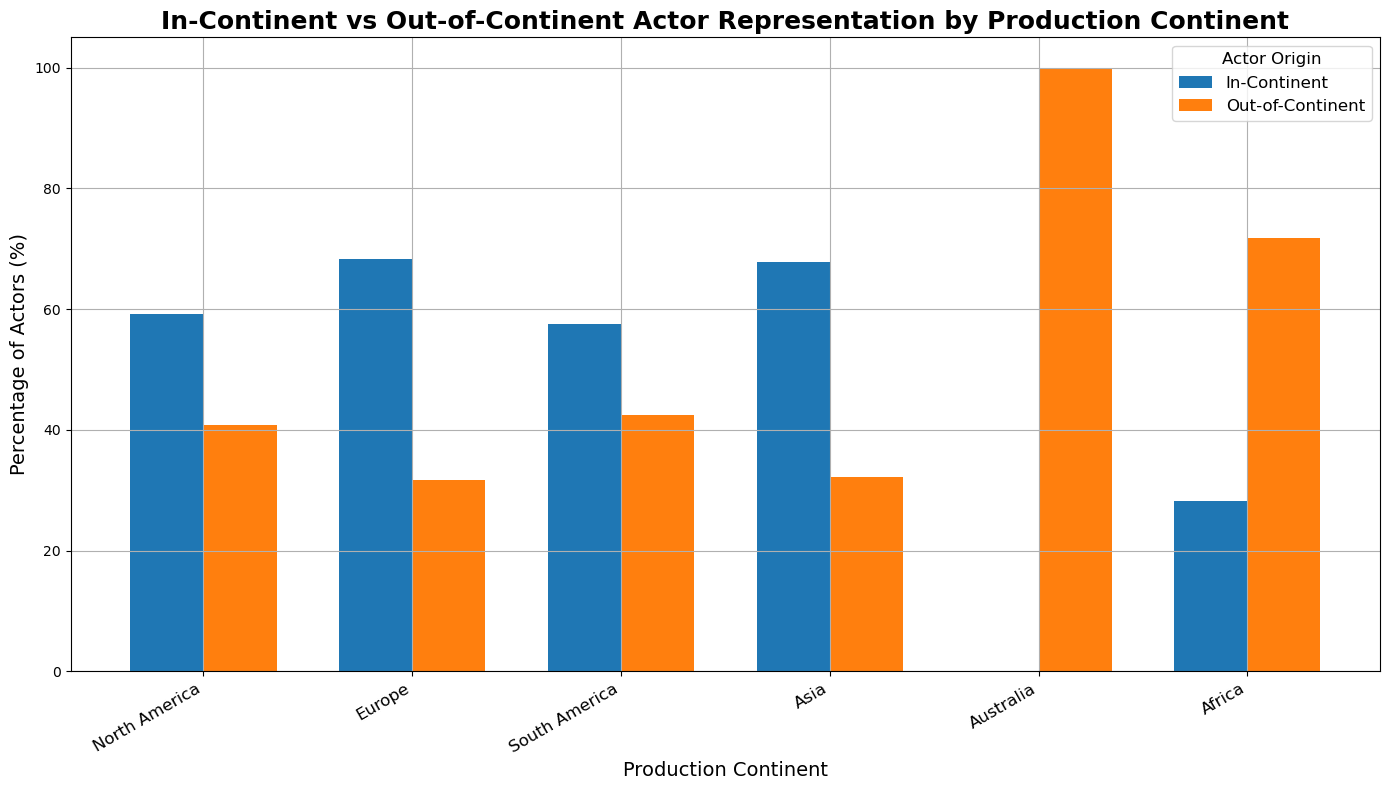

In [109]:
# removing rows with nans in 'continent' or 'actor_continent'
df_g_characters_filtered = df_g_characters_continent.dropna(subset=['continent', 'actor_continent'])

# dictionary to store in-continent and out-of-continent percentages
continent_actor_percentage = {}

for continent in continents:
    df_current_production_continent = df_g_characters_filtered[df_g_characters_filtered['continent'] == continent]
    
    # calculating the number of actors from the same continent
    in_continent_count = df_current_production_continent[df_current_production_continent['actor_continent'] == continent].shape[0]
    
    # calculating total number of actors for continent
    total_actors = df_current_production_continent.shape[0]
    
    # calculating in-continent and out-of-continent percentages
    in_continent_percentage = (in_continent_count / total_actors) * 100 if total_actors > 0 else 0
    out_continent_percentage = 100 - in_continent_percentage
    
    # storeùing in and out percentages
    continent_actor_percentage[continent] = {
        'In-Continent': in_continent_percentage,
        'Out-of-Continent': out_continent_percentage
    }

# lists extractions 
continents = list(continent_actor_percentage.keys())
in_continent_percentages = [percentages['In-Continent'] for percentages in continent_actor_percentage.values()]
out_continent_percentages = [percentages['Out-of-Continent'] for percentages in continent_actor_percentage.values()]


bar_width = 0.35
x = np.arange(len(continents))

# plot
plt.figure(figsize=(14, 8))
plt.bar(x - bar_width/2, in_continent_percentages, width=bar_width, label='In-Continent', color='#1f77b4')
plt.bar(x + bar_width/2, out_continent_percentages, width=bar_width, label='Out-of-Continent', color='#ff7f0e')

plt.xlabel("Production Continent", fontsize=14)
plt.ylabel("Percentage of Actors (%)", fontsize=14)
plt.title("In-Continent vs Out-of-Continent Actor Representation by Production Continent", fontsize=18, fontweight='bold')
plt.xticks(ticks=x, labels=continents, rotation=30, ha="right", fontsize=12)
plt.legend(title="Actor Origin", fontsize=12, title_fontsize=12, loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

As the above plot suggests, only the Asia and the Europe are represented by the actors' ethnicities of their movies.

The analysis now shifts the focus on each continent, plotting how the ethnicity representation changes over time, per continent. To improve visualization, a rolling mean is adopted.

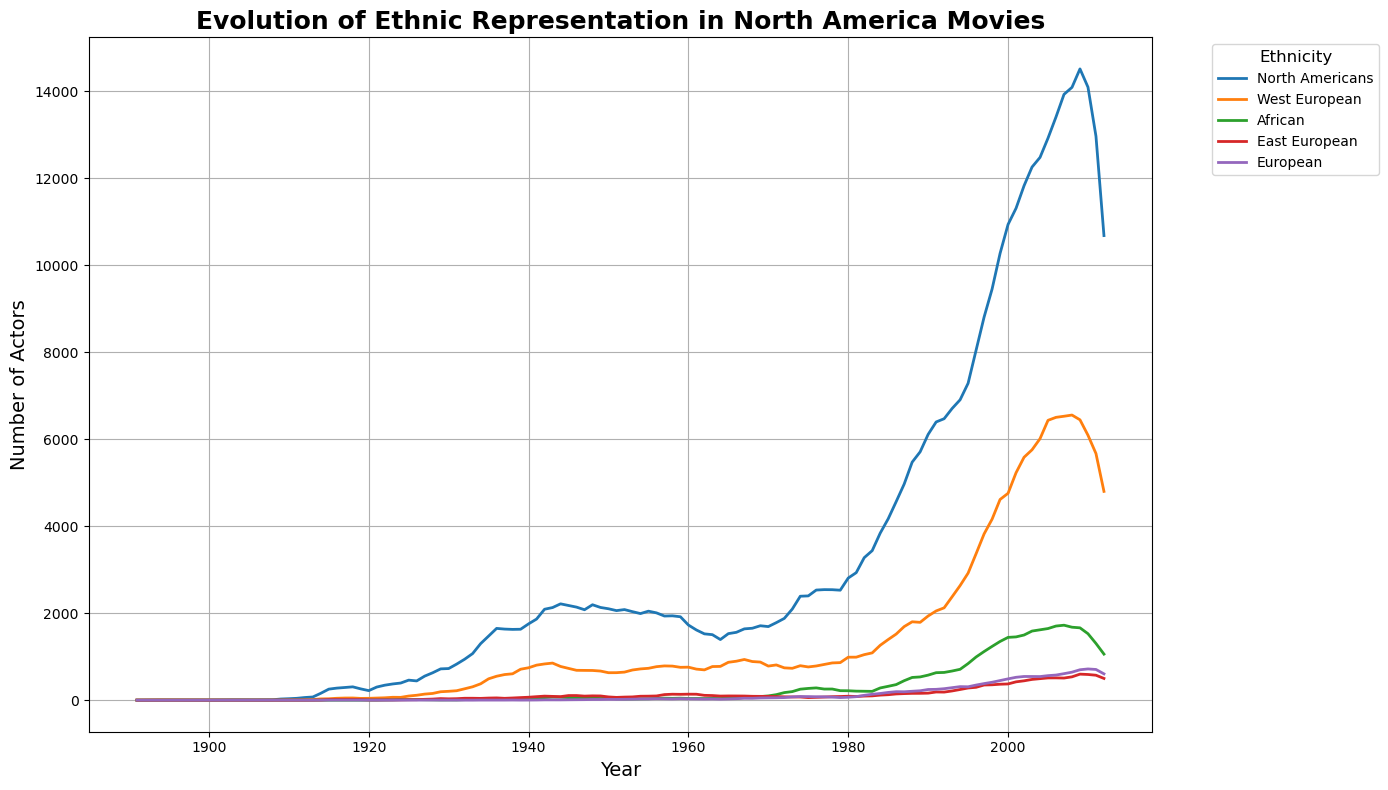

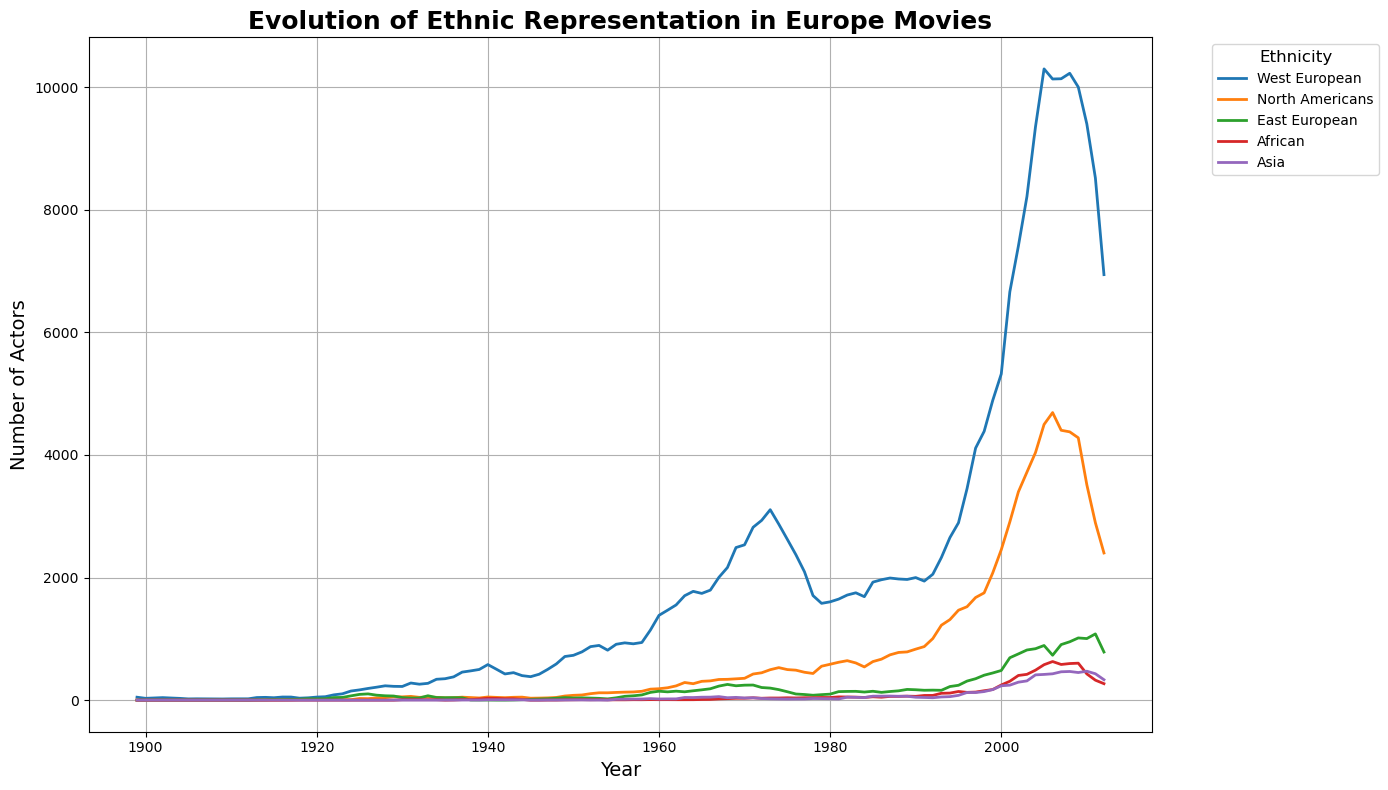

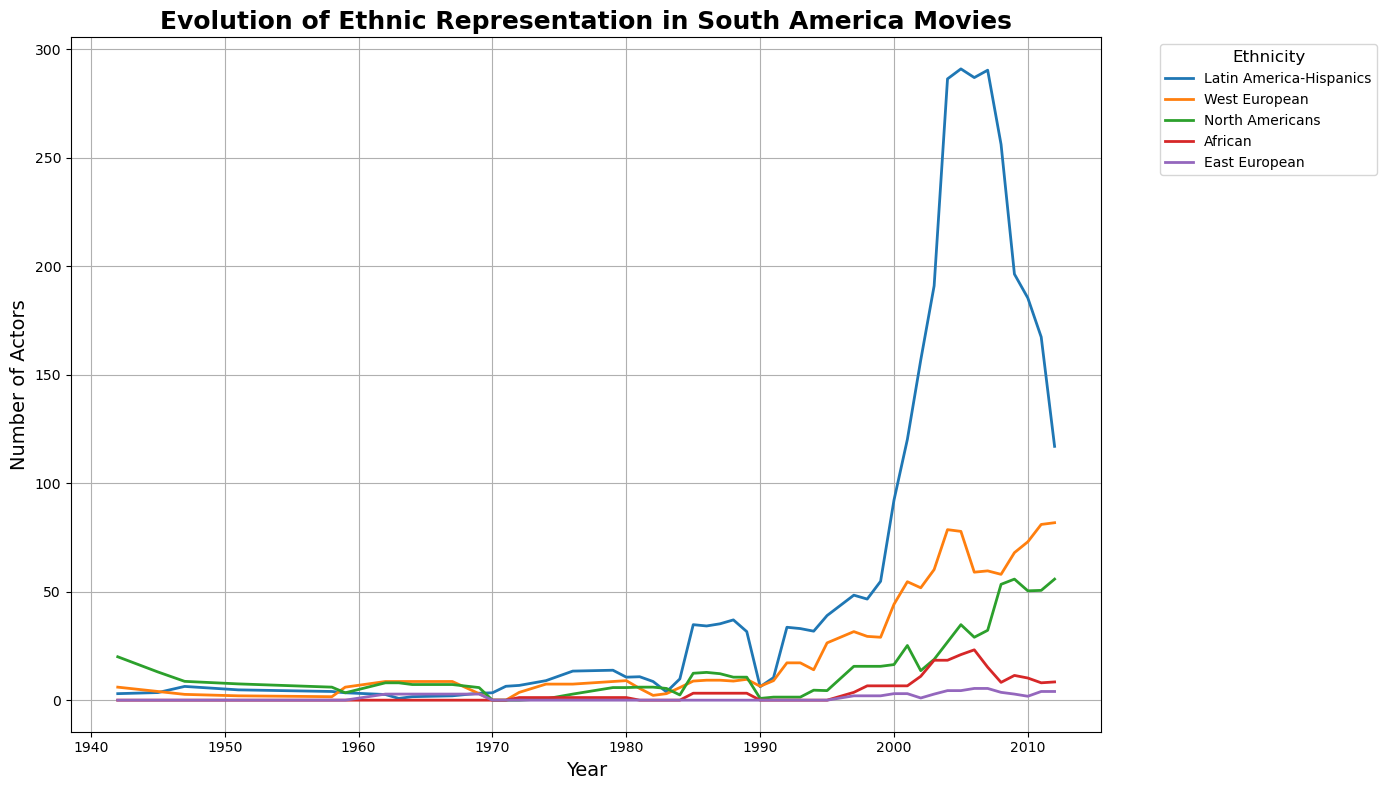

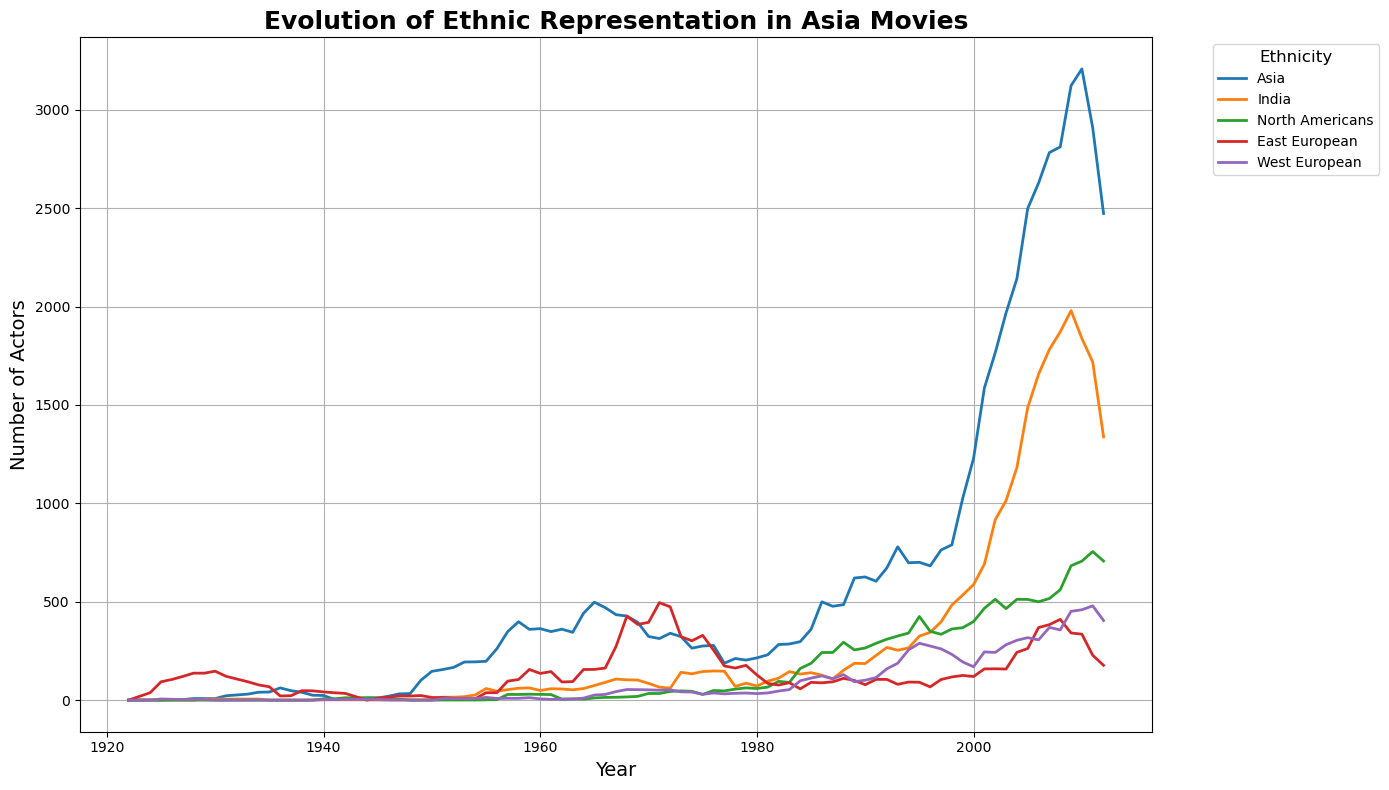

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


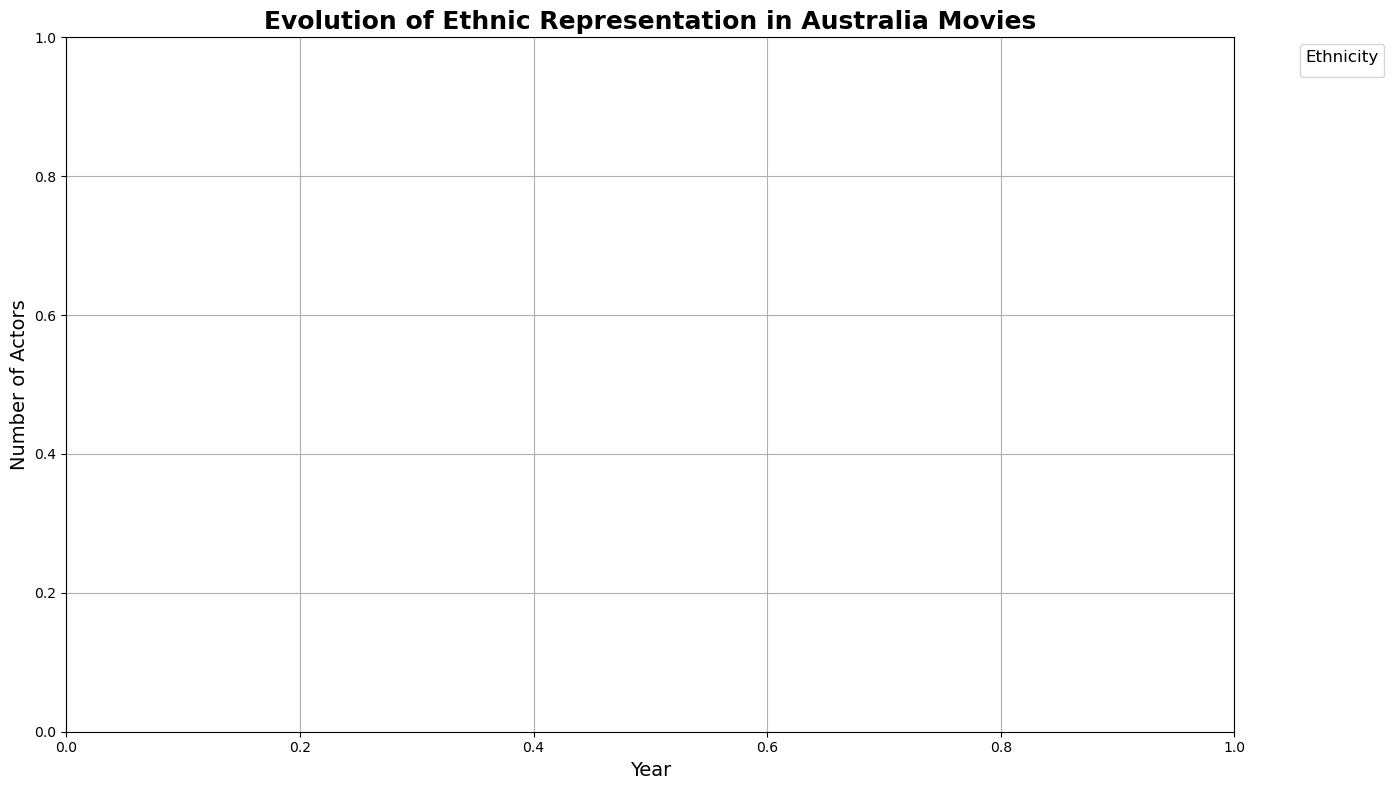

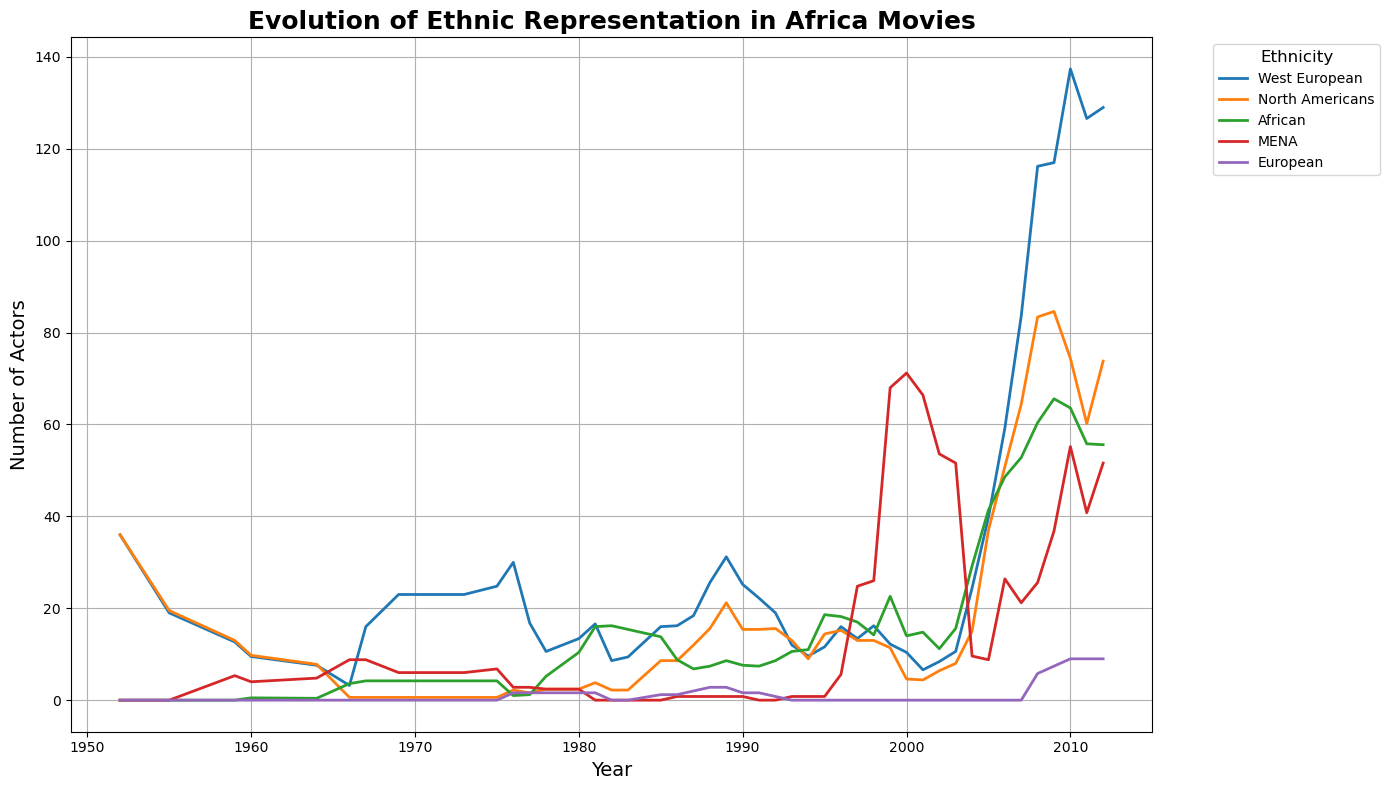

In [110]:
for continent in continents:
    df_current_continent = df_g_characters_continent[df_g_characters_continent['continent'] == continent]
    
    # grouping by year and ethnicity, counting occurrences
    ethnicity_counts_by_year = (
        df_current_continent.groupby(['release_date', 'mapped_clusters'])
        .size()
        .unstack(fill_value=0)
    )
    
    # rolling mean
    top_ethnicities = ethnicity_counts_by_year.sum().nlargest(5).index
    ethnicity_counts_by_year = ethnicity_counts_by_year[top_ethnicities]
    ethnicity_counts_smoothed = ethnicity_counts_by_year.rolling(window=5, min_periods=1).mean()

    plt.figure(figsize=(14, 8))
    for ethnicity in ethnicity_counts_smoothed.columns:
        plt.plot(
            ethnicity_counts_smoothed.index,
            ethnicity_counts_smoothed[ethnicity],
            label=ethnicity,
            linewidth=2
        )
    
    # some plot settings
    plt.xlabel("Year", fontsize=14)
    plt.ylabel("Number of Actors", fontsize=14)
    plt.title(f"Evolution of Ethnic Representation in {continent} Movies", fontsize=18, fontweight='bold')
    plt.legend(title="Ethnicity", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

The conclusion that can be drawn are:

1. **Australia**: Dominantly represented by Australians, with noticeable growth in the 1980s and peaking in the early 2000s. Other ethnicities like West European and North Americans remain consistently low.

2. **South America**: Latin America-Hispanic representation is highest, showing moderate growth, especially around the 1940s and the late 1990s. Other ethnicities have minimal presence.

3. **North America**: North Americans are the most represented, with a sharp increase starting in the 1960s, peaking around 2000. West Europeans and African ethnicities follow with lower but steady growth over time.

4. **Europe**: West Europeans dominate the representation, especially after 1930, with a significant rise around the 1950s. East Europeans and North Americans have minimal but visible representation.

5. **Asia**: Indian and Asian ethnicities dominate, showing steady growth, particularly after the 1960s. Other ethnic groups have minor representation throughout the years.

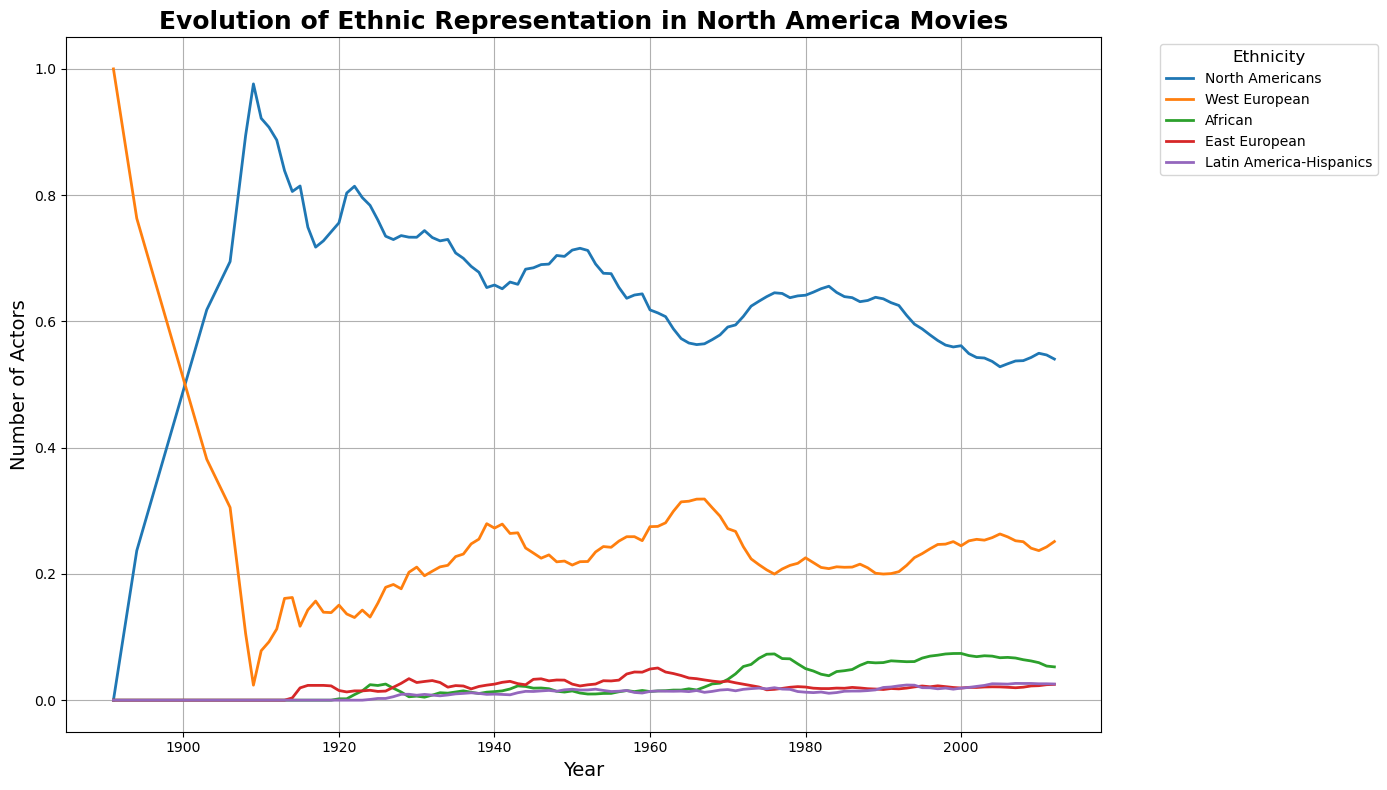

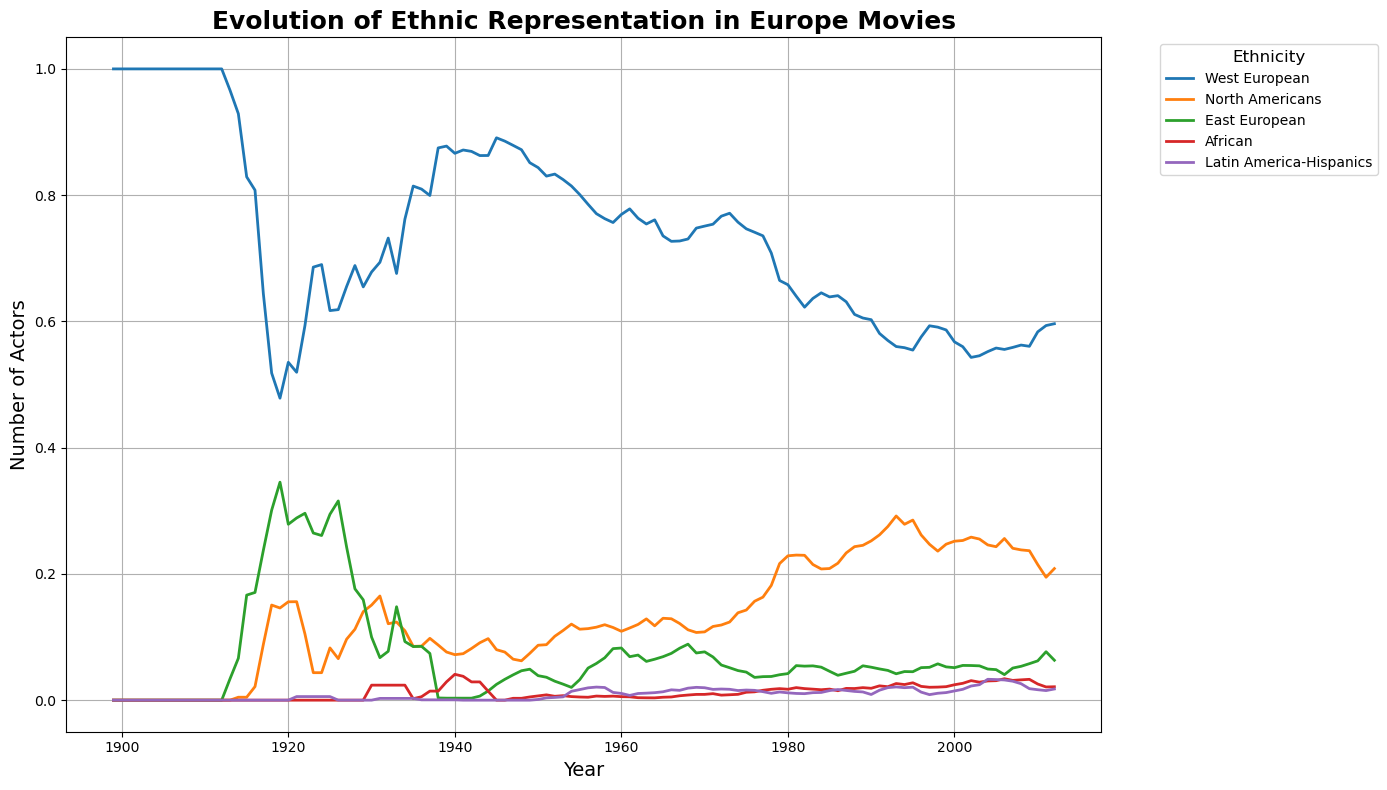

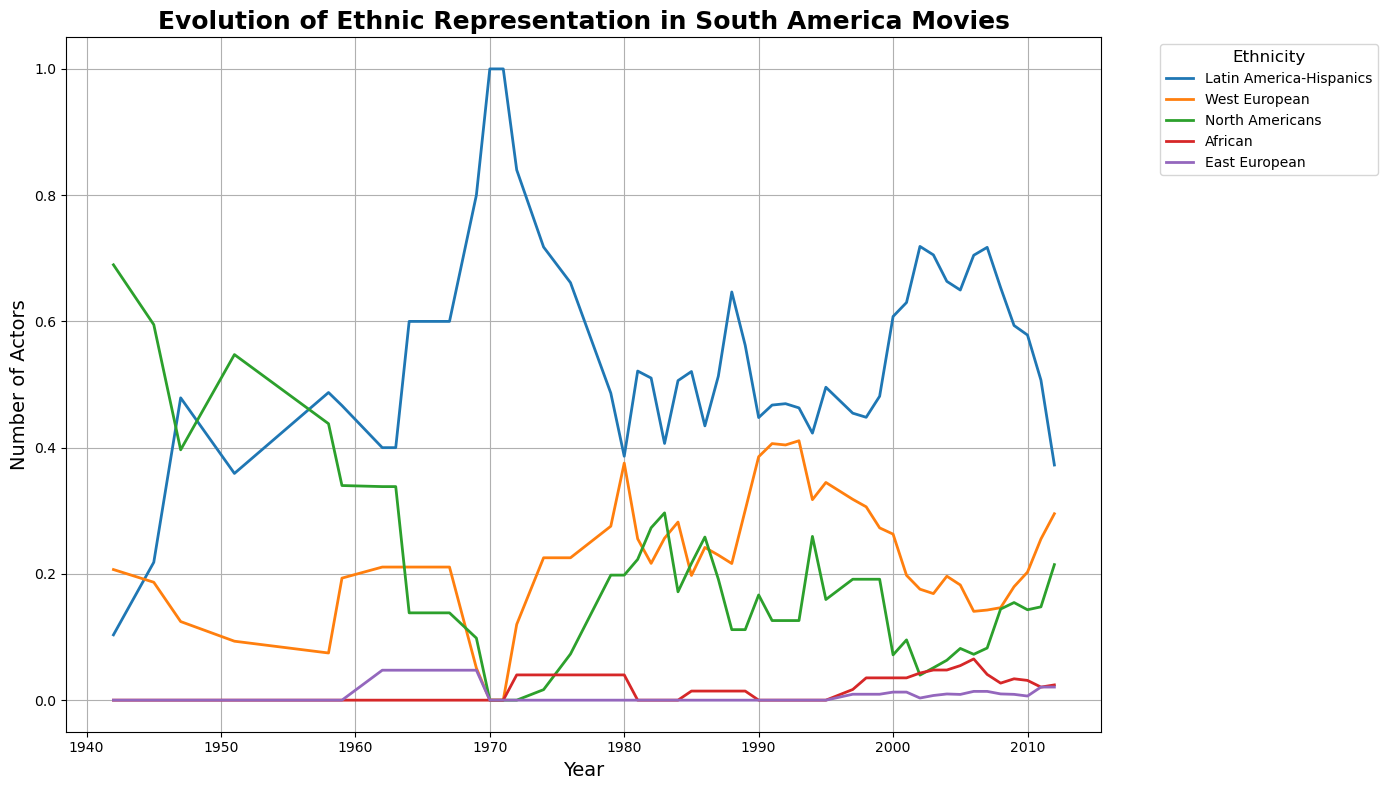

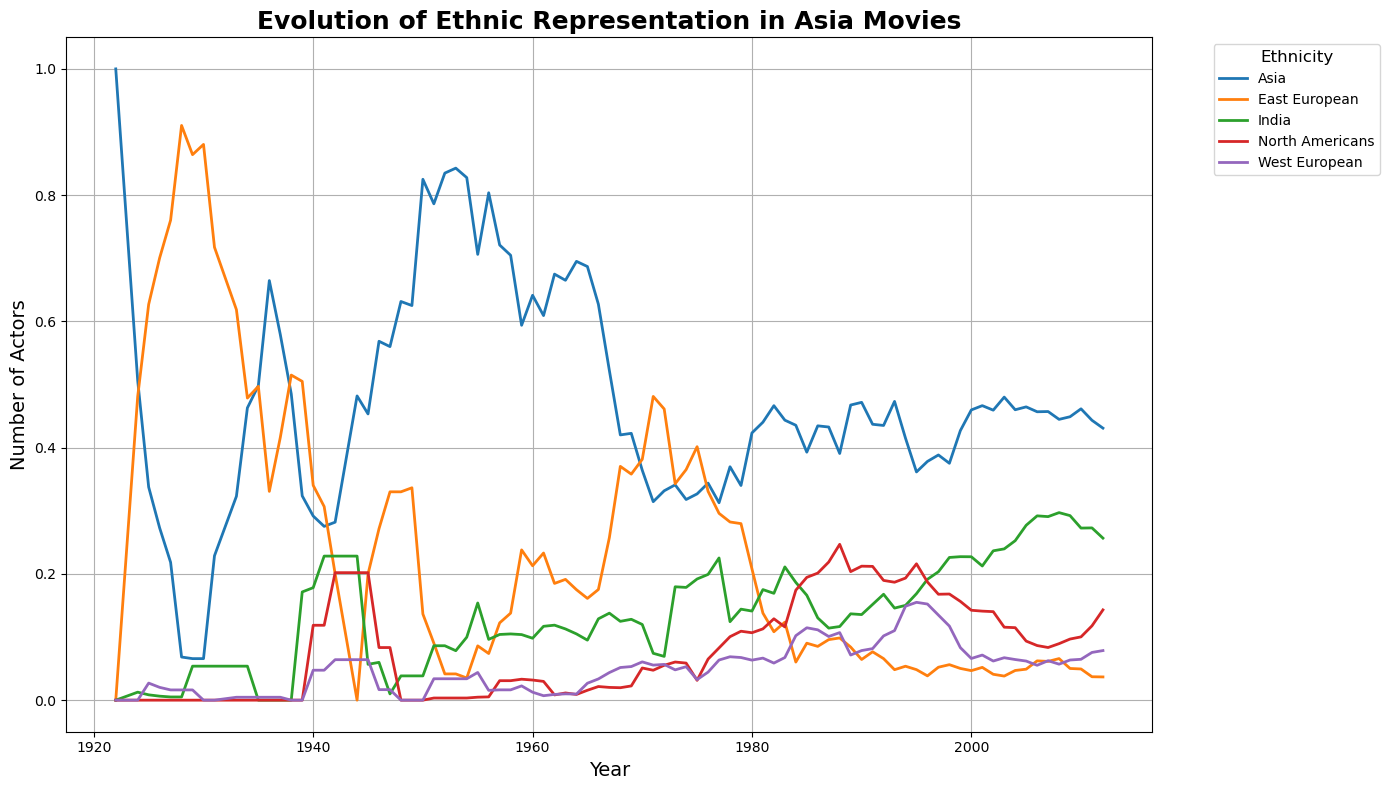

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


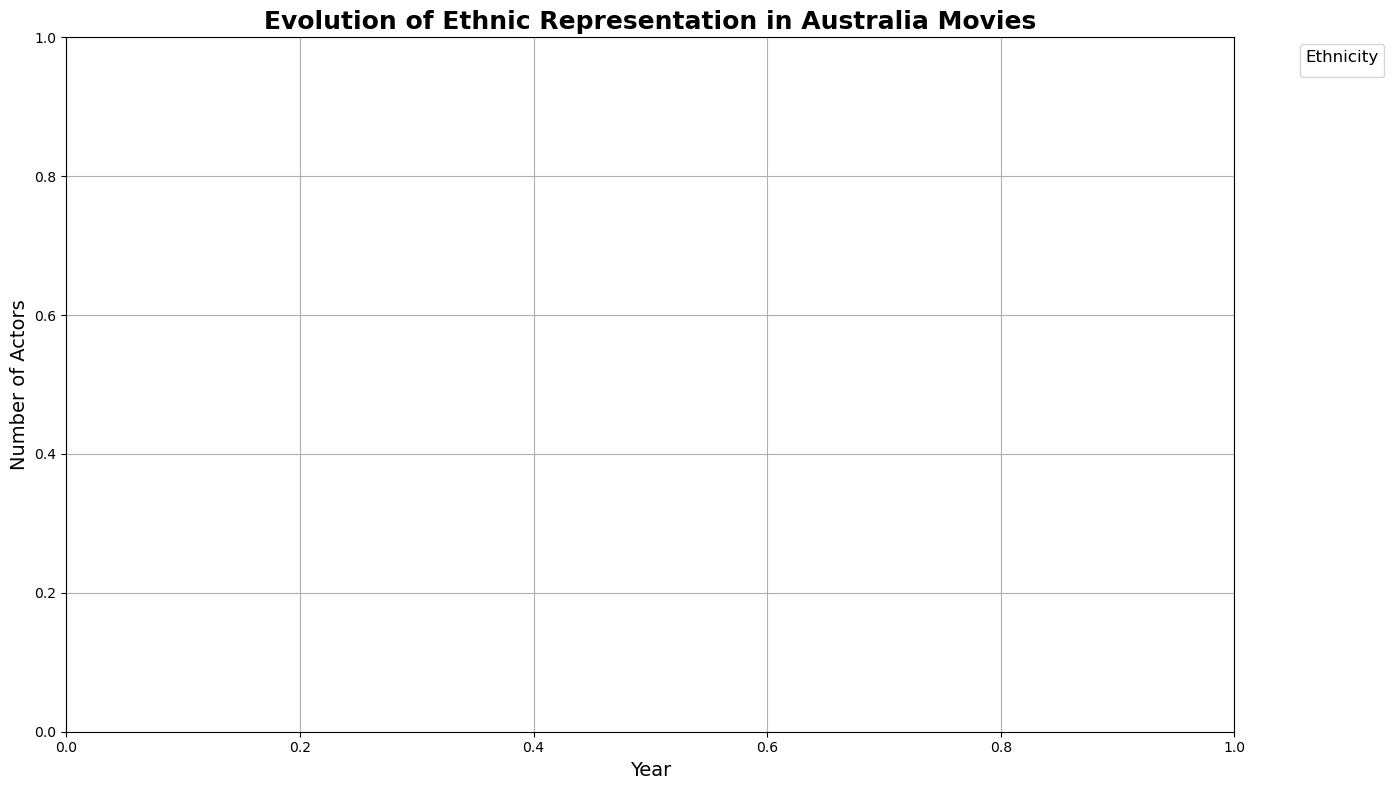

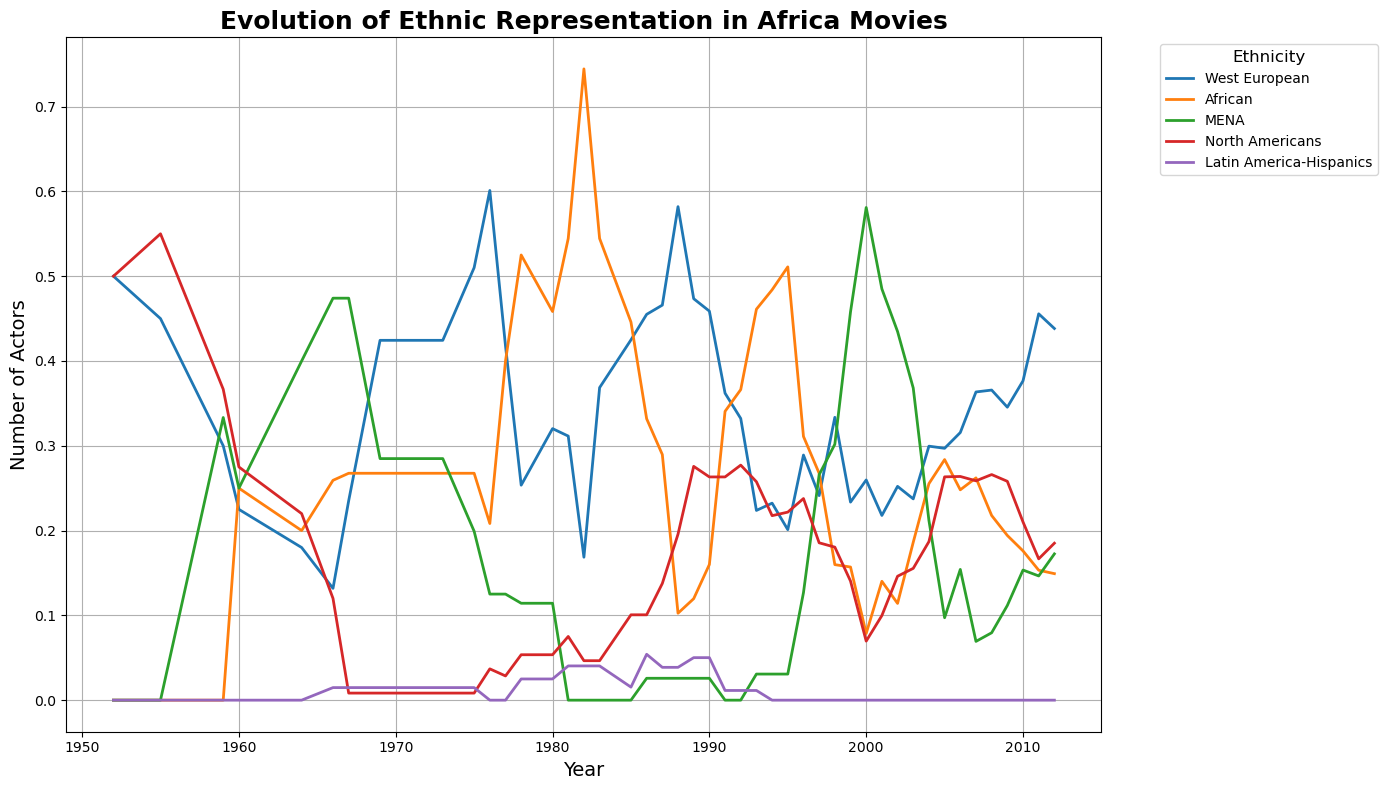

In [111]:
for continent in continents:    
    df_current_continent = df_g_characters_continent[df_g_characters_continent['continent'] == continent]
    
    df_exploded = df_current_continent.explode('mapped_clusters')

    # grouping by year and ethnicity, counting occurrences
    ethnicity_counts_by_year = (
        df_exploded.groupby(['release_date', 'mapped_clusters'])
        .size()
        .unstack(fill_value=0)
    )

    # normalize by total counts/year
    yearly_totals = ethnicity_counts_by_year.sum(axis=1)
    ethnicity_counts_normalized = ethnicity_counts_by_year.div(yearly_totals, axis=0)

    # filtering to top ethnicities
    top_ethnicities = ethnicity_counts_normalized.sum().nlargest(5).index
    ethnicity_counts_normalized = ethnicity_counts_normalized[top_ethnicities]

    # rolling mean
    ethnicity_counts_smoothed = ethnicity_counts_normalized.rolling(window=5, min_periods=1).mean()

    plt.figure(figsize=(14, 8))
    for ethnicity in ethnicity_counts_smoothed.columns:
        plt.plot(
            ethnicity_counts_smoothed.index,
            ethnicity_counts_smoothed[ethnicity],
            label=ethnicity,
            linewidth=2
        )
    
    # some plot settings
    plt.xlabel("Year", fontsize=14)
    plt.ylabel("Number of Actors", fontsize=14)
    plt.title(f"Evolution of Ethnic Representation in {continent} Movies", fontsize=18, fontweight='bold')
    plt.legend(title="Ethnicity", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

The analysis focuses on the ethnicity representation in different movie genres, to see if there are particular preferences.

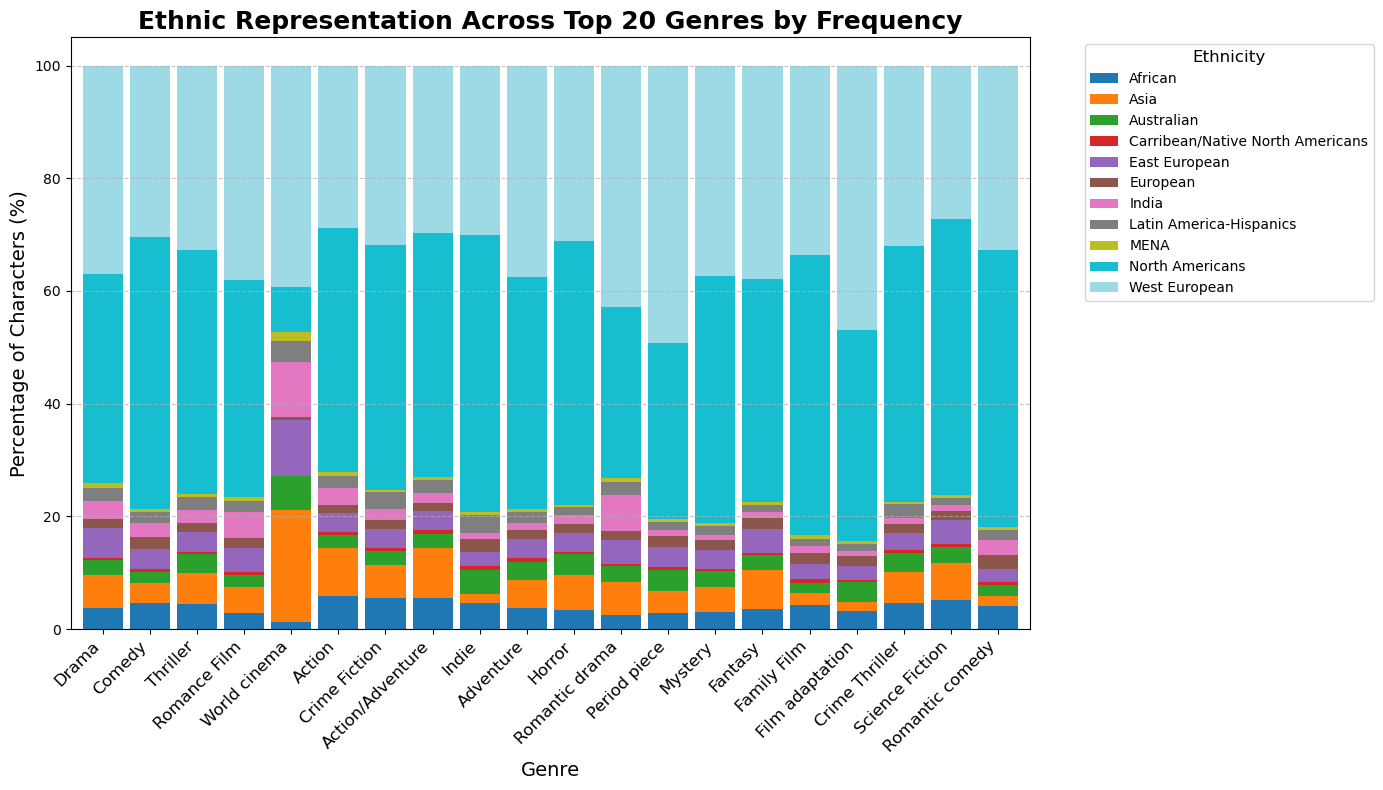

In [112]:
# grouping by genre and ethnicity and select the 20 top genres
genre_ethnicity_counts = df_g_characters_clusters_exploded.groupby(['genres', 'mapped_clusters']).size().unstack(fill_value=0)
top_genres = df_g_characters['genres'].value_counts().nlargest(20).index

# filtering genre-ethnicity counts for the top 20 genres
genre_ethnicity_top = genre_ethnicity_counts.loc[top_genres]

# normalizing counts to percentages
genre_ethnicity_percentages = genre_ethnicity_top.div(genre_ethnicity_top.sum(axis=1), axis=0) * 100

plt.figure(figsize=(14, 8))
genre_ethnicity_percentages.plot(kind='bar', stacked=True, colormap='tab20', width=0.85, ax=plt.gca())

# graph Settings
plt.xlabel("Genre", fontsize=14)
plt.ylabel("Percentage of Characters (%)", fontsize=14)
plt.title("Ethnic Representation Across Top 20 Genres by Frequency", fontsize=18, fontweight='bold')
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.legend(title="Ethnicity", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In each of the top genres, the majority of the actors belongs to the North American or Western European ethnicity group. A slight increase in the Indian ethnicity for genres like 'World cinema' or 'romantica drama'. Generally, the African ethnicity is one of the most present, between the minorities.

In this case, changing type of visualization leads to the same conclusions.

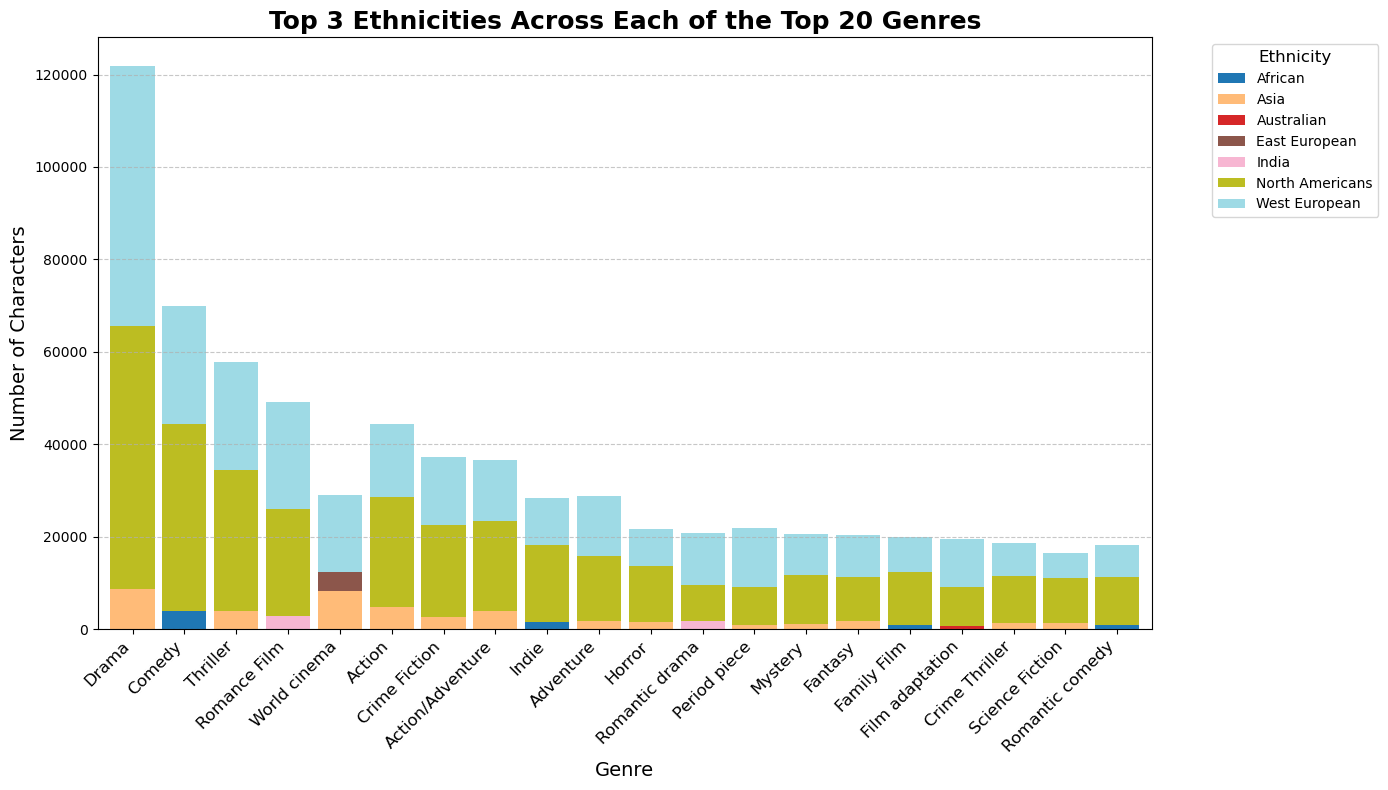

In [113]:
top_3_ethnicities_per_genre = genre_ethnicity_top.apply(lambda x: x.nlargest(3), axis=1).fillna(0)

# plot the top 3 ethnicities for each genre in the top 20 genres
plt.figure(figsize=(14, 8))
top_3_ethnicities_per_genre.plot(kind='bar', stacked=True, colormap='tab20', width=0.85, ax=plt.gca())

plt.xlabel("Genre", fontsize=14)
plt.ylabel("Number of Characters", fontsize=14)
plt.title("Top 3 Ethnicities Across Each of the Top 20 Genres", fontsize=18, fontweight='bold')
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.legend(title="Ethnicity", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Inside each movie, how are ethnicities represented? The objective of the code below is thus to investigate the number of different ethnicities in each movie.

In [114]:
movie_ethnicity_stats = df_g_characters.groupby('wikipedia_id').agg(
    num_characters=('character_name', 'size'),  # Total characters per movie
    num_ethnicities=('mapped_clusters', lambda x: len(set([ethnicity for clusters in x if clusters for ethnicity in clusters]))),  # Count unique ethnicities
    num_ethnicities_available=('mapped_clusters', lambda x: sum(1 for clusters in x if clusters)),  # Count non-empty ethnicity entries
    num_characters_with_ethnicity=('mapped_clusters', lambda x: sum(1 for clusters in x if clusters))  # Count characters with any ethnicity data
).reset_index()

In [115]:
movie_ethnicity_stats['num_ethnicities'].describe()

count    24145.000000
mean         2.100476
std          1.266675
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          9.000000
Name: num_ethnicities, dtype: float64

The mean, median, and 75th percentile being close to 1-2 unique ethnicities suggest that many movies in the dataset are relatively homogeneous in terms of ethnic representation.

In [116]:
# calculating the diversity score based on characters with available ethnicity data
movie_ethnicity_stats['diversity_score'] = movie_ethnicity_stats['num_ethnicities'] / movie_ethnicity_stats['num_characters_with_ethnicity']

# replacing infinite values (if any) with NaN
movie_ethnicity_stats['diversity_score'] = movie_ethnicity_stats['diversity_score'].replace([float('inf')], np.nan)

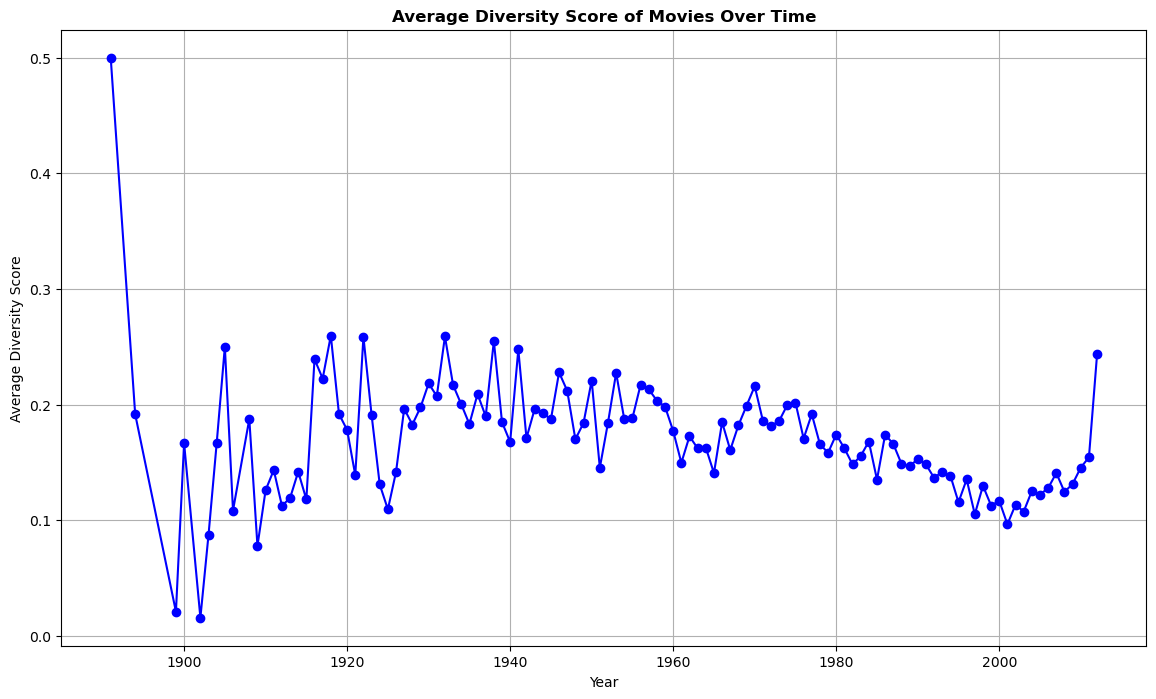

In [117]:
movie_ethnicity_stats_with_year = movie_ethnicity_stats.merge(df_g_characters[['wikipedia_id', 'release_date']], on='wikipedia_id', how='left').drop_duplicates('wikipedia_id')

# group by year and calculate the average diversity score
diversity_over_time = movie_ethnicity_stats_with_year.groupby('release_date')['diversity_score'].mean()

# plotting
plt.figure(figsize=(14, 8))
plt.plot(diversity_over_time.index, diversity_over_time.values, marker='o', color='b')
plt.title("Average Diversity Score of Movies Over Time", weight = 'bold')
plt.xlabel("Year")
plt.ylabel("Average Diversity Score")
plt.grid(True)
plt.show()

The graph presented above has a visible trend. From the birth of cinema until the 50s, the tendency is to increase the ethnicity representation, while the trend reverses in the decades drom the 50s to year 2000. In the very last decade, multi ethnicity representation steeply increases again.

Now, it is interesting to look at the nb of ethnicities in each movies. In particular, for this part, we'll continue working with continents as our clusters of ethnicities for this primary level of analysis. Later in the project, we will explore whether it's feasible to redefine smaller, more specific clusters to capture nuanced and intrinsic trends within each continent.

In [118]:
df_completeCountryContinent = df_completeCountry.explode('mapped_clusters')
df_completeCountryContinent['actor_continent'] = df_completeCountryContinent['mapped_clusters'].map(ethnicity_to_continent)

In [119]:
df_reversed = df_completeCountryContinent.groupby('freebase_character_id').agg({
    'wikipedia_id' :'first',
    'character_name': 'first',  # Take the first character name
    'actor_continent': lambda x: list(set(i for sublist in x.dropna() for i in (sublist if isinstance(sublist, list) else [sublist]))) ,
    'continent' : 'first' ,
    'release_date' : 'first',
    'genres' : 'first'
}).reset_index()

In [120]:
df_reversed['actor_continent'].value_counts()

actor_continent
[]                                                 38993
[North America]                                    23626
[Europe]                                           16257
[Europe, North America]                            12079
[Asia]                                              6528
[Africa, North America]                             3689
[Oceania]                                           1408
[South America]                                     1131
[Asia, North America]                                621
[South America, North America]                       487
[Asia, Africa]                                       266
[Oceania, Europe]                                    227
[Asia, Europe]                                       216
[Africa]                                             212
[Asia, North America, Africa]                        161
[Oceania, North America]                             133
[Africa, Europe]                                      86
[South America,

In [121]:
movie_ethnicity_stats = df_reversed.groupby('wikipedia_id').agg(
    num_characters=('character_name', 'size'),  # Total characters per movie
    num_ethnicities=('actor_continent', lambda x: len(set([ethnicity for clusters in x if clusters for ethnicity in clusters]))),  # Count unique ethnicities
    num_ethnicities_available=('actor_continent', lambda x: sum(1 for clusters in x if clusters)),  # Count non-empty ethnicity entries
    num_characters_with_ethnicity=('actor_continent', lambda x: sum(1 for clusters in x if clusters)) , # Count characters with any ethnicity data
).reset_index()

In [122]:
movie_ethnicity_stats['num_ethnicities'].describe()

count    15811.000000
mean         1.830055
std          1.030906
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          6.000000
Name: num_ethnicities, dtype: float64

In [123]:
print("Initial size of the DataFrame:",  movie_ethnicity_stats.shape[0])

Initial size of the DataFrame: 15811


In [124]:
# drop movies with 0 characters with ethnicity
movie_ethnicity_stats = movie_ethnicity_stats[movie_ethnicity_stats['num_characters_with_ethnicity'] > 0]
print("Size of the DataFrame after dropping movies with 0 characters with ethnicity data:", movie_ethnicity_stats.shape[0])

Size of the DataFrame after dropping movies with 0 characters with ethnicity data: 14751


In order to quantify the diversity of the casts of our movie, we wanted to create a diversity score per movie. A simple way to do it for this primary analysis is doing simple proportions of the nb of unique ethnicities per movie / nb of characters. But we need to sure that our data allows us to do that and that not of the data is missing. First we drop columns where we drop movies where we have 0 characters and movies with 0 ethnicities. Then, we create a croverage criteria = nb of ethnicities available/ total nb of characters per movie to quantify the missing data. 

In [125]:
movie_ethnicity_stats['coverage_coefficient'] = movie_ethnicity_stats['num_characters_with_ethnicity'] / movie_ethnicity_stats['num_characters']

In [126]:
movie_ethnicity_stats['coverage_coefficient'].describe()

count    14751.000000
mean         0.765751
std          0.243419
min          0.041667
25%          0.571429
50%          0.800000
75%          1.000000
max          1.000000
Name: coverage_coefficient, dtype: float64

Ok so for most of the movies we have a good coverage for our data which allows us to continue or analysis. 

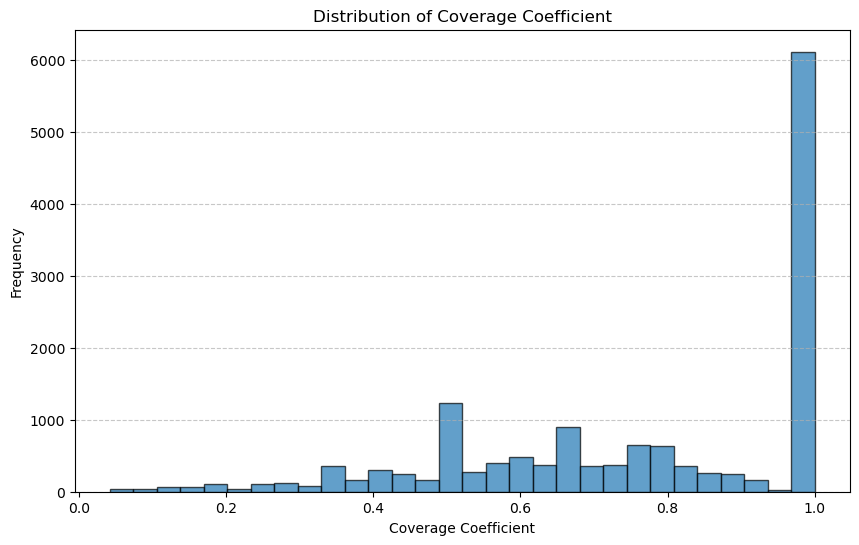

In [127]:
# plotting the distribution of the coverage coefficient
plt.figure(figsize=(10, 6))

# histogram
plt.hist(movie_ethnicity_stats['coverage_coefficient'], bins=30, edgecolor='black', alpha=0.7)
plt.title("Distribution of Coverage Coefficient")
plt.xlabel("Coverage Coefficient")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)

As we can see most of the movies have 100% coverage which is really great, so setting a threshold coverage of 60% seems good. 

In [128]:
# filtering the DataFrame to include only movies with a coverage coefficient of 0.6 or higher
filtered_movie_ethnicity_stats = movie_ethnicity_stats[movie_ethnicity_stats['coverage_coefficient'] >= 0.6]

print("Size of the filtered DataFrame:", filtered_movie_ethnicity_stats.shape[0])
print(filtered_movie_ethnicity_stats.head())

Size of the filtered DataFrame: 10917
   wikipedia_id  num_characters  num_ethnicities  num_ethnicities_available  \
0          3217              14                2                         10   
1          3746              15                4                          9   
2          3837              16                3                         10   
4          4227               1                2                          1   
5          4231              17                2                         11   

   num_characters_with_ethnicity  coverage_coefficient  
0                             10              0.714286  
1                              9              0.600000  
2                             10              0.625000  
4                              1              1.000000  
5                             11              0.647059  


### Simple Proportion Diversity Index: 
- We started by the simplest way of realizing this diversity index: we use $\text{Number of Unique Ethnicities} / \text{Total Characters}$

In [129]:
# calculating diversity index for the filtered dataset
filtered_movie_ethnicity_stats['diversity_index'] = (
    filtered_movie_ethnicity_stats['num_ethnicities'] / filtered_movie_ethnicity_stats['num_characters']
)

filtered_movie_ethnicity_stats['diversity_index'].describe()

C:\Users\bosca\AppData\Local\Temp\ipykernel_14192\2331880582.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_movie_ethnicity_stats['diversity_index'] = (


count    10917.000000
mean         0.717490
std          0.572258
min          0.034483
25%          0.250000
50%          0.500000
75%          1.000000
max          4.000000
Name: diversity_index, dtype: float64

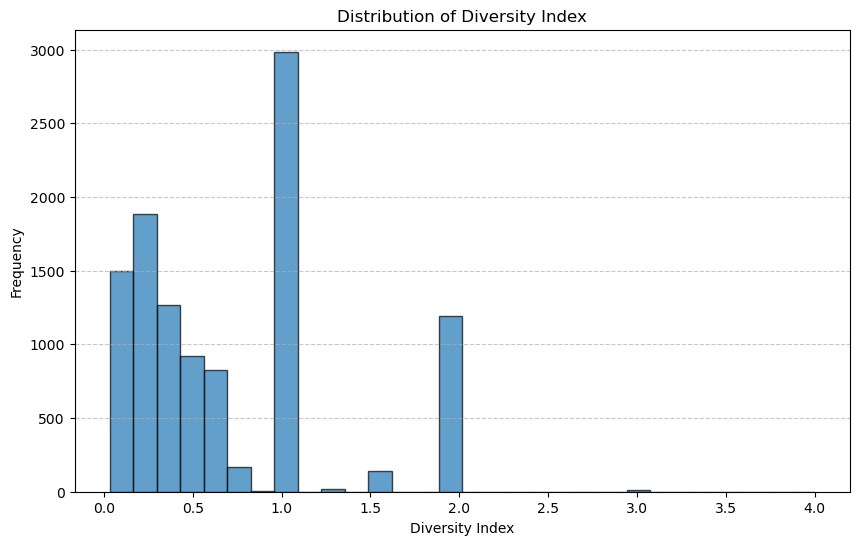

In [130]:
# plotting the distribution of the diversity index
plt.figure(figsize=(10, 6))
plt.hist(filtered_movie_ethnicity_stats['diversity_index'], bins=30, edgecolor='black', alpha=0.7)
plt.title("Distribution of Diversity Index")
plt.xlabel("Diversity Index")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

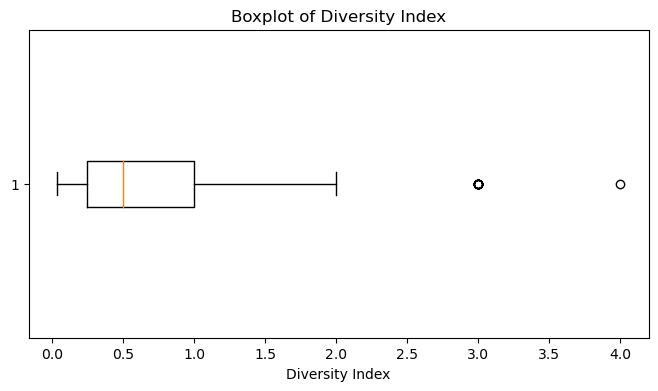

In [131]:
# boxplot for diversity index to identify potential outliers
plt.figure(figsize=(8, 4))
plt.boxplot(filtered_movie_ethnicity_stats['diversity_index'], vert=False)
plt.title("Boxplot of Diversity Index")
plt.xlabel("Diversity Index")
plt.show()

We acknowledge the presence of outliers in the diversity index, which represent movies with exceptionally high diversity. While these outliers may impact the overall analysis, they are retained to capture the full range of diversity in the dataset.

In [132]:
movie_ethnicity_stats = filtered_movie_ethnicity_stats.merge(df_reversed, on='wikipedia_id', how='left')

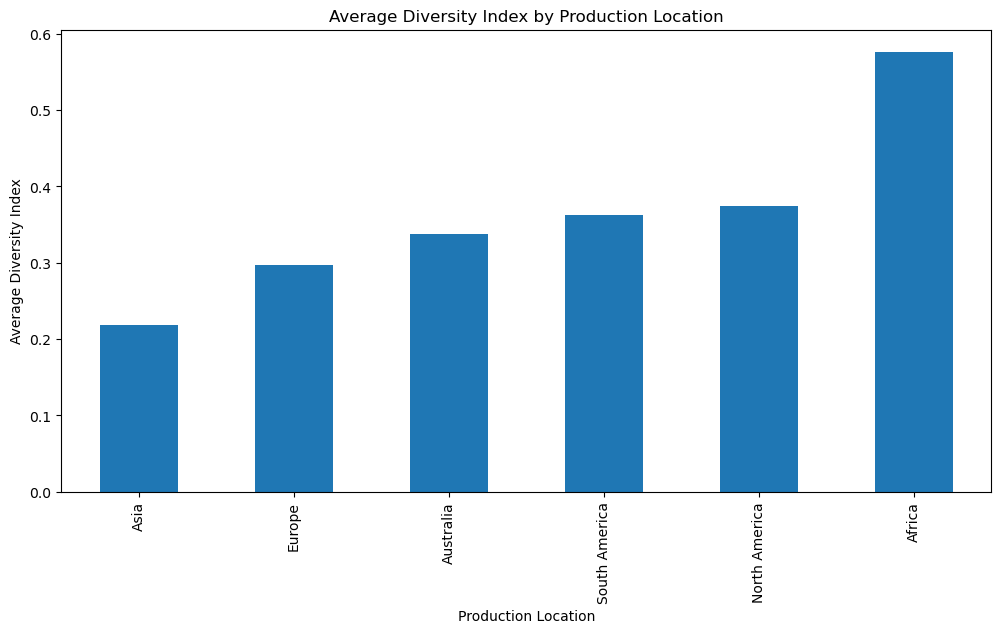

In [133]:
# grouping by production location and calculate mean and median diversity index
diversity_by_location = movie_ethnicity_stats.groupby('continent')['diversity_index'].agg(['mean', 'median'])

# plotting diversity index by location
plt.figure(figsize=(12, 6))
diversity_by_location['mean'].sort_values().plot(kind='bar', title='Average Diversity Index by Production Location')
plt.ylabel('Average Diversity Index')
plt.xlabel('Production Location')
plt.show()


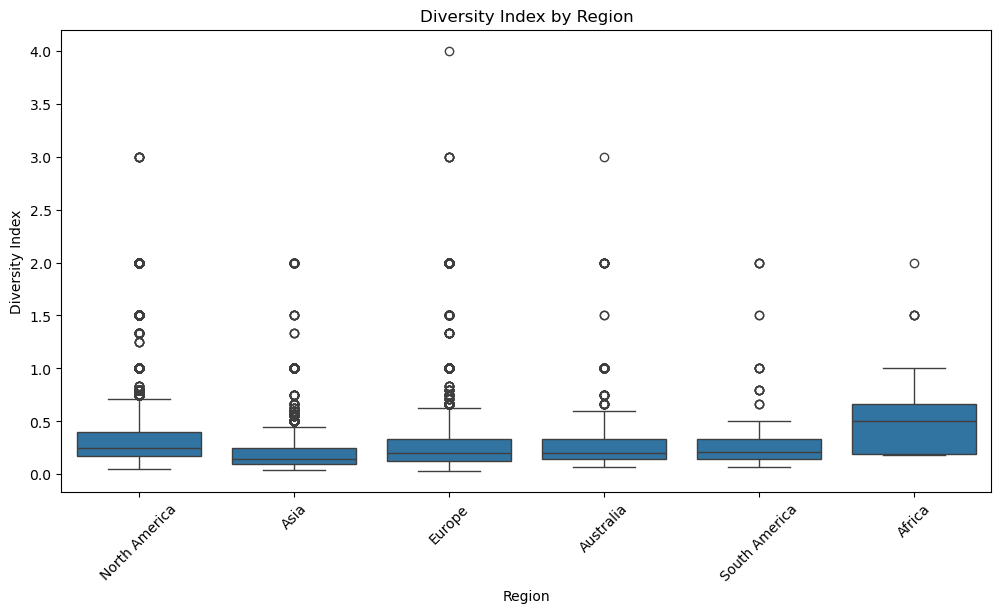

In [134]:
# create a boxplot of Diversity Index by continent
plt.figure(figsize=(12, 6))
sns.boxplot(x='continent', y='diversity_index', data=movie_ethnicity_stats)
plt.title("Diversity Index by Region")
plt.xlabel("Region")
plt.ylabel("Diversity Index")
plt.xticks(rotation=45)
plt.show()

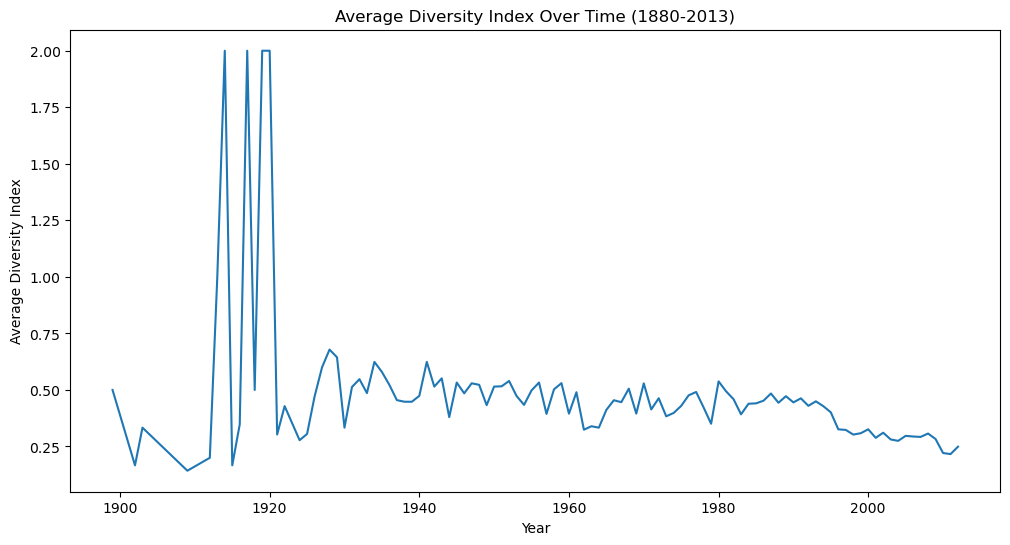

In [135]:
# grouping by year and calculate mean diversity index within the specified years
movie_ethnicity_stats = movie_ethnicity_stats[
    (movie_ethnicity_stats['release_date'] >= 1880) &
    (movie_ethnicity_stats['release_date']<= 2013)
]


diversity_over_time = movie_ethnicity_stats.groupby('release_date')['diversity_index'].mean()

# plotting diversity index over time
plt.figure(figsize=(12, 6))
diversity_over_time.plot(kind='line', title='Average Diversity Index Over Time (1880-2013)')
plt.ylabel('Average Diversity Index')
plt.xlabel('Year')
plt.show()

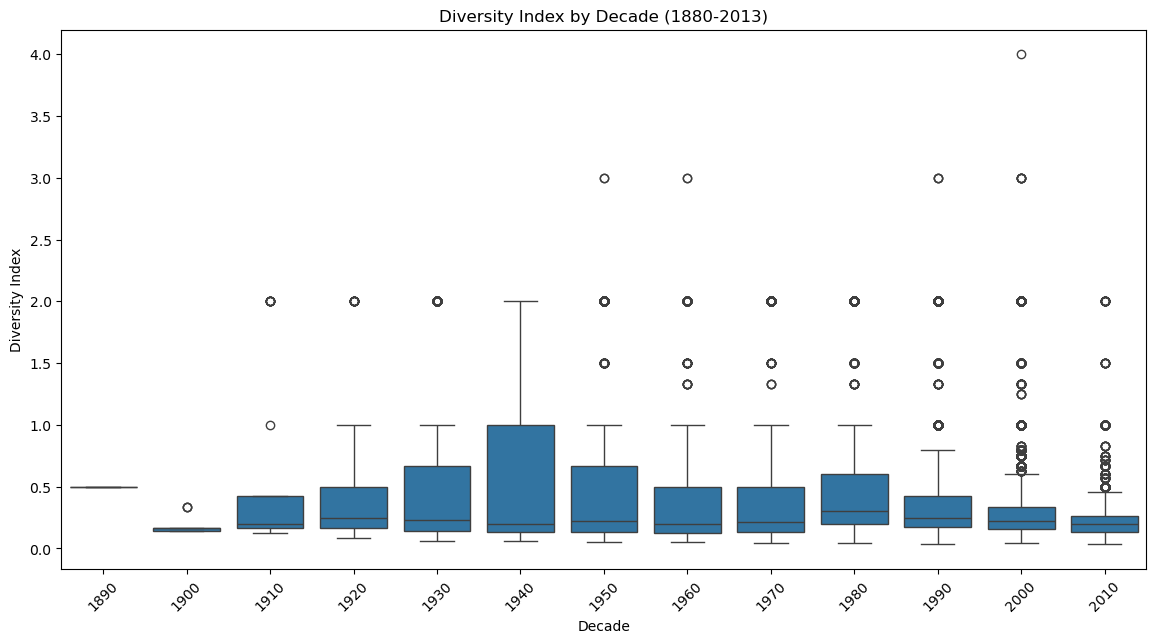

In [136]:
movie_ethnicity_stats['decade'] = (movie_ethnicity_stats['release_date'] // 10) * 10

plt.figure(figsize=(14, 7))
sns.boxplot(data=movie_ethnicity_stats, x='decade', y='diversity_index')
plt.title('Diversity Index by Decade (1880-2013)')
plt.xlabel('Decade')
plt.ylabel('Diversity Index')
plt.xticks(rotation=45)
plt.show()

From the 1980s onwards, there seems to be a slight increase in the spread and number of outliers, suggesting that diversity in casting may have become more variable in recent decades.

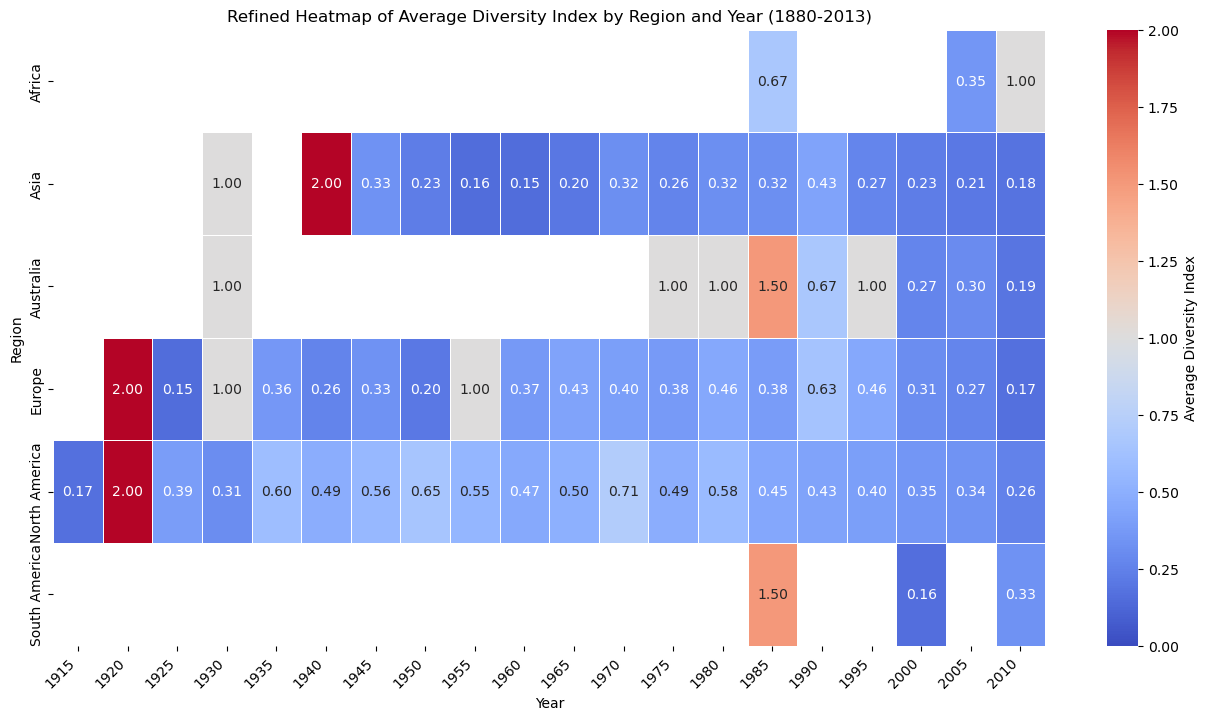

In [137]:
# pivot the data to prepare for the heatmap
heatmap_data = movie_ethnicity_stats.pivot_table(
    values='diversity_index', 
    index='continent', 
    columns='release_date', 
    aggfunc='mean'
)

# limit year ticks to every 5 years for clarity
heatmap_data.columns = heatmap_data.columns.astype(int)  # Ensure columns are int for slicing
heatmap_data = heatmap_data.loc[:, heatmap_data.columns % 5 == 0]

# define a refined color map
cmap = sns.color_palette("coolwarm", as_cmap=True)

# plotting the heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(heatmap_data, cmap=cmap, annot=True, fmt=".2f", linewidths=.5, cbar_kws={'label': 'Average Diversity Index'}, vmin=0, vmax=2)
plt.title("Refined Heatmap of Average Diversity Index by Region and Year (1880-2013)")
plt.xlabel("Year")
plt.ylabel("Region")
plt.xticks(rotation=45, ha='right')
plt.show()

North America and Europe show moderate and consistent diversity, especially from the 1950s onward, with North America generally stable. Asia and Australia have sparse data but show occasional high diversity peaks.
Temporal Trends: 
- Diversity increases in the 1950s–1980s, particularly in North America and Europe, but decreases in the 1980s, suggesting fluctuating representation levels.
- High diversity outliers appear in early European films (1900) and sporadically in Asia and Australia.

### More complex diversity index

In simple proportion-based diversity scores, outliers can skew the results. We are not capturing the true spread of diversity.
Possobilities: 
- **Shannon Index** offers a balanced measure of diversity, reducing the impact of outliers and providing a more accurate view of diversity distribution. We will be looking at the entropy of distribution. 
- **Simpson Index** is sensitive to dominant categories, making it useful when measuring the dominance of one group over others. 

Both indexes give a more holistic view of diversity than simple proportions.

https://bera-journals.onlinelibrary.wiley.com/doi/full/10.1002/berj.3482

In [138]:
df_exploded_continents = df_reversed.explode('actor_continent')  

# grouping by movie ID and ethnicity to count occurrences of each ethnicity within each movie
ethnicity_counts = df_exploded_continents.groupby(['wikipedia_id', 'actor_continent']).size().unstack(fill_value=0)

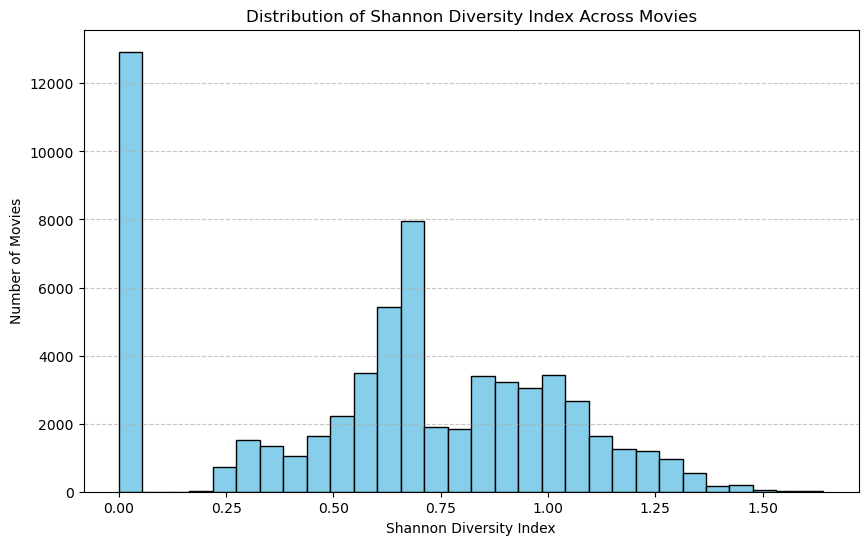

In [139]:
def calculate_shannon_index(row):
    proportions = row / row.sum()
    return -np.sum(proportions * np.log(proportions + 1e-9))

# applying Shannon Index to each movie (each row in ethnicity_counts)
ethnicity_counts['shannon_diversity_index'] = ethnicity_counts.apply(calculate_shannon_index, axis=1)

# merging the diversity index back to the main movie statistics DataFrame
movie_ethnicity_stats = movie_ethnicity_stats.merge(
    ethnicity_counts[['shannon_diversity_index']], 
    left_on='wikipedia_id', 
    right_index=True,
    how='left'
)

# plot the Shannon Diversity Index distribution
plt.figure(figsize=(10, 6))
plt.hist(movie_ethnicity_stats['shannon_diversity_index'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Shannon Diversity Index")
plt.ylabel("Number of Movies")
plt.title("Distribution of Shannon Diversity Index Across Movies")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()